# Initial setup

This analysis using ema is based on the work of Enayat A. Moallemi created on 22 May 2018 at the Fraunhofer ISI, Karlsruhe. In that instance, the analysis was done for the MATISSE model.
This notebook  has been modified to:
- Use EMA workbench scenario discovery tools with GR4SP model
    - Open exploration for each output of interest
    - PRIM and other directed search algorithms to study three transitions scenarios low carbon (LCT), just (JT), and sustainable (ST))
- Include PRIM helper functions to identigy the input settings for the scenarios achieving the targets

In [1]:
"""
Based on Enayat A. Moallemi version from May 2018

edited by Angela M. Rojas A. <angelara@student.unimelb.edu.au>

Created on February 2020

"""

import sys
import os

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\EMAworkbench')

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments')

#from ema_workbench.analysis.plotting_util import BOXPLOT, KDE, VIOLIN
from ema_workbench.analysis.plotting import envelopes
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import matplotlib.cm as cm
import seaborn as sns
from ema_workbench.analysis import prim
#import pareto
import os
import glob
import numpy as np
import pandas as pd
import os
import glob
import datetime as DT




C:\Users\angel\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__



## Load the results

In [2]:
from ema_workbench import load_results

#results = load_results(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\data\gr4sp_2020-Feb-20-years.tar.gz')
#results = load_results(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\data\gr4sp_2020-Feb-07_EET_allV3.tar.gz')
#results = load_results(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\data\gr4sp_2020-Feb-25-LHS.tar.gz')
#results = load_results(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/gr4sp_EET2020-Oct-05.tar.gz')
results = load_results(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/gr4sp_SOBOL2021-Feb-03.tar.gz')



In [3]:
experiments, outcomes = results
experiments.describe()

annualCpi  annualInflation    consumption  \
count  126000.000000    126000.000000  126000.000000   
mean        3.000238         2.998810       1.999048   
std         1.415313         1.415313       1.414556   
min         1.000000         1.000000       0.000000   
25%         2.000000         2.000000       1.000000   
50%         3.000000         3.000000       2.000000   
75%         4.000000         4.000000       3.000000   
max         5.000000         5.000000       4.000000   

       domesticConsumptionPercentage  energyEfficiency  \
count                  126000.000000     126000.000000   
mean                       34.990000          1.000714   
std                         8.939456          0.816645   
min                        20.000000          0.000000   
25%                        27.000000          0.000000   
50%                        35.000000          1.000000   
75%                        43.000000          2.000000   
max                        50.000000          2.000000   

       generationRolloutPeriod  generatorRetirement  importPriceFactor  \
count            126000.000000        126000.000000      126000.000000   
mean                  5.497143            -0.001429          -0.007143   
std                   2.872126             3.161913          29.152702   
min                   1.000000            -5.000000         -50.000000   
25%                   3.000000            -3.000000         -25.000000   
50%                   5.500000             0.000000           0.000000   
75%                   8.000000             3.000000          25.000000   
max                  10.000000             5.000000          50.000000   

       includePublicallyAnnouncedGen  learningCurve  ...  \
count                  126000.000000  126000.000000  ...   
mean                        0.500000       7.497143  ...   
std                         0.500002       4.609583  ...   
min                         0.000000       0.000000  ...   
25%                         0.000000       3.750000  ...   
50%                         0.500000       7.500000  ...   
75%                         1.000000      11.250000  ...   
max                         1.000000      15.000000  ...   

       priceChangePercentageBrownCoal  priceChangePercentageOcgt  \
count                   126000.000000              126000.000000   
mean                        -0.018333                   0.006190   
std                         29.153567                  29.154507   
min                        -50.000000                 -50.000000   
25%                        -25.000000                 -25.000000   
50%                          0.000000                   0.000000   
75%                         25.000000                  25.000000   
max                         50.000000                  50.000000   

       priceChangePercentageWater  priceChangePercentageWind      rooftopPV  \
count               126000.000000              126000.000000  126000.000000   
mean                     0.005000                   0.000714       5.999524   
std                     29.151743                  29.152674       0.816208   
min                    -50.000000                 -50.000000       5.000000   
25%                    -25.000000                 -25.000000       5.000000   
50%                      0.000000                   0.000000       6.000000   
75%                     25.000000                  25.000000       7.000000   
max                     50.000000                  50.000000       7.000000   

       scheduleMinCapMarketGen  semiScheduleGenSpotMarket  \
count            126000.000000              126000.000000   
mean                150.541905                   8.998333   
std                  86.593375                   0.816061   
min                   1.000000                   8.000000   
25%                  75.750000                   8.000000   
50%                 150.500000                   9.000000   
75%                 225

## Load Energy Vulnerability

In [4]:
# Energy vulnerability results
ev_results_df = pd.read_excel(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/notebookGr4sp/outputs/data/EV_all_sobol.xlsx', index_col=[0])
ev_results_BAU_df = pd.read_excel(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/notebookGr4sp/outputs/data/EV_all_BAU.xlsx', index_col=[0])

In [5]:
# Duplicate results from 2040 into the years of 2040-2050

ev_results_df.insert(0, 1998, ev_results_df[2000])
ev_results_df.insert(0, 1999, ev_results_df[2000])
for t in range(2041,2051):
     ev_results_df[t] = ev_results_df[2040]
        
# Add it to outcomes data structure
outcomes['Energy Vulnerability Percentage'] = ev_results_df.values

In [6]:
# Duplicate results BAU from 2040 into the years of 2040-2050

ev_results_BAU_df.insert(0, 1998, ev_results_BAU_df[2000])
ev_results_BAU_df.insert(0, 1999, ev_results_BAU_df[2000])
for t in range(2041,2051):
     ev_results_BAU_df[t] = ev_results_BAU_df[2040]
        
# Add it to outcomes data structure
outcomes['Energy Vulnerability Percentage'] =  np.append(outcomes['Energy Vulnerability Percentage'],
                                                         ev_results_BAU_df.values, axis=0)

In [7]:
# # Energy vulnerability results
# ev_results_df_bau = pd.read_excel(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/notebookGr4sp/outputs/data/EV_oneScenario.xlsx', index_col=[0,1,2])

# # Aggregate desagregated groups into a total parcentage
# ev_bau = ev_results_df_bau.mean()

# ev_bau_98_99 = pd.DataFrame(data=[ev_bau[2000],ev_bau[2000]],index=[1998,1999])
# ev_bau_full = pd.concat([ev_bau_98_99, ev_bau], axis=0)

# # Duplicate results from 2040 into the years of 2040-2050
# for t in range(2041,2051):
#      ev_bau_full.loc[t] = ev_bau_full.loc[2040]
        
# outcomes['Energy Vulnerability Percentage'] = np.append(outcomes['Energy Vulnerability Percentage'],
#                                                  [ev_bau_full.T.values[0]], axis=0)

## Load BAU

In [8]:
bau_scenario_id = max(experiments['scenario']) + 1

new_row = pd.DataFrame({'annualCpi': 2.33, 'annualInflation': 3.3, 'importPriceFactor': 29, 'nameplateCapacityChangeBrownCoal': 0,
       'nameplateCapacityChangeWater': 0,'nameplateCapacityChangeBattery': 0,
        'nameplateCapacityChangeSolar': 0, 'nameplateCapacityChangeWind': 0,
        'nameplateCapacityChangeOcgt': 0, 'consumption': 0, 'energyEfficiency': 0,
       'generationRolloutPeriod':1, 'generatorRetirement':0,
       'includePublicallyAnnouncedGen':0, 'learningCurve':5,
       'nonScheduleGenSpotMarket': 10, 'nonScheduleMinCapMarketGen':1,
       'priceChangePercentageBrownCoal':0, 'priceChangePercentageOcgt':0,
       'priceChangePercentageWater':0, 'priceChangePercentageWind':0, 'priceChangePercentageBattery':0, 'rooftopPV':7,
       'domesticConsumptionPercentage':30,
       'scheduleMinCapMarketGen':300, 'semiScheduleGenSpotMarket':8,
       'semiScheduleMinCapMarketGen':300, 'solarUptake':0,
        'wholesaleTariffContribution':28.37, 'scenario': bau_scenario_id,
       'policy': "None", 'model': 'Gr4sp'}, index =[0]) 
# simply concatenate both dataframes 
experiments = pd.concat([experiments,new_row],sort=True).reset_index(drop = True) 

# rename none in policy column into constant value 0. PRIM fails otherwise.
if "None" in experiments["policy"].unique():
    experiments["policy"] = experiments["policy"].replace("None",int(0))

In [9]:
#Results for BAU were generated with the 'light' setting in the model.
bau_results_df = pd.read_csv(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/VICSimDataYearSummary_160221-BAU-1998-2051.csv')
bau_results_df.head()

Time (Year)  Consumption (KWh) per household  \
0         1998                      7274.621326   
1         1999                      7972.760042   
2         2000                      8336.261405   
3         2001                      8225.690958   
4         2002                      8195.767319   

   Avg Tariff (c/KWh) per household  Primary Wholesale ($/MWh)  \
0                         26.621281                   0.000000   
1                         23.351999                  17.529518   
2                         14.290676                  25.878248   
3                         15.696864                  22.072247   
4                         10.385764                  25.678888   

   GHG Emissions (tCO2-e) per household  \
0                              9.241233   
1                             10.169690   
2                             10.462258   
3                             10.284990   
4                             10.154013   

   Number of Domestic Consumers (households)  Percentage Renewable Production  \
0                                  1637917.0                         0.019037   
1                                  1666850.0                         0.024080   
2                                  1695784.0                         0.034438   
3                                  1724718.0                         0.035015   
4                                  1753652.0                         0.041821   

   System Production Primary Spot  System Production Secondary Spot  \
0                    0.000000e+00                               0.0   
1                    4.417793e+07                               0.0   
2                    4.693226e+07                               0.0   
3                    4.694292e+07                               0.0   
4                    4.746060e+07                               0.0   

   System Production Off Spot  ...  \
0                    0.000000  ...   
1               443764.080000  ...   
2               444979.872000  ...   
3               592307.850000  ...   
4               752769.978226  ...   

   285000 - Battery - Gannawarra Energy Storage System - 25.33 - S - 2020 - 2033 - OffSpot  \
0                                                0.0                                         
1                                                0.0                                         
2                                                0.0                                         
3                                                0.0                                         
4                                                0.0                                         

   293000 - Wind - Berrybank Wind Farm - 180.6 - SS - 2020 - 2050 - Primary  \
0                                                0.0                          
1                                                0.0                          
2                                                0.0                          
3                                                0.0                          
4                                                0.0                          

   295000 - Wind - Moorabool Wind Farm - 320.32 - SS - 2020 - 2044 - Primary  \
0                                                0.0                           
1                                                0.0                           
2                                                0.0                           
3                                                0.0                           
4                                                0.0                           

   297000 - Wind - Stockyard Hill Wind Farm - 531.93 - SS - 2020 - 2045 - Primary  \
0                                                0.0                                
1                                                0.0                                
2                                                0.0                                
3                                   

In [10]:
# #This cell adds BAU trajectory from 1998-2019. To add 1998 to 2050, comment this cell and uncomment the one below

# seed_bau = bau_scenario_id + 1
# outcomes['TIMEYear'] = np.append(outcomes['TIMEYear'],
#                                           [bau_results_df['Time (Year)'].values[:22]], axis=0)
# outcomes['consumptionYear'] = np.append(outcomes['consumptionYear'],
#                                                  [bau_results_df['Consumption (KWh) per household'].values[:22]], axis=0)
# outcomes['tariffsYear'] = np.append(outcomes['tariffsYear'],
#                                                  [bau_results_df['Avg Tariff (c/KWh) per household'].values[:22]], axis=0)
# outcomes['wholesalePriceYear'] = np.append(outcomes['wholesalePriceYear'],
#                                                  [bau_results_df['Primary Wholesale ($/MWh)'].values[:22]], axis=0)
# outcomes['GHGYear'] = np.append(outcomes['GHGYear'],
#                                                  [bau_results_df['GHG Emissions (tCO2-e) per household'].values[:22]], axis=0)
# outcomes['numConsumersYear'] = np.append(outcomes['numConsumersYear'],
#                                                  [bau_results_df['Number of Domestic Consumers (households)'].values[:22]], axis=0)
# outcomes['primarySpotProductionYear'] = np.append(outcomes['primarySpotProductionYear'],
#                                                  [bau_results_df['System Production Primary Spot'].values[:22]], axis=0)
# outcomes['secondarySpotProductionYear'] = np.append(outcomes['secondarySpotProductionYear'],
#                                                  [bau_results_df['System Production Secondary Spot'].values[:22]], axis=0)
# outcomes['offSpotProductionYear'] = np.append(outcomes['offSpotProductionYear'],
#                                                  [bau_results_df['System Production Off Spot'].values[:22]], axis=0)
# outcomes['renewableContributionYear'] = np.append(outcomes['renewableContributionYear'],
#                                                  [bau_results_df['Percentage Renewable Production'].values[:22]], axis=0)
# outcomes['rooftopPVProductionYear'] = np.append(outcomes['rooftopPVProductionYear'],
#                                                  [bau_results_df['System Production Rooftop PV'].values[:22]], axis=0)
# outcomes['coalProductionYear'] = np.append(outcomes['coalProductionYear'],
#                                                  [bau_results_df['System Production Coal'].values[:22]], axis=0)
# outcomes['windProductionYear'] = np.append(outcomes['windProductionYear'],
#                                                  [bau_results_df['System Production Wind'].values[:22]], axis=0)
# outcomes['gasProductionYear'] = np.append(outcomes['gasProductionYear'],
#                                                  [bau_results_df['System Production Gas'].values[:22]], axis=0)
# outcomes['solarProductionYear'] = np.append(outcomes['solarProductionYear'],
#                                                  [bau_results_df['System Production Solar'].values[:22]], axis=0)   
# outcomes['waterProductionYear'] = np.append(outcomes['waterProductionYear'],
#                                                  [bau_results_df['System Production Water'].values[:22]], axis=0)
# outcomes['BatteryProductionYear'] = np.append(outcomes['BatteryProductionYear'],
#                                                  [bau_results_df['System Production Battery'].values[:22]], axis=0)
# outcomes['numActorsYear'] = np.append(outcomes['numActorsYear'],
#                                                  [bau_results_df['Number of Active Actors'].values[:22]], axis=0)
# outcomes['primaryUnmetDemandMwh'] = np.append(outcomes['primaryUnmetDemandMwh'],
#                                                  [bau_results_df['Primary Total Unmet Demand (MWh)'].values[:22]], axis=0)
# outcomes['primaryUnmetDemandHours'] = np.append(outcomes['primaryUnmetDemandHours'],
#                                                  [bau_results_df['Primary Total Unmet Demand (Hours)'].values[:22]], axis=0)
# outcomes['primaryUnmetDemandDays'] = np.append(outcomes['primaryUnmetDemandDays'],
#                                                  [bau_results_df['Primary Total Unmet Demand (Days)'].values[:22]], axis=0)
# outcomes['primaryMaxUnmetDemandMwhPerHour'] = np.append(outcomes['primaryMaxUnmetDemandMwhPerHour'],
#                                                  [bau_results_df['Primary Max Unmet Demand Per Hour (MWh)'].values[:22]], axis=0)
# outcomes['secondaryUnmetDemandMwh'] = np.append(outcomes['secondaryUnmetDemandMwh'],
#                                                  [bau_results_df['Secondary Total Unmet Demand (MWh)'].values[:22]], axis=0)
# outcomes['secondaryUnmetDemandHours'] = np.append(outcomes['secondaryUnmetDemandHours'],
#                                                  [bau_results_df['Secondary Total Unmet Demand (Hours)'].values[:22]], axis=0)
# outcomes['secondaryUnmetDemandDays'] = np.append(outcomes['secondaryUnmetDemandDays'],
#                                                  [bau_results_df['Secondary Total Unmet Demand (Days)'].values[:22]], axis=0)
# outcomes['secondaryMaxUnmetDemandMwhPerHour'] = np.append(outcomes['secondaryMaxUnmetDemandMwhPerHour'],
#                                                  [bau_results_df['Secondary Max Unmet Demand Per Hour (MWh)'].values[:22]], axis=0)
                                          
# outcomes['seedExperimentCsv'] = np.append(outcomes['seedExperimentCsv'], [seed_bau], axis=0)


In [11]:
seed_bau = bau_scenario_id + 1
outcomes['TIMEYear'] = np.append(outcomes['TIMEYear'],
                                          [bau_results_df['Time (Year)'].values], axis=0)
outcomes['consumptionYear'] = np.append(outcomes['consumptionYear'],
                                                 [bau_results_df['Consumption (KWh) per household'].values], axis=0)
outcomes['tariffsYear'] = np.append(outcomes['tariffsYear'],
                                                 [bau_results_df['Avg Tariff (c/KWh) per household'].values], axis=0)
outcomes['wholesalePriceYear'] = np.append(outcomes['wholesalePriceYear'],
                                                 [bau_results_df['Primary Wholesale ($/MWh)'].values], axis=0)
outcomes['GHGYear'] = np.append(outcomes['GHGYear'],
                                                 [bau_results_df['GHG Emissions (tCO2-e) per household'].values], axis=0)
outcomes['numConsumersYear'] = np.append(outcomes['numConsumersYear'],
                                                 [bau_results_df['Number of Domestic Consumers (households)'].values], axis=0)
outcomes['primarySpotProductionYear'] = np.append(outcomes['primarySpotProductionYear'],
                                                 [bau_results_df['System Production Primary Spot'].values], axis=0)
outcomes['secondarySpotProductionYear'] = np.append(outcomes['secondarySpotProductionYear'],
                                                 [bau_results_df['System Production Secondary Spot'].values], axis=0)
outcomes['offSpotProductionYear'] = np.append(outcomes['offSpotProductionYear'],
                                                 [bau_results_df['System Production Off Spot'].values], axis=0)
outcomes['renewableContributionYear'] = np.append(outcomes['renewableContributionYear'],
                                                 [bau_results_df['Percentage Renewable Production'].values], axis=0)
outcomes['rooftopPVProductionYear'] = np.append(outcomes['rooftopPVProductionYear'],
                                                 [bau_results_df['System Production Rooftop PV'].values], axis=0)
outcomes['coalProductionYear'] = np.append(outcomes['coalProductionYear'],
                                                 [bau_results_df['System Production Coal'].values], axis=0)
outcomes['windProductionYear'] = np.append(outcomes['windProductionYear'],
                                                 [bau_results_df['System Production Wind'].values], axis=0)
outcomes['gasProductionYear'] = np.append(outcomes['gasProductionYear'],
                                                 [bau_results_df['System Production Gas'].values], axis=0)
outcomes['solarProductionYear'] = np.append(outcomes['solarProductionYear'],
                                                 [bau_results_df['System Production Solar'].values], axis=0)   
outcomes['waterProductionYear'] = np.append(outcomes['waterProductionYear'],
                                                 [bau_results_df['System Production Water'].values], axis=0)
outcomes['BatteryProductionYear'] = np.append(outcomes['BatteryProductionYear'],
                                                 [bau_results_df['System Production Battery'].values], axis=0)
outcomes['numActorsYear'] = np.append(outcomes['numActorsYear'],
                                                 [bau_results_df['Number of Active Actors'].values], axis=0)
outcomes['primaryUnmetDemandMwh'] = np.append(outcomes['primaryUnmetDemandMwh'],
                                                 [bau_results_df['Primary Total Unmet Demand (MWh)'].values], axis=0)
outcomes['primaryUnmetDemandHours'] = np.append(outcomes['primaryUnmetDemandHours'],
                                                 [bau_results_df['Primary Total Unmet Demand (Hours)'].values], axis=0)
outcomes['primaryUnmetDemandDays'] = np.append(outcomes['primaryUnmetDemandDays'],
                                                 [bau_results_df['Primary Total Unmet Demand (Days)'].values], axis=0)
outcomes['primaryMaxUnmetDemandMwhPerHour'] = np.append(outcomes['primaryMaxUnmetDemandMwhPerHour'],
                                                 [bau_results_df['Primary Max Unmet Demand Per Hour (MWh)'].values], axis=0)
outcomes['secondaryUnmetDemandMwh'] = np.append(outcomes['secondaryUnmetDemandMwh'],
                                                 [bau_results_df['Secondary Total Unmet Demand (MWh)'].values], axis=0)
outcomes['secondaryUnmetDemandHours'] = np.append(outcomes['secondaryUnmetDemandHours'],
                                                 [bau_results_df['Secondary Total Unmet Demand (Hours)'].values], axis=0)
outcomes['secondaryUnmetDemandDays'] = np.append(outcomes['secondaryUnmetDemandDays'],
                                                 [bau_results_df['Secondary Total Unmet Demand (Days)'].values], axis=0)
outcomes['secondaryMaxUnmetDemandMwhPerHour'] = np.append(outcomes['secondaryMaxUnmetDemandMwhPerHour'],
                                                 [bau_results_df['Secondary Max Unmet Demand Per Hour (MWh)'].values], axis=0)

outcomes['seedExperimentCsv'] = np.append(outcomes['seedExperimentCsv'], [seed_bau], axis=0)


## General parameters

In [12]:
outcomes['PrimarySpot-WholesalePriceYear'] = outcomes['wholesalePriceYear']

outcomes_to_show = ['consumptionYear', 'tariffsYear', 'PrimarySpot-WholesalePriceYear', 'GHGYear', 
                    'numConsumersYear', 'primarySpotProductionYear', 'secondarySpotProductionYear', 
                    'offSpotProductionYear', 'renewableContributionYear', 'rooftopPVProductionYear', 
                    'coalProductionYear', 'waterProductionYear', 'windProductionYear', 'gasProductionYear', 
                    'solarProductionYear', 'BatteryProductionYear', 'numActorsYear', 'primaryUnmetDemandMwh', 
                    'primaryUnmetDemandHours', 'primaryUnmetDemandDays', 'primaryMaxUnmetDemandMwhPerHour', 
                    'secondaryUnmetDemandMwh', 'secondaryUnmetDemandHours', 'secondaryUnmetDemandDays', 
                    'secondaryMaxUnmetDemandMwhPerHour']

# 23 levers/uncertainties selected after EET (last test July 2020)
# 25 uncertainties selected aftet EET including change on domestic demand and unmet demand output (August 2020)
uncertainties = experiments.columns[:-3]

#from startYear
startYear = 2000
startYearShift = (startYear - 1998)

time = outcomes['TIMEYear'][0, startYearShift:]

points_of_interest = [*range(2020,2051,10)] 
#points_of_interest = [*range(2000,2019,5)] 

points_of_interest = [ x - startYear for x in points_of_interest]

# Filter outcomes taking into account the startYear, and removing Seed Experiment info. 
# Seed it is useful if I want to retrieve more info from the csv files, or redo the experiments with the
# simulation parameters
outcomes_filtered = {k:v[:, startYearShift:] for k,v in outcomes.items() if k != 'seedExperimentCsv'}


## Aggregate Household data

GHG emissions and Consumption per household type converted to total sector


In [13]:
ooi = 'GHGYear'
data_GHG_household = outcomes_filtered[ooi]

In [14]:
""" Converts household data in tCO2e into total residential data in MtCO2e"""
data_GHG_residential = (data_GHG_household * outcomes_filtered['numConsumersYear']) / 1000000.0
data_GHG_residential_bau = (bau_results_df['GHG Emissions (tCO2-e) per household'] * bau_results_df['Number of Domestic Consumers (households)']) / 1000000.0

""" Applies scaling factor used in simulation, so that data represents total emissions, not only residential (30%)"""
data_GHG_total = data_GHG_residential / 0.3
data_GHG_total_bau = data_GHG_residential_bau / 0.3


"""Overwrite GHG with the data of interest"""
outcomes_filtered[ooi] = data_GHG_total
bau_results_df[ooi] = data_GHG_total_bau

In [15]:
ooi = 'consumptionYear'
data_consumption_household = outcomes_filtered[ooi]

In [16]:
""" Converts household data in KWh into total residential data in MWh"""
data_consumption_residential = (data_consumption_household * outcomes_filtered['numConsumersYear']) / 1000.0

""" Applies scaling factor used in simulation, so that data represents total consumption, not only residential"""
data_consumption_total = data_consumption_residential / 0.3

"""Overwrite Consumption with the data of interest"""
outcomes_filtered[ooi] = data_consumption_total

## Create Percentage of Unmet Consumption

In [17]:
primary = outcomes_filtered['primarySpotProductionYear']
secondary = outcomes_filtered['secondarySpotProductionYear']
off = outcomes_filtered['offSpotProductionYear']
unmetPrimary = outcomes_filtered['primaryUnmetDemandMwh']
unmetSecondary = outcomes_filtered['secondaryUnmetDemandMwh']

consumptionPrimary = primary + off + unmetPrimary
consumptionSecondary = secondary + off + unmetSecondary

percentageUnmetPrimary = (unmetPrimary/consumptionPrimary)*100
percentageUnmetSecondary = np.divide(unmetSecondary, consumptionSecondary, 
                                     out=np.zeros_like(unmetSecondary), where=consumptionSecondary!=0) *100
    
where_are_NaNs = np.isnan(percentageUnmetPrimary)
percentageUnmetPrimary[where_are_NaNs] = 0

where_are_NaNs = np.isnan(percentageUnmetSecondary)
percentageUnmetSecondary[where_are_NaNs] = 0

outcomes_filtered['unmetPercentageConsumptionPrimary'] = percentageUnmetPrimary
outcomes_filtered['unmetPercentageConsumptionSecondary'] = percentageUnmetSecondary

In [18]:
primary = bau_results_df['System Production Primary Spot']
secondary = bau_results_df['System Production Secondary Spot']
off = bau_results_df['System Production Off Spot']
unmetPrimary = bau_results_df['Primary Total Unmet Demand (MWh)']
unmetSecondary = bau_results_df['Secondary Total Unmet Demand (MWh)']

consumptionPrimary = primary + off + unmetPrimary
consumptionSecondary = secondary + off + unmetSecondary

percentageUnmetPrimary = (unmetPrimary/consumptionPrimary)*100
percentageUnmetSecondary = np.divide(unmetSecondary, consumptionSecondary, 
                                     out=np.zeros_like(unmetSecondary), where=consumptionSecondary!=0) *100

where_are_NaNs = np.isnan(percentageUnmetPrimary)
percentageUnmetPrimary[where_are_NaNs] = 0

where_are_NaNs = np.isnan(percentageUnmetSecondary)
percentageUnmetSecondary[where_are_NaNs] = 0

bau_results_df['unmetPercentageConsumptionPrimary'] = percentageUnmetPrimary
bau_results_df['unmetPercentageConsumptionSecondary'] = percentageUnmetSecondary

# Target functions

In [19]:
def target_always_after(outcomes,ooi,targetYear,targetVal,above):
    data = outcomes[ooi]
    num_exp = len(data)
    achieved = np.zeros(num_exp, dtype=bool)

    for i in range(num_exp):
        achieved[i] = False
        exp_run = data[i]
        for j in range( len(exp_run) ):
            if (startYear + j) >= targetYear:
                if above is True:
                    achieved[i] = exp_run[j] >= targetVal
                else:
                    achieved[i] = exp_run[j] < targetVal
                    
                #If the target is not achieved after the TargetYear, then mark experiment as False
                if achieved[i] == False:
                    break
    return achieved

def target_at_year(outcomes,ooi,targetYear,targetVal,above):
    data = outcomes[ooi]
    num_exp = len(data)
    achieved = np.zeros(num_exp, dtype=bool)

    for i in range(num_exp):
        achieved[i] = False
        exp_run = data[i]
        
        idx = targetYear - startYear
        if above is True:
            achieved[i] = exp_run[idx] >= targetVal
        else:
            achieved[i] = exp_run[idx] < targetVal                        
                
    return achieved

# PRIM Helper Functions

In [20]:
def BoxExperimentsScores( box1, selected_box, y, allinputsScore = False ):
    # Get limits from box
    qps = [(key, value) for key, value in box1.qp[selected_box].items()]
    relevantInputs = [key for key, value in box1.qp[selected_box].items()]

    box_lim = {}
    for inputFactor, qp in qps:
        values = box1.box_lims[selected_box][inputFactor]
        box_lim[inputFactor] = [values[0], values[1], qp[0], qp[1]]

    # Get experiment ids that comply with the target
    experimentsInTarget = [ i for i, exp in enumerate(y)  if exp == True ]

    # Filter experiments that comply with the target and the box limit
    experimentsInBox = pd.DataFrame(None, columns=experiments.columns.tolist() + ['score'])

    bau_exp = experiments.loc[bau_scenario_id]
    for expIdx in experimentsInTarget:
            expInTarget = experiments.loc[expIdx]
            inBox = True
            for key, (minExp,maxExp, qpMin, qpMax) in box_lim.items():
                if expInTarget[key] < minExp or expInTarget[key] > maxExp:
                    inBox = False
                    break
            if inBox is True:
                # Compute score as the sum of absolute distances across inputs, normalized by the value that can be further from bau, i.e. max( max_lim - bau, bau - min_lim)
                # For example, If we have 29 input factors, and the score is 31, it means that the experiments inputs were all the farthest possible for each inptut from bau.
                score = 0.0
                quadrant = '-'
                if allinputsScore:
                    for key,bauVal,val in zip(bau_exp.index,bau_exp.values,expInTarget.values):
                        if isinstance(val, float) and key != 'scenario':
                            score += abs(float(bauVal) - float(val)) / max(maxExp - bauVal, bauVal - minExp)
                else:
                    for key,bauVal,val in zip(bau_exp[relevantInputs].index,bau_exp[relevantInputs].values,expInTarget[relevantInputs].values):
                        if isinstance(val, float) and key != 'scenario':
                            score += abs(float(bauVal) - float(val)) / max(maxExp - bauVal, bauVal - minExp)
                expInTarget = pd.concat([expInTarget, pd.Series([score], index=['score'])], ignore_index=False)
                experimentsInBox = experimentsInBox.append(expInTarget, ignore_index=True )
                
    return experimentsInBox.sort_values(by=['score'])

def plotInputTargetBox(ooi,targetYear,refLine):

    targetValue = [ out[targetYear-startYear] for out in outcomes_filtered[ooi][experimentsInBox.index] ]

    g = sns.jointplot(x=targetValue, y=experimentsInBox[inp],  kind="hex")
    g.ax_joint.axhline(experiments.loc[bau_scenario_id][inp], ls='--', color='green')
    g.ax_joint.axvline(refLine, ls='--', color='red')
    g.ax_joint.set_xlabel(f'{ooi} - {targetYear}')

# Scenario discovery

## Open Exploration: Visual Analysis


Truncate experiments and outcomes for a selected policy and a selected outcome over mean in time series

### GHG emissions

In [22]:
#Subset of levers/uncertainties
#selected_levers = list(['rooftopPV', 'annualCpi','capacityFactorChangeBrownCoal','capacityFactorChangeWater','semiScheduleMinCapMarketGen'])    
selected_uncertainties = uncertainties

ooi = 'GHGYear'

data = outcomes_filtered[ooi]


num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

The following section uses PRIM, feature scoring and dimensional stacking to find the cases that represent futures in three main groups: Low Carbon, Just Transition and Sustainable Transition.

It uses targets (e.g. cases for which emissions are the lowest at year x) to filter out the cases and find out the corresponding input variables and ranges for the cases to happen.

The first case is on GHG emissions. To find out the targets for exploration, first let's analyse the envelope diagram (see below) showing how the transition may unfold:

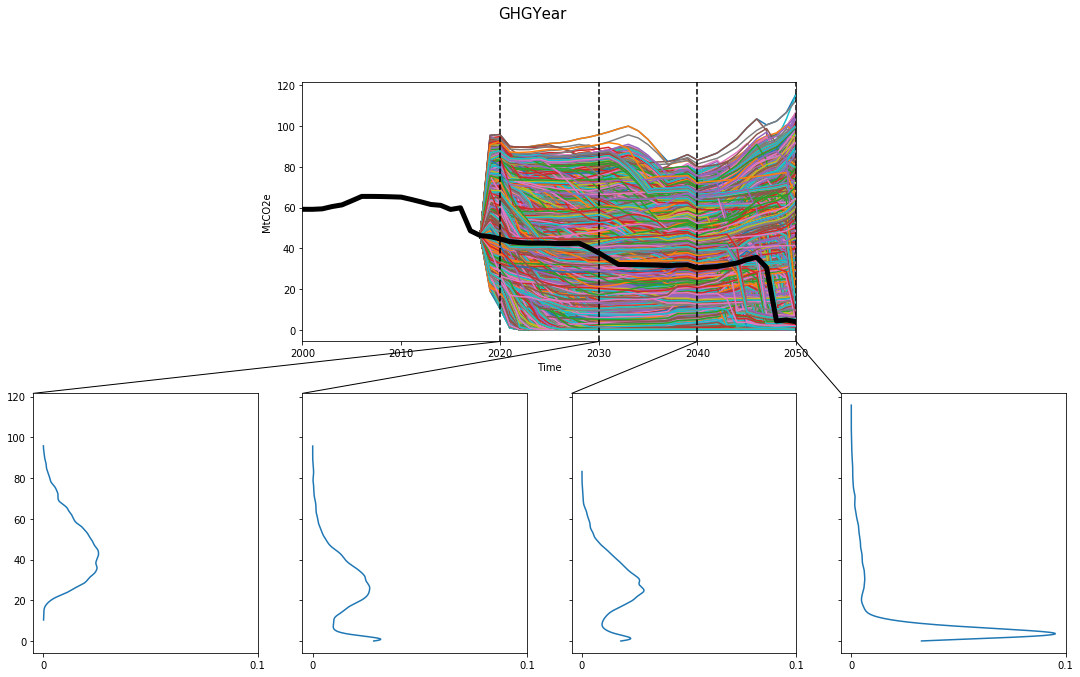

In [20]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest, density = Density.KDE, grouping_specifiers=None, 
                                 titles={ooi}, ylabels={ooi: "MtCO2e"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

#Add BAU in the plot with a gray wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'k-',linewidth=5 )

## Show labels
# labels = ax_env['F']['main plot'].get_xticklabels()
# for l in labels:
#     print (l.get_text)

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', 'envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')
    

Densities (PDF): {'18.1 to 25.9': '0.007', '25.9 to 33.7': '0.021', '33.7 to 41.5': '0.025', '41.5 to 49.2': '0.025', '49.2 to 57.0': '0.021', '57.0 to 64.8': '0.013', '64.8 to 72.5': '0.009', '72.5 to 80.3': '0.005', '80.3 to 88.1': '0.002'}
% in Bin: {'10.4 to 18.1': '0.3%', '18.1 to 25.9': '5.8%', '25.9 to 33.7': '16.1%', '33.7 to 41.5': '19.5%', '41.5 to 49.2': '19.7%', '49.2 to 57.0': '16.2%', '57.0 to 64.8': '10.5%', '64.8 to 72.5': '6.6%', '72.5 to 80.3': '3.8%', '80.3 to 88.1': '1.4%', '88.1 to 95.8': '0.3%'}

Densities (PDF): {'0.1 to 8.8': '0.022', '8.8 to 17.5': '0.013', '17.5 to 26.2': '0.025', '26.2 to 34.8': '0.025', '34.8 to 43.5': '0.017', '43.5 to 52.2': '0.008', '52.2 to 60.9': '0.003', '60.9 to 69.6': '0.002'}
% in Bin: {'0.1 to 8.8': '19.5%', '8.8 to 17.5': '10.9%', '17.5 to 26.2': '21.4%', '26.2 to 34.8': '21.9%', '34.8 to 43.5': '14.5%', '43.5 to 52.2': '6.8%', '52.2 to 60.9': '2.9%', '60.9 to 69.6': '1.3%', '69.6 to 78.3': '0.5%', '78.3 to 87.0': '0.3%', '87.0 to

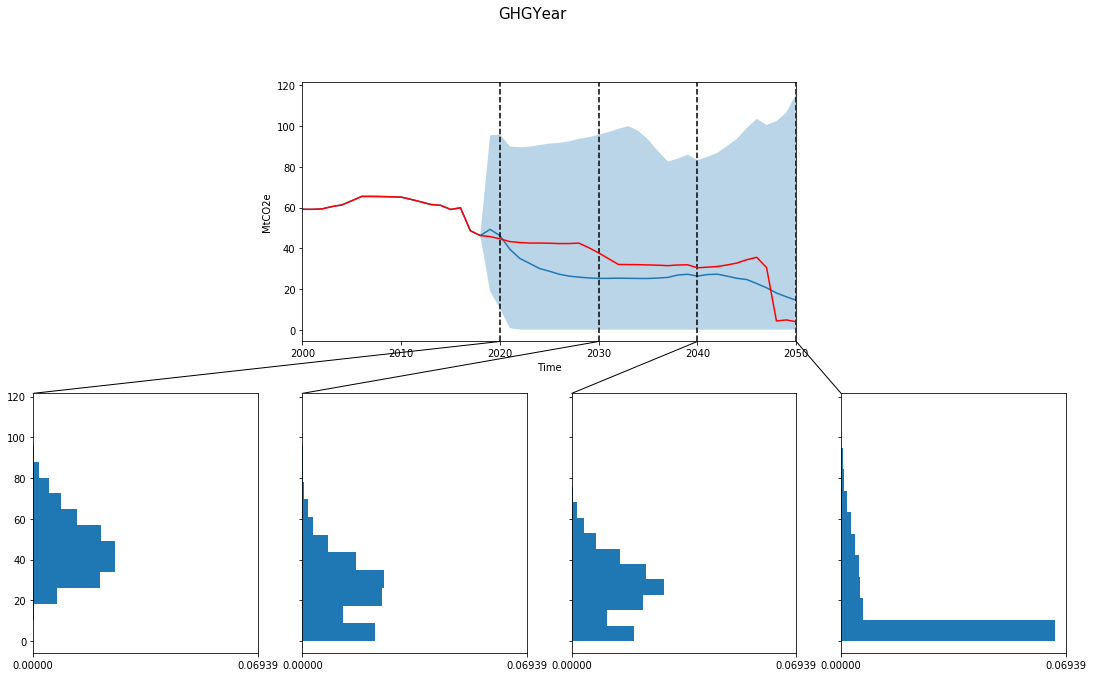

In [21]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest, density = Density.HIST, grouping_specifiers=None,
                                 titles={ooi}, ylabels={ooi: "MtCO2e"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

#Add BAU in the plot with a gray red line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'r-')

## Show labels
# labels = ax_env['F']['main plot'].get_xticklabels()
# for l in labels:
#     print (l.get_text)

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)
#plt.legend()

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')


### PrimarySpot Wholesale Price

In [20]:
# Subset Sobol levers
#selected_levers = list(['rooftopPV','annualCpi', 'generationRolloutPeriod', 'generatorRetirement','capacityFactorChangeBrownCoal','semiScheduleMinCapMarketGen'])    

select_uncertainties = uncertainties
ooi = 'PrimarySpot-WholesalePriceYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, select_uncertainties] 

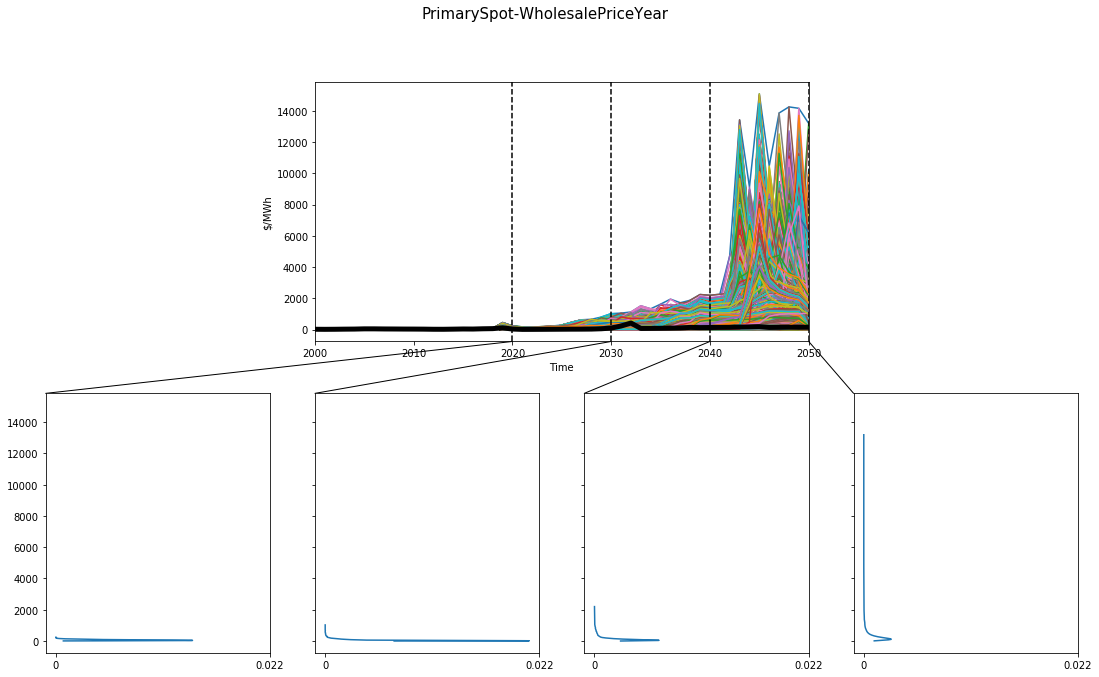

In [23]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

# fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
#                                  points_in_time=points_of_interest,  density = Density.KDE,
#                                  grouping_specifiers=None , titles={ooi}, ylabels={ooi: "$/MWh"}, legend=True,
#                                  fill=False, plot_type=PlotType.ENV_LIN)

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "$/MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)
#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a black wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'k-',linewidth=5 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

Densities (PDF): {'5.7 to 27.2': '0.007', '27.2 to 48.7': '0.014', '48.7 to 70.2': '0.012', '70.2 to 91.7': '0.007', '91.7 to 113.2': '0.004', '113.2 to 134.8': '0.002'}
% in Bin: {'5.7 to 27.2': '15.9%', '27.2 to 48.7': '29.6%', '48.7 to 70.2': '24.9%', '70.2 to 91.7': '16.0%', '91.7 to 113.2': '8.0%', '113.2 to 134.8': '3.4%', '134.8 to 156.3': '1.7%', '156.3 to 177.8': '0.4%', '177.8 to 199.3': '0.1%', '199.3 to 220.8': '0.0%', '220.8 to 242.3': '0.0%'}

Densities (PDF): {'0.0 to 93.5': '0.009', '93.5 to 187.1': '0.001'}
% in Bin: {'0.0 to 93.5': '82.6%', '93.5 to 187.1': '12.7%', '187.1 to 280.6': '2.9%', '280.6 to 374.2': '1.1%', '374.2 to 467.7': '0.5%', '467.7 to 561.3': '0.2%', '561.3 to 654.8': '0.0%', '654.8 to 748.4': '0.0%', '748.4 to 841.9': '0.0%', '841.9 to 935.5': '0.0%', '935.5 to 1029.0': '0.0%'}

Densities (PDF): {'0.0 to 200.2': '0.004'}
% in Bin: {'0.0 to 200.2': '78.9%', '200.2 to 400.3': '10.6%', '400.3 to 600.5': '5.3%', '600.5 to 800.6': '2.8%', '800.6 to 1000.

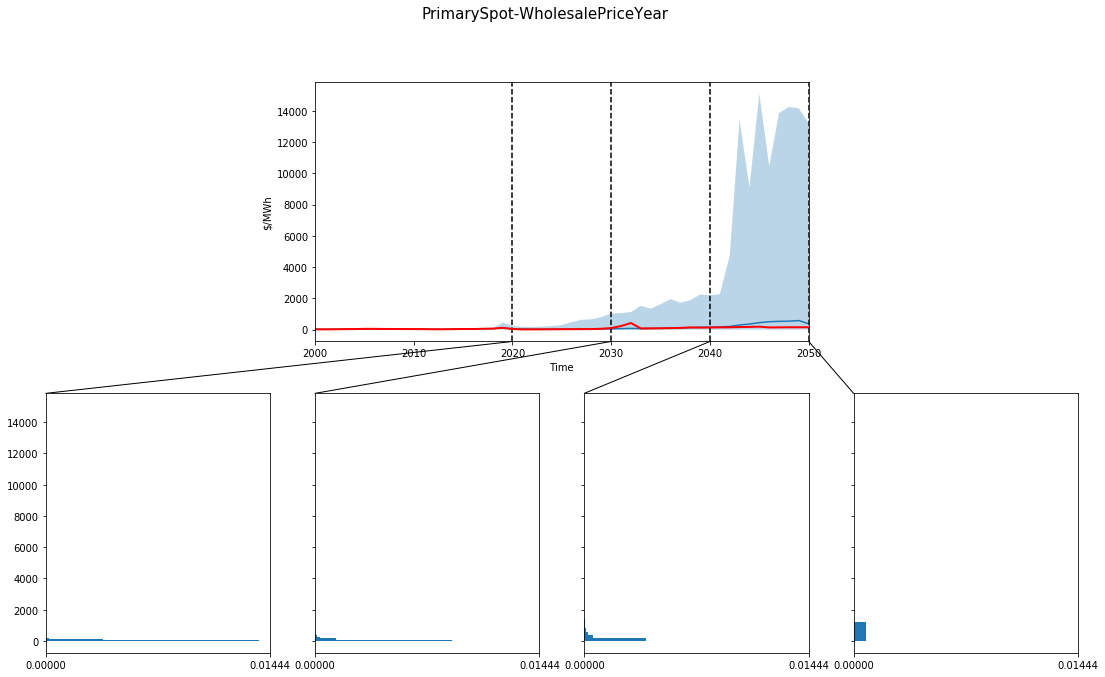

In [23]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

# fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
#                                  points_in_time=points_of_interest,  density = Density.HIST,
#                                  grouping_specifiers=None , titles={ooi}, ylabels={ooi: "$/MWh"}, legend=True,
#                                  fill=True, plot_type=PlotType.ENVELOPE)

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.HIST,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "$/MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a red wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'r-',linewidth=2 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_future_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')



### Tariffs

In [21]:
# Subset Sool levers/uncertainties
selected_uncertainties = uncertainties

#selected_levers = levers
ooi = 'tariffsYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

: 20-25% by 2025 on 2017. tariffs in 2017: ~21 c/KWh

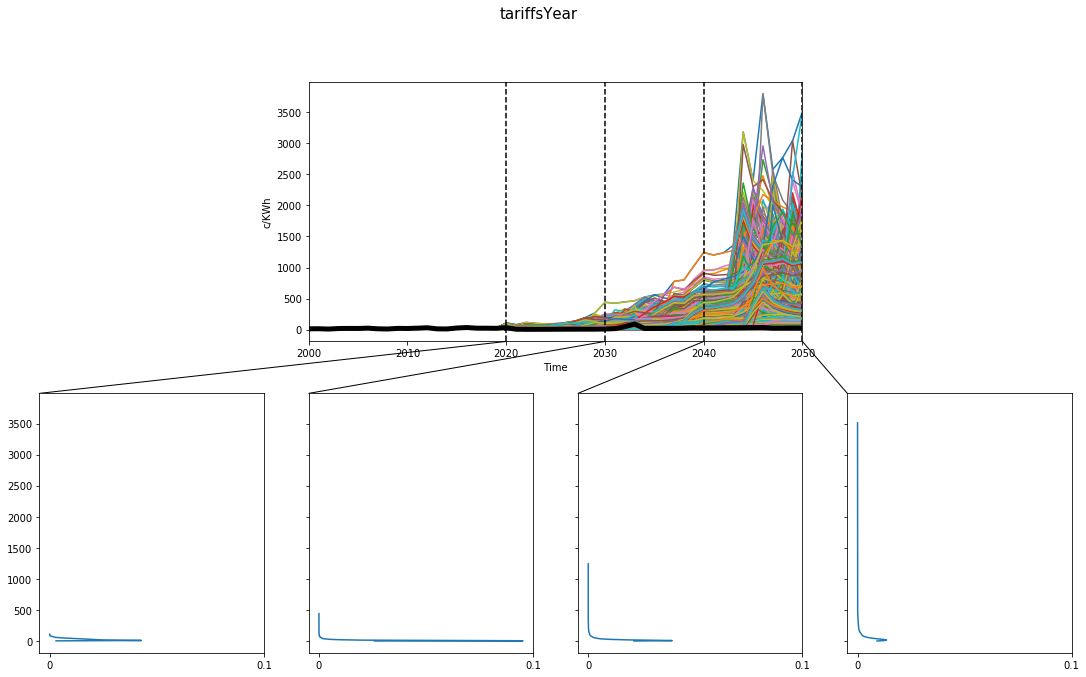

In [21]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "c/KWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a black wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'k-',linewidth=5 )


fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_future_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

Densities (PDF): {'2.8 to 12.5': '0.030', '12.5 to 22.3': '0.025', '22.3 to 32.0': '0.019', '32.0 to 41.7': '0.014', '41.7 to 51.4': '0.008', '51.4 to 61.1': '0.004', '61.1 to 70.9': '0.002', '70.9 to 80.6': '0.001'}
% in Bin: {'2.8 to 12.5': '29.2%', '12.5 to 22.3': '24.0%', '22.3 to 32.0': '18.9%', '32.0 to 41.7': '13.4%', '41.7 to 51.4': '7.8%', '51.4 to 61.1': '3.7%', '61.1 to 70.9': '2.0%', '70.9 to 80.6': '0.9%', '80.6 to 90.3': '0.2%', '90.3 to 100.0': '0.1%', '100.0 to 109.8': '0.0%'}

Densities (PDF): {'0.8 to 40.8': '0.024'}
% in Bin: {'0.8 to 40.8': '96.0%', '40.8 to 80.8': '3.1%', '80.8 to 120.9': '0.5%', '120.9 to 160.9': '0.2%', '160.9 to 200.9': '0.1%', '200.9 to 241.0': '0.1%', '241.0 to 281.0': '0.0%', '281.0 to 321.1': '0.0%', '321.1 to 361.1': '0.0%', '361.1 to 401.1': '0.0%', '401.1 to 441.2': '0.0%'}

Densities (PDF): {'0.6 to 113.4': '0.008'}
% in Bin: {'0.6 to 113.4': '95.8%', '113.4 to 226.2': '3.1%', '226.2 to 339.1': '0.8%', '339.1 to 451.9': '0.2%', '451.9 to

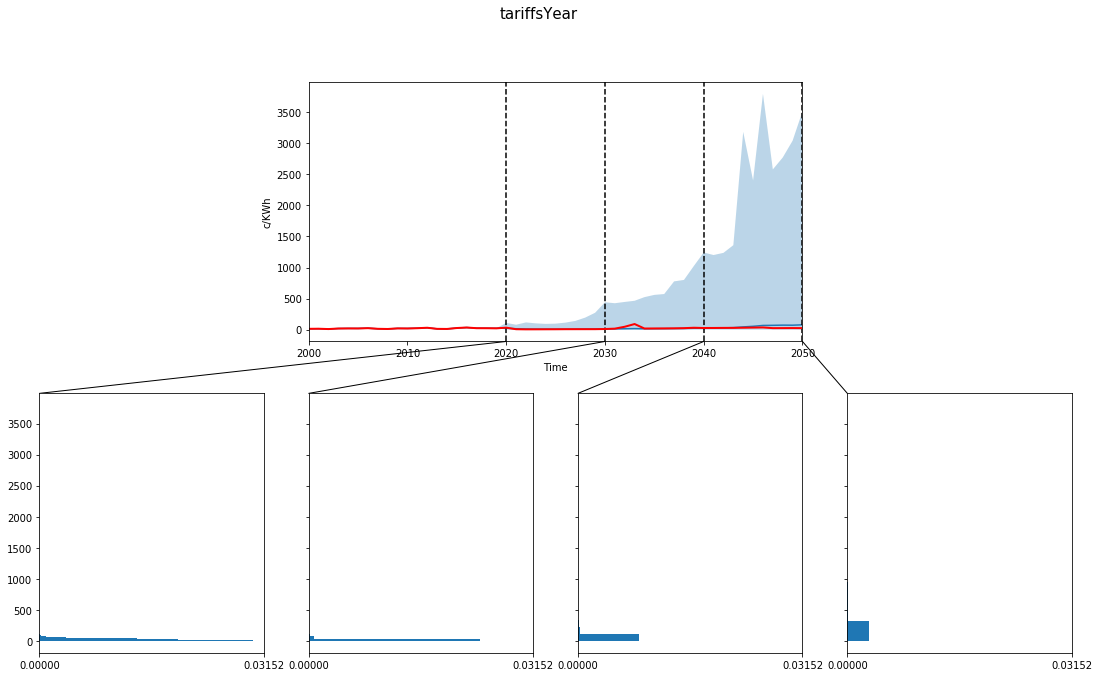

In [25]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.HIST,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "c/KWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a red wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'r-',linewidth=2 )


fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_future_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')


### Renewable Energies in the System

In [22]:
# Subset Sool levers/uncertainties

selected_uncertainties = uncertainties

ooi = 'renewableContributionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

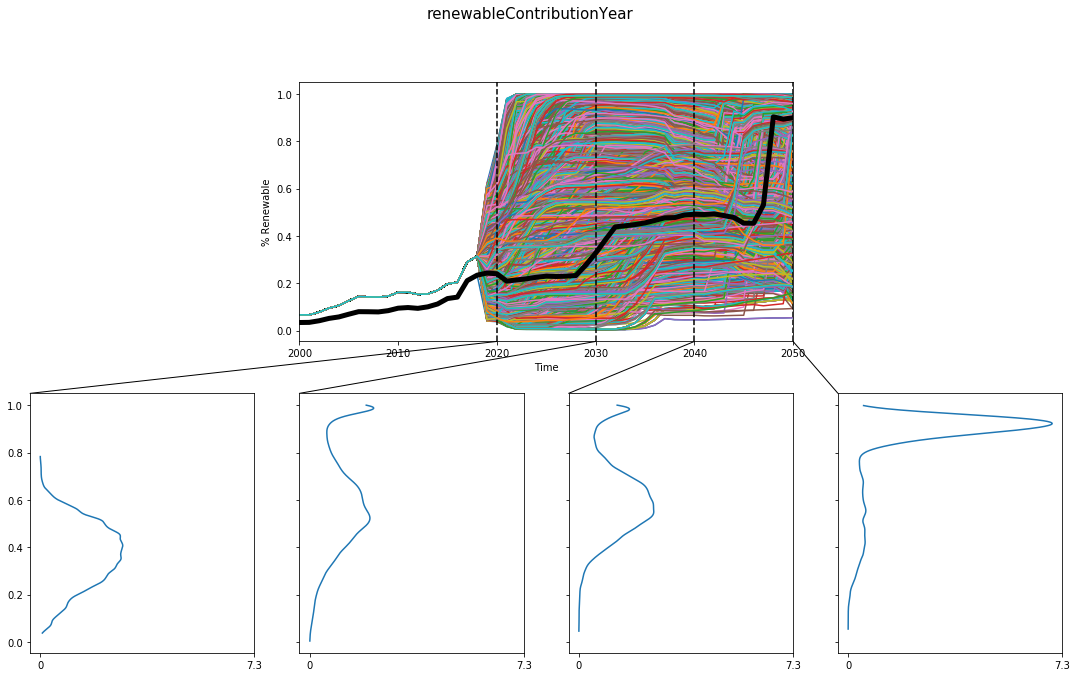

In [24]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "% Renewable"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a black wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'k-',linewidth=5 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_future_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

Densities (PDF): {'0.0 to 0.1': '0.316', '0.1 to 0.2': '0.804', '0.2 to 0.2': '1.397', '0.2 to 0.3': '2.254', '0.3 to 0.4': '2.715', '0.4 to 0.4': '2.762', '0.4 to 0.5': '2.448', '0.5 to 0.6': '1.488', '0.6 to 0.6': '0.495', '0.6 to 0.7': '0.065', '0.7 to 0.8': '0.020'}
% in Bin: {'0.0 to 0.1': '2.1%', '0.1 to 0.2': '5.4%', '0.2 to 0.2': '9.5%', '0.2 to 0.3': '15.3%', '0.3 to 0.4': '18.4%', '0.4 to 0.4': '18.7%', '0.4 to 0.5': '16.6%', '0.5 to 0.6': '10.1%', '0.6 to 0.6': '3.4%', '0.6 to 0.7': '0.4%', '0.7 to 0.8': '0.1%'}

Densities (PDF): {'0.0 to 0.1': '0.043', '0.1 to 0.2': '0.148', '0.2 to 0.3': '0.335', '0.3 to 0.4': '0.714', '0.4 to 0.5': '1.297', '0.5 to 0.5': '1.980', '0.5 to 0.6': '1.840', '0.6 to 0.7': '1.424', '0.7 to 0.8': '0.856', '0.8 to 0.9': '0.598', '0.9 to 1.0': '1.813'}
% in Bin: {'0.0 to 0.1': '0.4%', '0.1 to 0.2': '1.3%', '0.2 to 0.3': '3.0%', '0.3 to 0.4': '6.5%', '0.4 to 0.5': '11.7%', '0.5 to 0.5': '17.9%', '0.5 to 0.6': '16.7%', '0.6 to 0.7': '12.9%', '0.7 to 

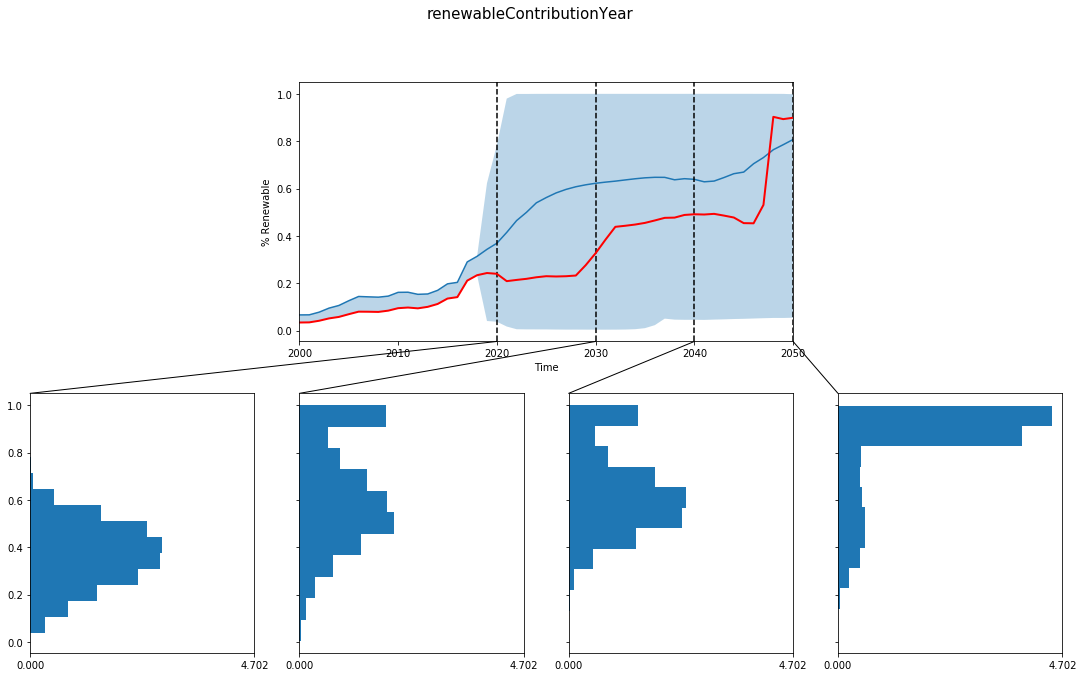

In [23]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.HIST,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "% Renewable"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a red wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'r-',linewidth=2 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_future_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

### Percentage  Primary Unmet Consumption

In [24]:
# Subset Sool levers
selected_uncertainties = uncertainties

ooi = 'unmetPercentageConsumptionPrimary'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

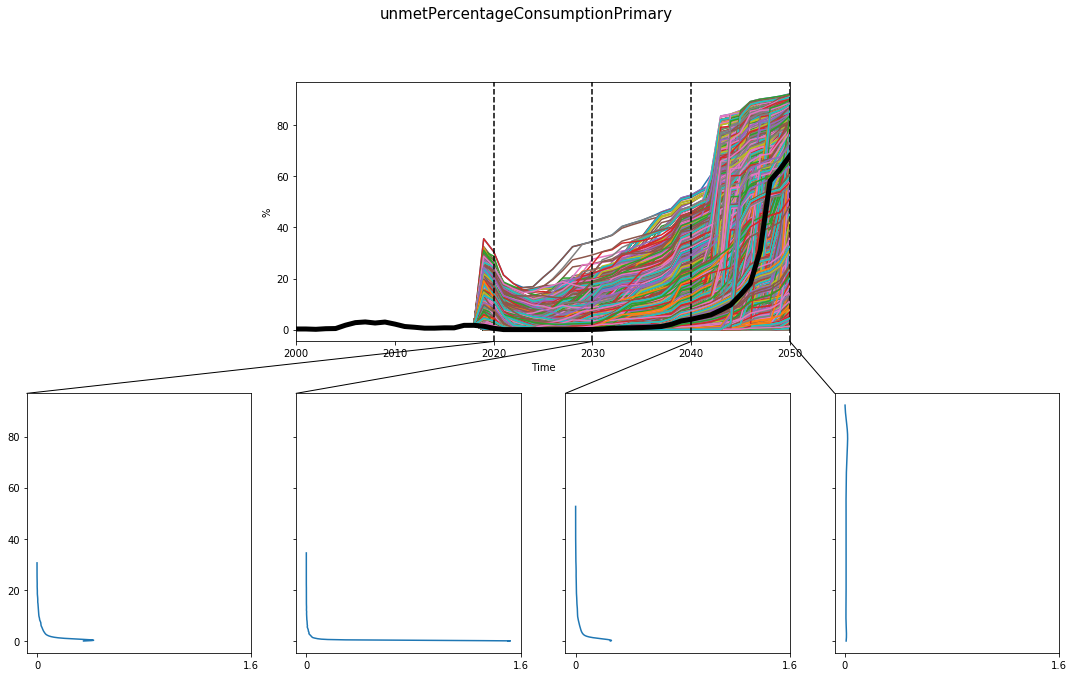

In [27]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "%"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a black wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'k-',linewidth=5 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_future_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

Densities (PDF): {'0.0 to 2.8': '0.246', '2.8 to 5.6': '0.048', '5.6 to 8.3': '0.027', '8.3 to 11.1': '0.016', '11.1 to 13.9': '0.011', '13.9 to 16.7': '0.007', '16.7 to 19.5': '0.003', '19.5 to 22.2': '0.001'}
% in Bin: {'0.0 to 2.8': '68.3%', '2.8 to 5.6': '13.4%', '5.6 to 8.3': '7.6%', '8.3 to 11.1': '4.4%', '11.1 to 13.9': '3.0%', '13.9 to 16.7': '1.8%', '16.7 to 19.5': '0.9%', '19.5 to 22.2': '0.4%', '22.2 to 25.0': '0.2%', '25.0 to 27.8': '0.0%', '27.8 to 30.6': '0.0%'}

Densities (PDF): {'0.0 to 3.1': '0.298', '3.1 to 6.3': '0.012', '6.3 to 9.4': '0.005', '9.4 to 12.5': '0.002', '12.5 to 15.7': '0.001'}
% in Bin: {'0.0 to 3.1': '93.3%', '3.1 to 6.3': '3.9%', '6.3 to 9.4': '1.6%', '9.4 to 12.5': '0.6%', '12.5 to 15.7': '0.3%', '15.7 to 18.8': '0.2%', '18.8 to 21.9': '0.1%', '21.9 to 25.1': '0.0%', '25.1 to 28.2': '0.0%', '28.2 to 31.3': '0.0%', '31.3 to 34.5': '0.0%'}

Densities (PDF): {'0.0 to 4.8': '0.148', '4.8 to 9.6': '0.025', '9.6 to 14.4': '0.013', '14.4 to 19.2': '0.008',

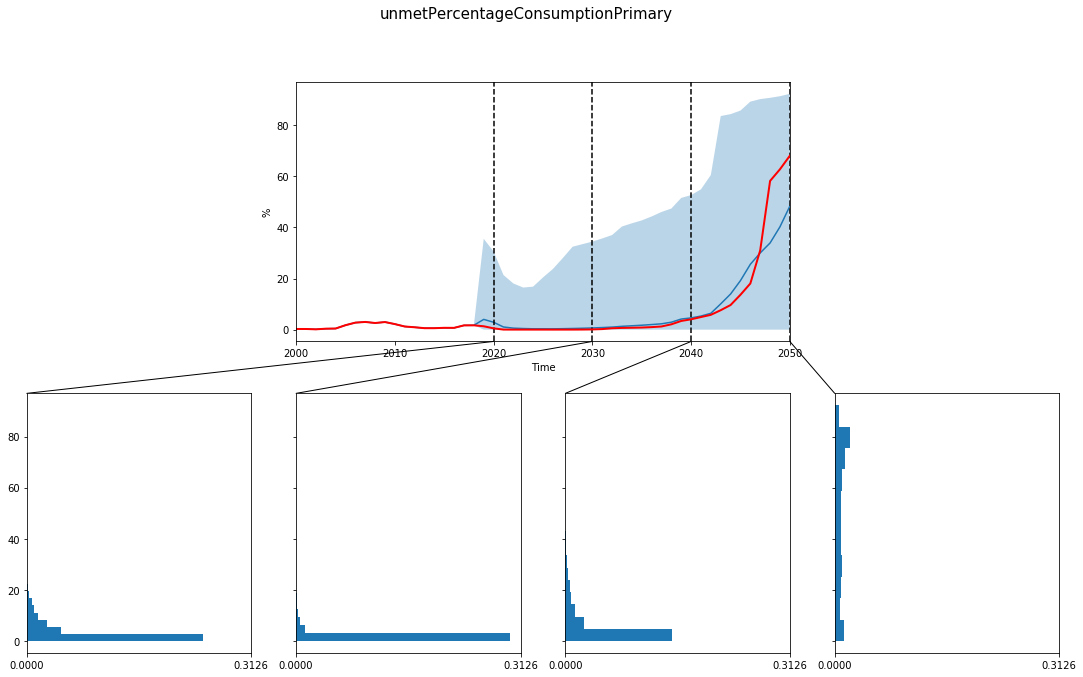

In [29]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.HIST,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "%"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a red wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'r-',linewidth=2 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_future_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

### Percentage  Secondary Unmet Consumption

In [25]:
# Subset Sool levers
selected_uncertainties = uncertainties

ooi = 'unmetPercentageConsumptionSecondary'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

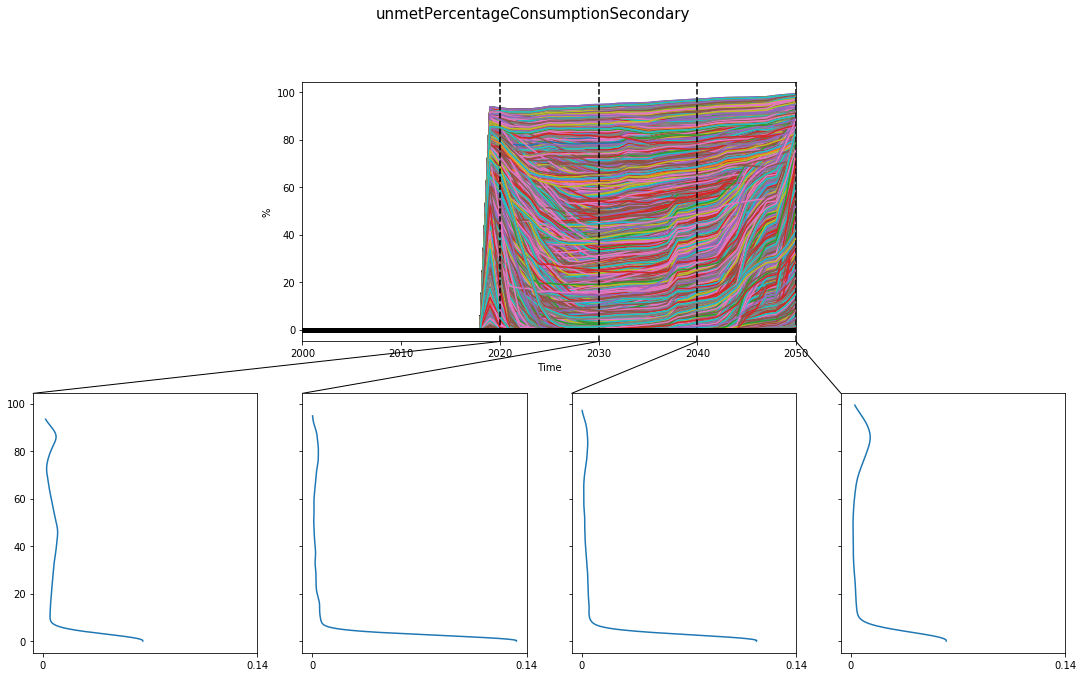

In [30]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "%"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a black wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'k-',linewidth=5 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_future_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

Densities (PDF): {'0.0 to 8.5': '0.057', '8.5 to 17.0': '0.005', '17.0 to 25.5': '0.006', '25.5 to 34.0': '0.007', '34.0 to 42.4': '0.009', '42.4 to 50.9': '0.009', '50.9 to 59.4': '0.007', '59.4 to 67.9': '0.004', '67.9 to 76.4': '0.002', '76.4 to 84.9': '0.005', '84.9 to 93.4': '0.007'}
% in Bin: {'0.0 to 8.5': '48.3%', '8.5 to 17.0': '4.1%', '17.0 to 25.5': '4.8%', '25.5 to 34.0': '5.6%', '34.0 to 42.4': '7.3%', '42.4 to 50.9': '7.9%', '50.9 to 59.4': '5.9%', '59.4 to 67.9': '3.7%', '67.9 to 76.4': '1.9%', '76.4 to 84.9': '4.7%', '84.9 to 93.4': '5.8%'}

Densities (PDF): {'0.0 to 8.6': '0.092', '8.6 to 17.2': '0.005', '17.2 to 25.9': '0.003', '25.9 to 34.5': '0.002', '34.5 to 43.1': '0.002', '43.1 to 51.7': '0.001', '51.7 to 60.3': '0.001', '60.3 to 68.9': '0.002', '68.9 to 77.6': '0.003', '77.6 to 86.2': '0.004', '86.2 to 94.8': '0.002'}
% in Bin: {'0.0 to 8.6': '78.9%', '8.6 to 17.2': '4.3%', '17.2 to 25.9': '2.4%', '25.9 to 34.5': '1.8%', '34.5 to 43.1': '1.8%', '43.1 to 51.7': '

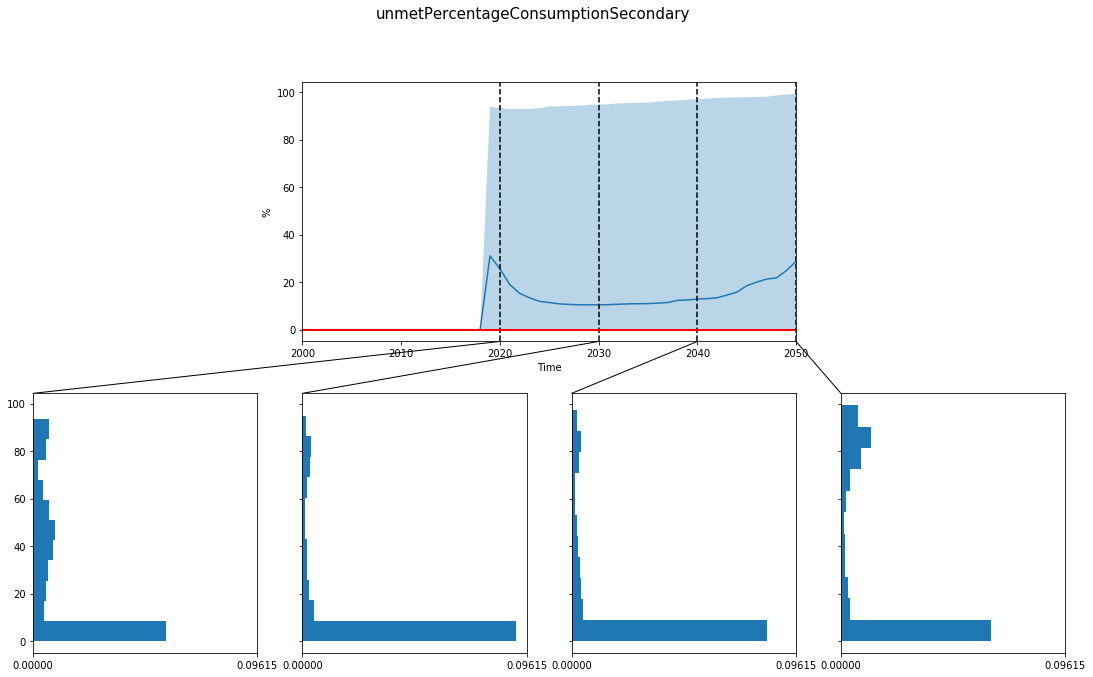

In [31]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.HIST,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "%"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a red wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'r-',linewidth=2 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_future_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

### Unmet Demand - Primary Unmet demand in MWh 

In [26]:
# Subset Sool levers
selected_uncertainties = uncertainties

ooi = 'primaryUnmetDemandMwh'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

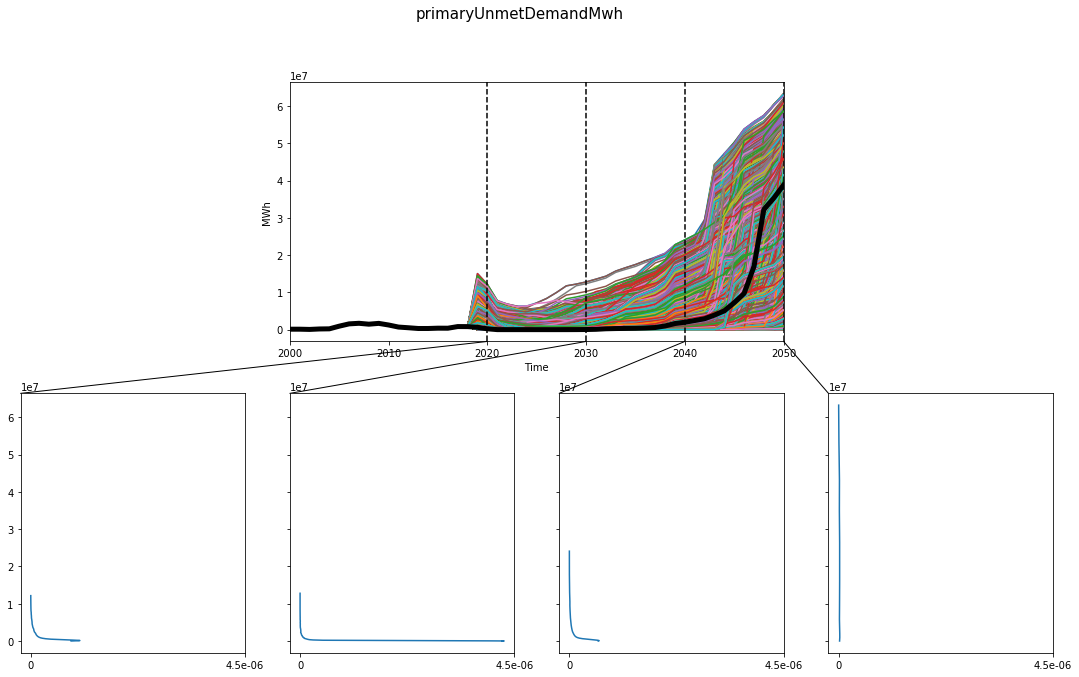

In [33]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a black wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'k-',linewidth=5 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_future_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [34]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.Hist,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a red wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'r-',linewidth=2 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_future_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

AttributeError: Hist

### Unmet Demand - Primary unmet demand (hours)

In [27]:
# Subset Sool levers
selected_uncertainties = uncertainties

ooi = 'primaryUnmetDemandHours'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

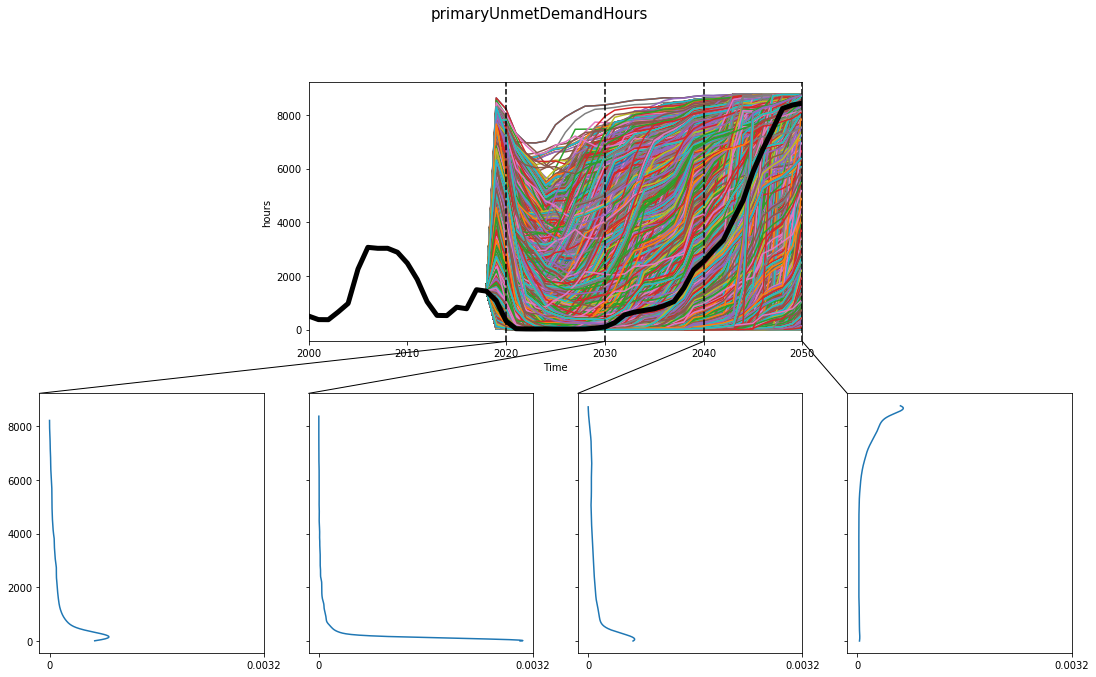

In [34]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "hours"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a black wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'k-',linewidth=5 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_future_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

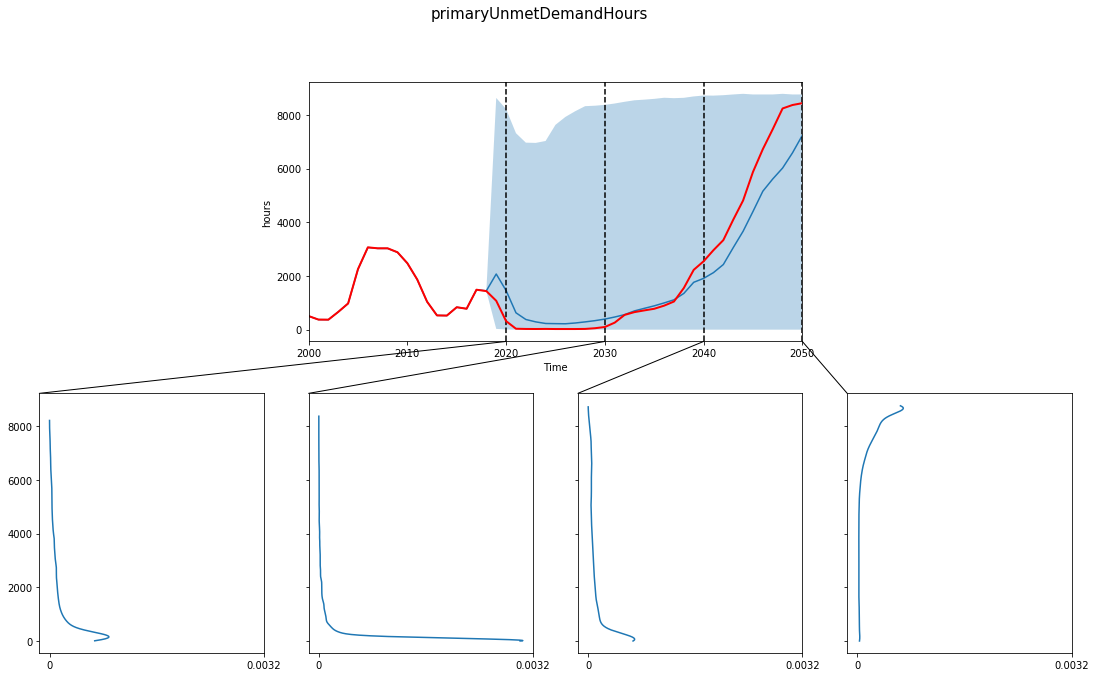

In [35]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "hours"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a red wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'r-',linewidth=2 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_future_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

### Unmet Demand - Primary unmet demand (days)

In [28]:
# Subset Sool levers
selected_uncertainties = uncertainties

ooi = 'primaryUnmetDemandDays'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

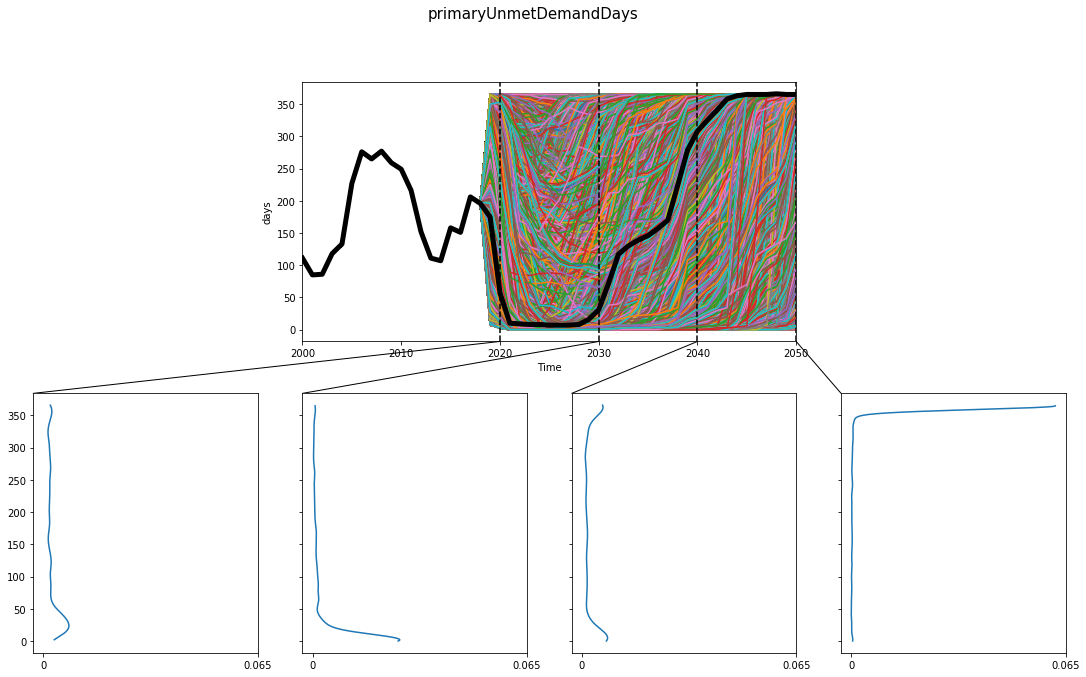

In [37]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "days"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a black wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'k-',linewidth=5 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_future_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

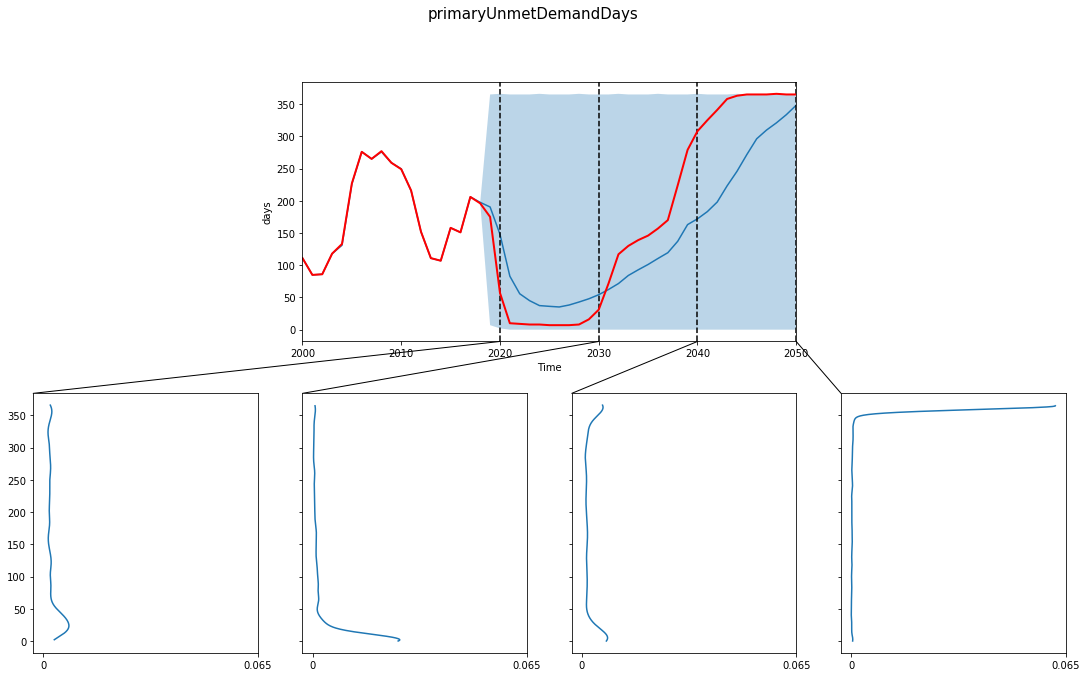

In [38]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "days"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a red wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'r-',linewidth=2 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_future_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

### Unmet Demand - Primary max unmet demand per hour

In [29]:
# Subset Sool levers
selected_uncertainties = uncertainties

ooi = 'primaryMaxUnmetDemandMwhPerHour'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

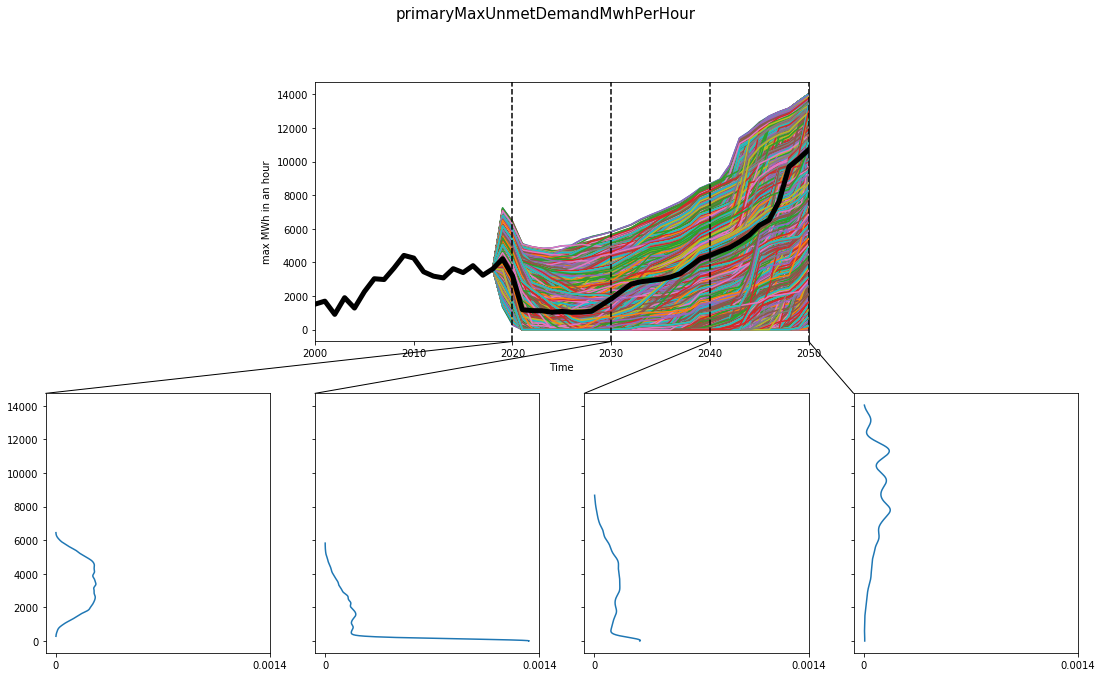

In [40]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "max MWh in an hour"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a black wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'k-',linewidth=5 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_future_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

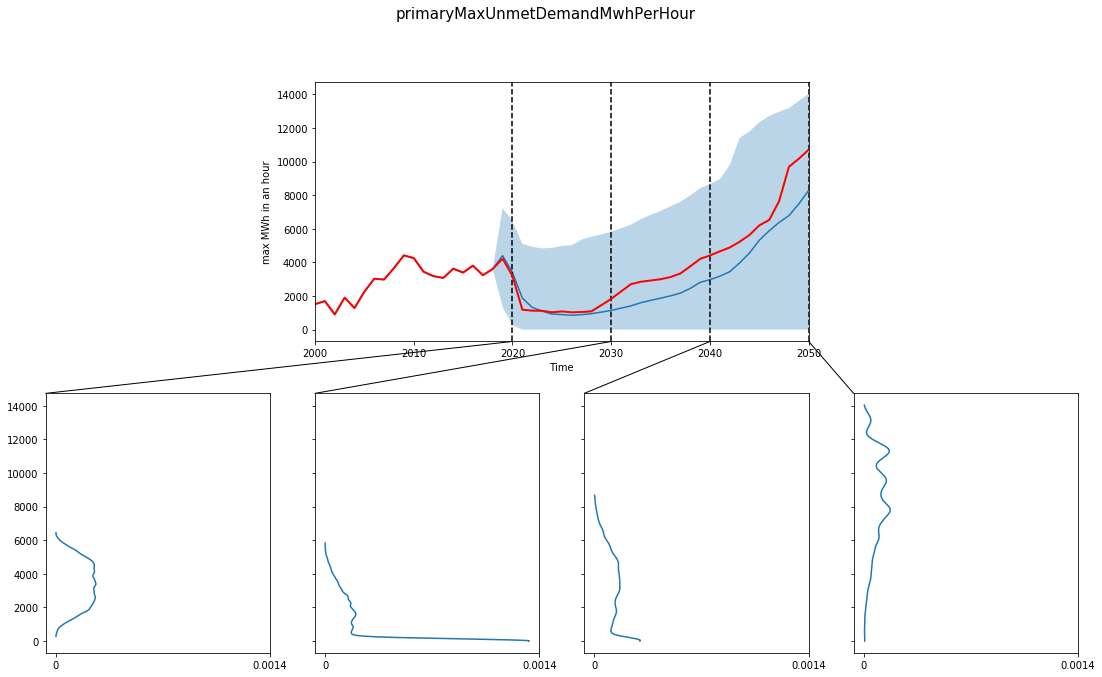

In [41]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "max MWh in an hour"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a red wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'r-',linewidth=2 )


fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_future_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

### Unmet Demand - Secondary market unmet demand MWh

In [30]:
# Subset Sool levers
selected_uncertainties = uncertainties

ooi = 'secondaryUnmetDemandMwh'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

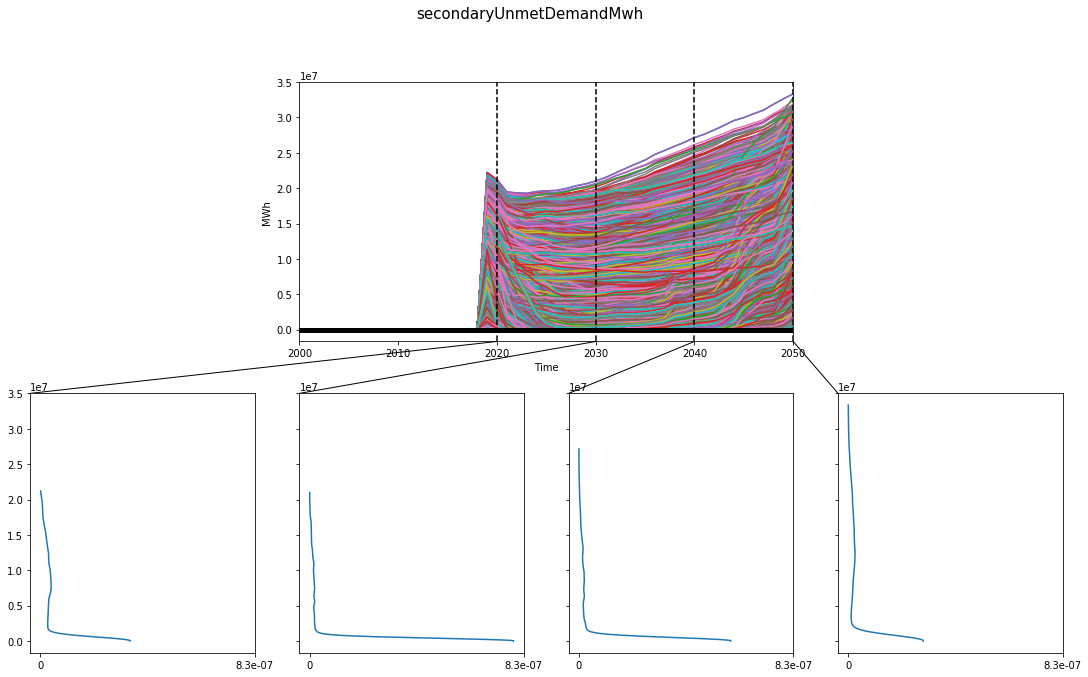

In [43]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a black wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'k-',linewidth=5 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_future_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

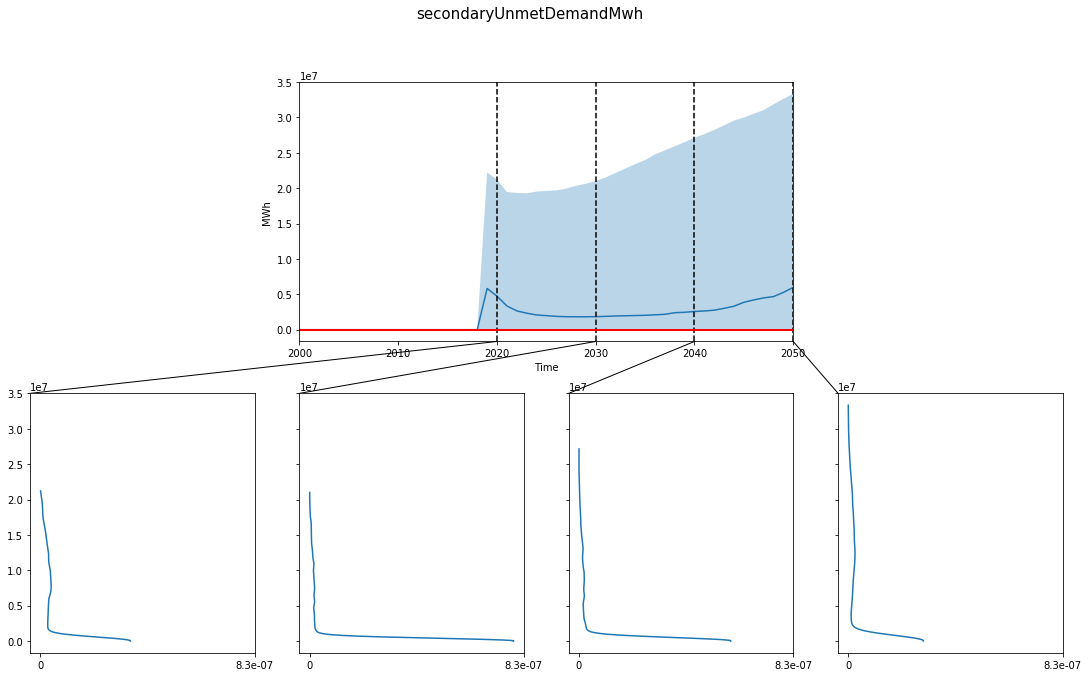

In [44]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a red wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'r-',linewidth=2 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_future_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

### Unmet Demand - Secondary market unmet demand (hours)

In [31]:
# Subset Sool levers
selected_uncertainties = uncertainties

ooi = 'secondaryUnmetDemandHours'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

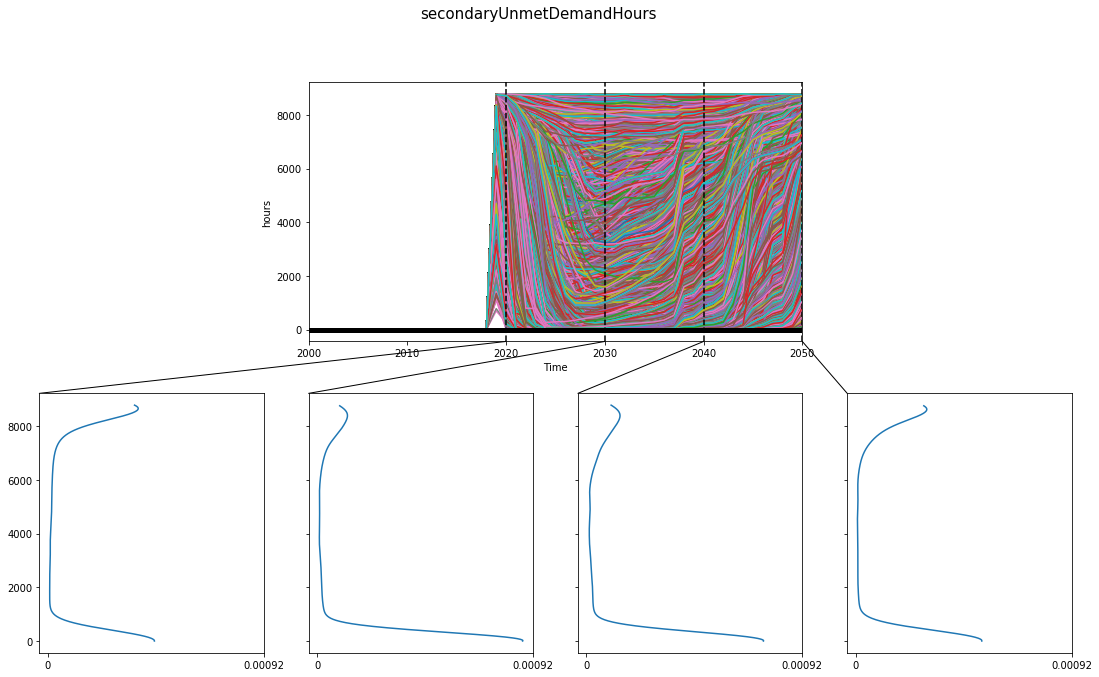

In [46]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "hours"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a black wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'k-',linewidth=5 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_future_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

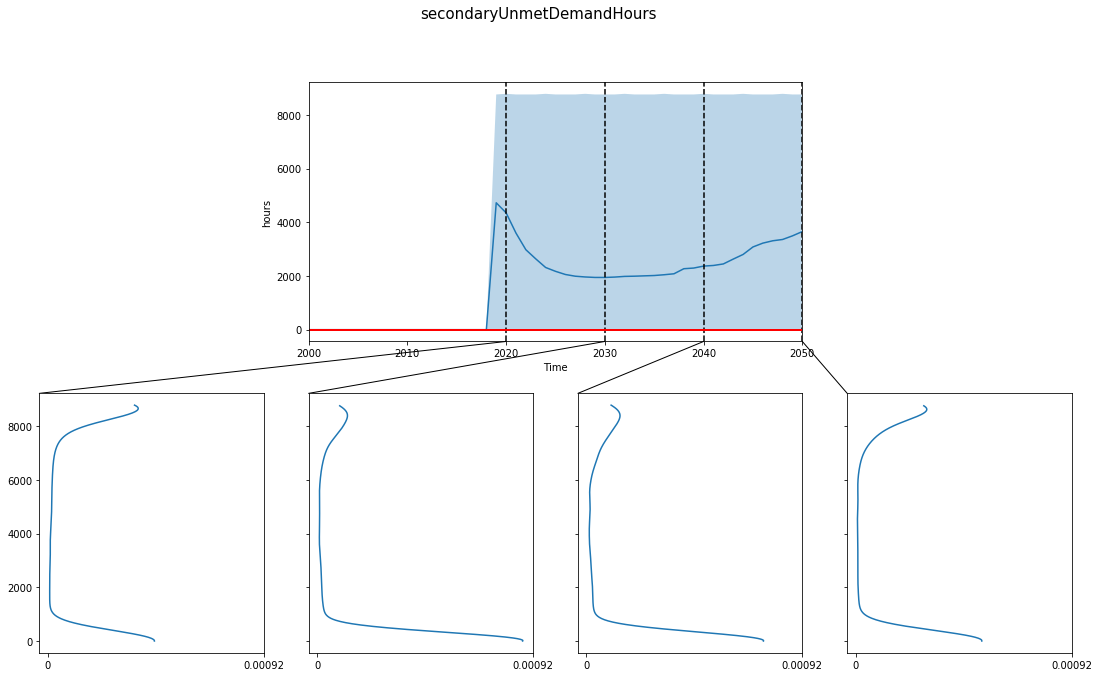

In [47]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "hours"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a red wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'r-',linewidth=2 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_future_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

### Unmet Demand - Secondary unmet demand (days)

In [32]:
# Subset Sool levers
selected_uncertainties = uncertainties

ooi = 'secondaryUnmetDemandDays'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

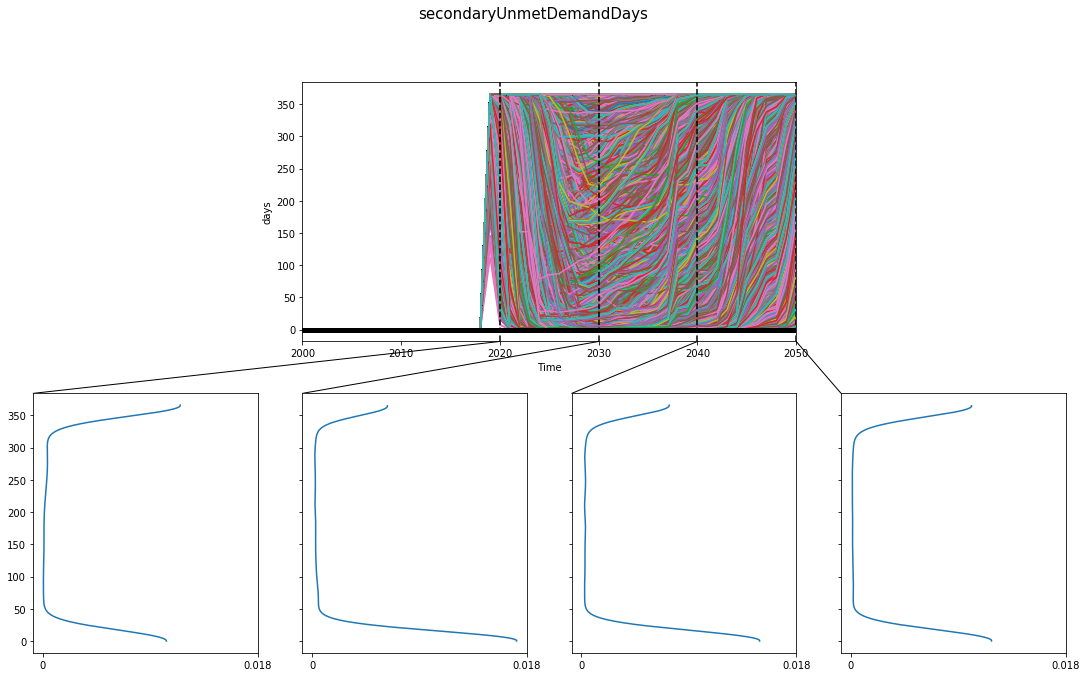

In [49]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "days"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a black wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'k-',linewidth=5 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_future_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

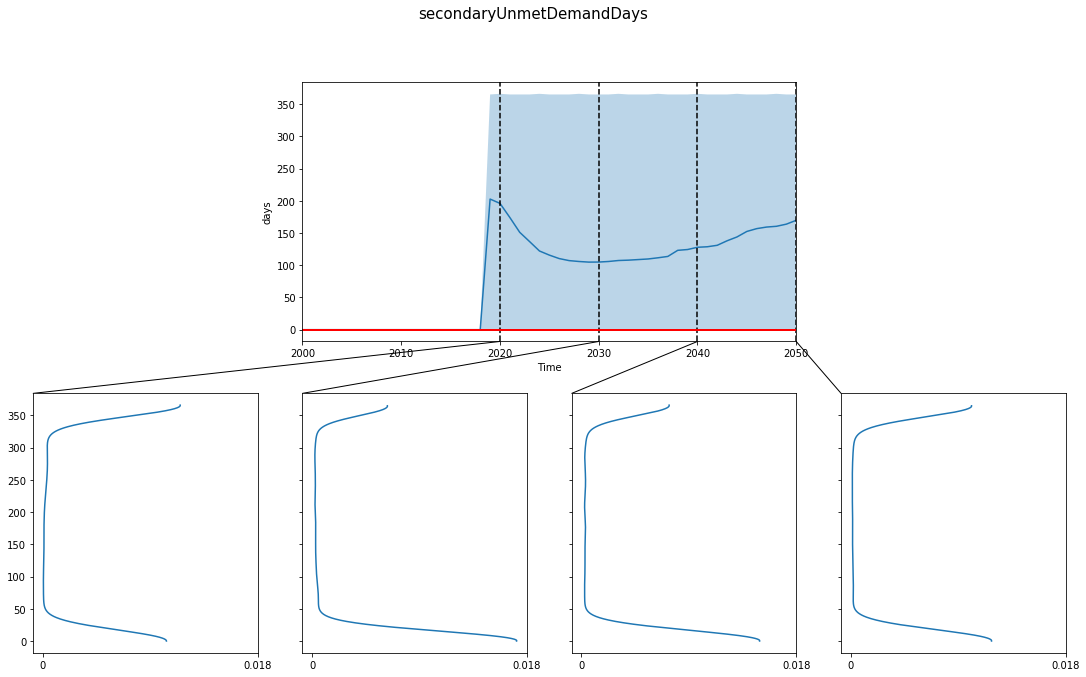

In [50]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "days"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a red wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'r-',linewidth=2 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_future_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

### Unmet Demand - Secondary market max unmet demand per hour

In [33]:
# Subset Sool levers
selected_uncertainties = uncertainties

ooi = 'secondaryMaxUnmetDemandMwhPerHour'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

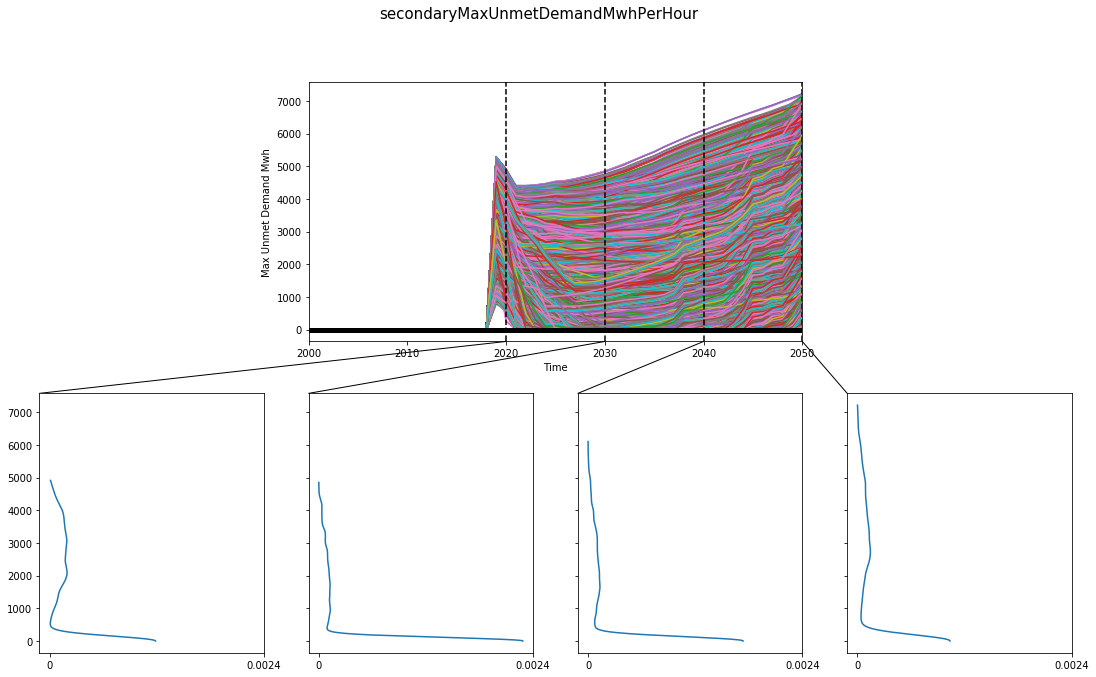

In [52]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "Max Unmet Demand Mwh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a black wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'k-',linewidth=5 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_future_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

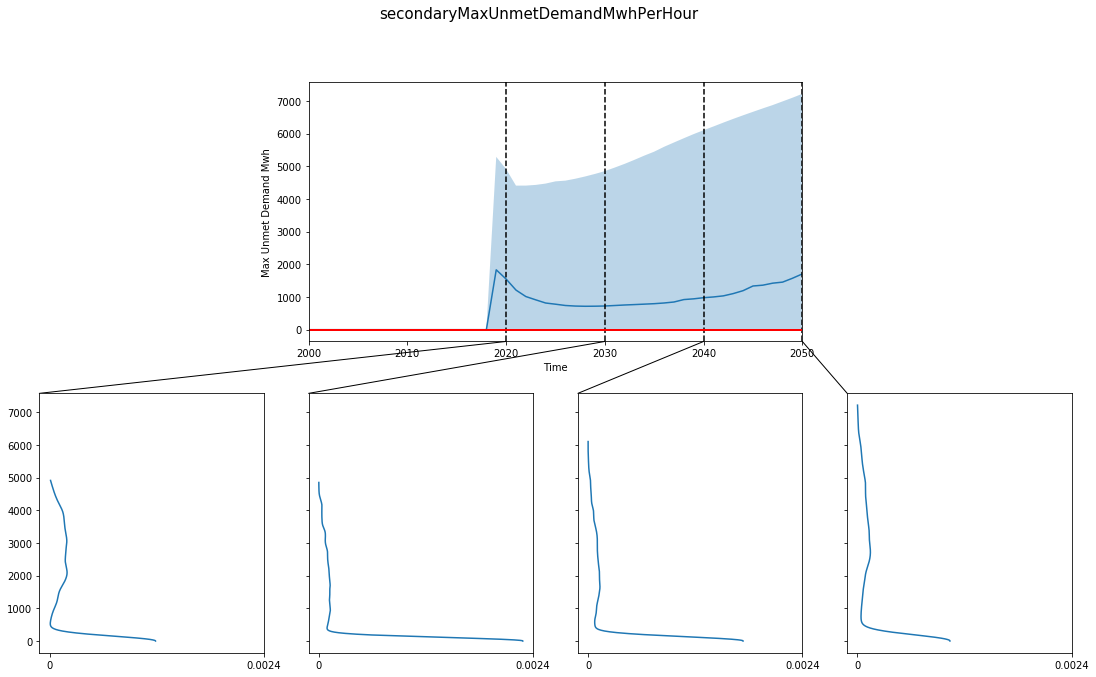

In [53]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "Max Unmet Demand Mwh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a red wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'r-',linewidth=2 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_future_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

## Directed Search: Prim - Low Carbon Transition (LCT)
* A low carbon transition is the objective. For this, trajectories that lead to low GHGE, high penetration of renewable energiesand a reasonable generation autonomy (in primary markets) are going to be explored. 

1. Victoria's Climate Change Act 2017: “These targets build on the progress that Victoria is already making; emissions are projected to fall to 18% below 2005 levels in 2020.”
The Panel recommends interim targets of:
• 32-39% below 2005 levels in 2025 
• 45-60% below 2005 levels in 2030
• Net-zero by 2050
Lower and upper bounds correspond to 2C and 1.5C emissions trajectories agreed at the COP in Paris in 2015.
2. Victoria Renewable Energy Targets:
* 25% of RE in 2025
* 40% of RE in 2040
* 50% of RE in 2050
3. The objective is to decarbonise the electricity system, for this the generation autonomy of Victoria can be compromised. Other states will be covering the lack of supply from the retirement of the most energy intensive power plants in the Victorian generation pool. With the current committed and proposed generation, the state must accept that its generation autonomy will be highly compromised by mid 2050. Targets in this scenario include:
* A maximum of 2% of the generation will be imported by 2030
* A maximum of 5% of the generation will be imported by 2040
* A maximum of 50% (in the 1.5 C scenario) and 40% (in the 2C scenario)  of the generation will be imported by 2050

### LCT consistent with Paris 2C

In [21]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);

selected_uncertainties = uncertainties

exp = pd.DataFrame(experiments)
exp = exp.loc[ :, selected_uncertainties] 
x = exp
"""
Paris trajectory to 2 C
Filter by GHG (below 32% value of 2005 by 2025)
Filter by GHG (below 45% value of 2005 by 2030)
Filter by net zero GHGE by 2050

"""    
ooi = 'GHGYear'

reference = bau_results_df[bau_results_df['Time (Year)'] == 2005]['GHGYear'].values

reduction = 0.32
ylc_e1 = target_at_year( outcomes_filtered, ooi, 2025, reference - (reference * reduction), False) #False is below target

reduction = 0.45
ylc_e2 = target_at_year( outcomes_filtered, ooi, 2030, reference - (reference * reduction), False) #False is below target

ylc_e3 = target_at_year( outcomes_filtered, ooi, 2050, 5, False) #False is below target

ylc_e = ylc_e1 &  ylc_e2 & ylc_e3 

"""
Filter by renewableContributionYear (above 50%)
The Victorian Renewable Energy Targets (VRET) https://www.energy.vic.gov.au/renewable-energy/victorias-renewable-energy-targets
25% of electricity generated from RE by 2020
40% by 2025
50% by 2030

"""

ooi = 'renewableContributionYear'    

ylc_re1 = target_at_year( outcomes_filtered, ooi, 2025, 0.40, True) #False is below target
ylc_re2 = target_at_year( outcomes_filtered, ooi, 2030, 0.50, True) #False is below target

ylc_re= ylc_re1 & ylc_re2

""""
Filter by GA of Primary Wholesale Market (aim for: below 2% in 2030, 5% in 2040, and 40% in 2050)
"""

ooi = 'unmetPercentageConsumptionPrimary'    

ylc_gap1 = target_at_year( outcomes_filtered, ooi, 2030, 1, False) #False is below target
ylc_gap2 = target_at_year( outcomes_filtered, ooi, 2040, 3, False) #False is below target
#ylc_gap3 = target_at_year( outcomes_filtered, ooi, 2050, 35, False) #False is below target

ylc_gap = ylc_gap1 & ylc_gap2 #& ylc_gap3

# """
# Combine Filters
# """
y = ylc_e & ylc_re & ylc_gap
# """

"""
Run PRIM
"""

#from .prim_util import PRIMObjectiveFunctions
from ema_workbench.analysis import prim_util
                       
prim_alg = prim.Prim(x, y, threshold=0.1, threshold_type=prim.ABOVE)
box1 = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 126001 points remaining, containing 31103 cases of interest
[MainProcess/INFO] mean: 0.8084817386054935, mass: 0.05258688423107753, coverage: 0.17223418962801015, density: 0.8084817386054935 restricted_dimensions: 12


In [22]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage    0.703276
density     0.571003
id                 7
mass        0.304029
mean        0.571003
res_dim            4
Name: 7, dtype: object

                               box 7                                      
                                 min   max                       qp values
generatorRetirement             -5.0   2.5                     [-1.0, 0.0]
includePublicallyAnnouncedGen    0.5   1.0                     [0.0, -1.0]
nameplateCapacityChangeWind    -38.5  50.0  [1.3043686042172142e-25, -1.0]
priceChangePercentageBrownCoal -45.5  50.0  [0.00040366370073453394, -1.0]



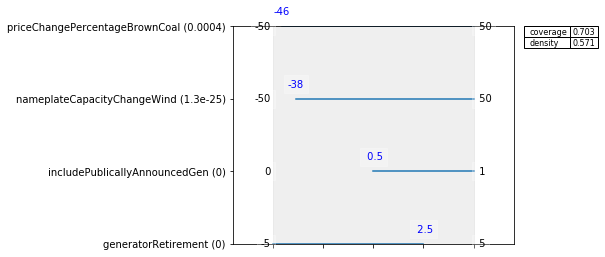

In [23]:
#%matplotlib inline
selected_box = 7

box_1 = box1.inspect(selected_box)
box_1 = box1.inspect(selected_box, style='graph')


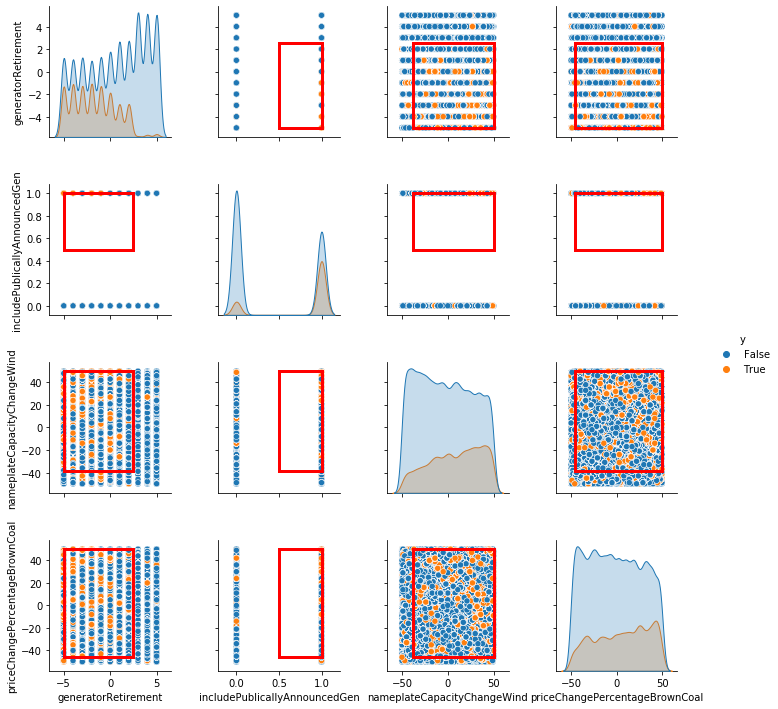

In [24]:
fig = box1.show_pairs_scatter(selected_box)

plt.show()

#### Feature scoring best LCT  2C

[MainProcess/INFO] model dropped from analysis because only a single category


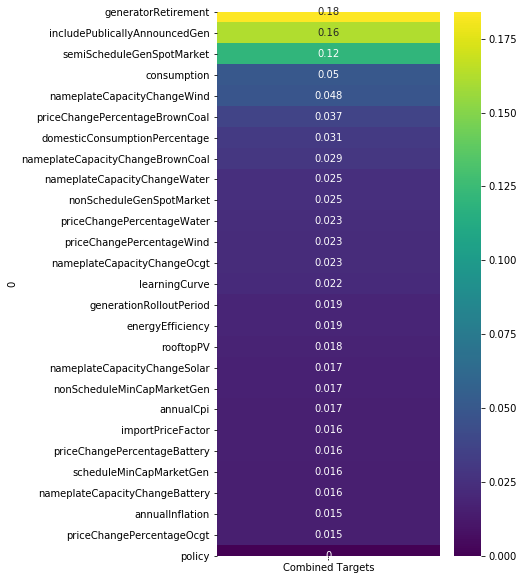

In [25]:
from EMAworkbench.ema_workbench.analysis import feature_scoring

x = exp
y_all = {}

#plot using ALL simulations
#y_all['GHGYear'] = data

#plot using average of ALL simulations
#y_all['GHGYear'] = out_avg_ooi

#Plot using only target simulations
y_all['Combined Targets'] = y

fig, ax = plt.subplots(figsize=(5,10))
fs = feature_scoring.get_feature_scores_all(x, y_all)
sns.heatmap(fs, cmap='viridis', annot=True, ax=ax)
plt.show()

In [26]:
#Complementary LCT 2C  worst-cases

# """
# Combine Filters
# """
y = ~ylc_e | ~ylc_re | ~ylc_gap
# """
"""
Run PRIM
"""
prim_alg = prim.Prim(x, y, threshold=0.1, threshold_type=prim.ABOVE)
box1 = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 126001 points remaining, containing 94898 cases of interest
[MainProcess/INFO] mean: 0.9997927461139896, mass: 0.07658669375639876, coverage: 0.1016670530464288, density: 0.9997927461139896 restricted_dimensions: 9


In [27]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage    0.376288
density     0.943784
id                 4
mass        0.300283
mean        0.943784
res_dim            3
Name: 4, dtype: object

                               box 4                                      
                                 min   max                       qp values
includePublicallyAnnouncedGen    0.0   0.5                     [-1.0, 0.0]
semiScheduleGenSpotMarket        8.0   9.5  [-1.0, 1.637677503627268e-143]
priceChangePercentageBrownCoal -50.0  39.5   [-1.0, 8.287069330561054e-13]



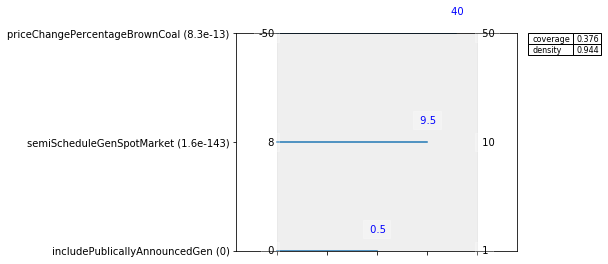

In [28]:
#%matplotlib inline
selected_box = 4

box_1 = box1.inspect(selected_box)
box_1 = box1.inspect(selected_box, style='graph')

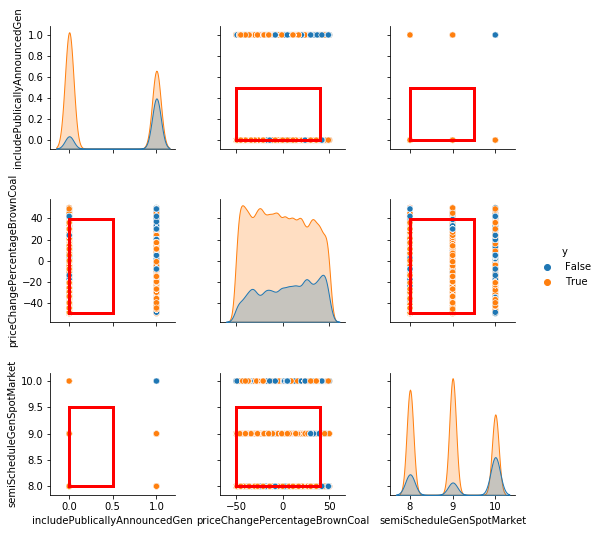

In [29]:
fig = box1.show_pairs_scatter(selected_box)

plt.show()

#### Feature scoring worst LCT  2C

In [30]:
from EMAworkbench.ema_workbench.analysis import feature_scoring

fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=feature_scoring.RuleInductionType.CLASSIFICATION)
fs.sort_values(ascending=False, by=1)


[MainProcess/INFO] model dropped from analysis because only a single category


1
0                                         
generatorRetirement               0.188821
includePublicallyAnnouncedGen     0.160362
semiScheduleGenSpotMarket         0.119799
consumption                       0.049009
nameplateCapacityChangeWind       0.047555
priceChangePercentageBrownCoal    0.035907
domesticConsumptionPercentage     0.030829
nameplateCapacityChangeBrownCoal  0.030437
nameplateCapacityChangeWater      0.024738
nonScheduleGenSpotMarket          0.024196
priceChangePercentageWind         0.023763
priceChangePercentageWater        0.022865
nameplateCapacityChangeOcgt       0.022797
learningCurve                     0.021524
energyEfficiency                  0.019064
generationRolloutPeriod           0.018334
rooftopPV                         0.017687
nameplateCapacityChangeSolar      0.017454
nonScheduleMinCapMarketGen        0.016875
annualCpi                         0.016100
importPriceFactor                 0.015644
priceChangePercentageBattery      0.015521
scheduleMinCapMarketGen           0.015440
nameplateCapacityChangeBattery    0.015228
annualInflation                   0.015121
priceChangePercentageOcgt         0.014931
policy                            0.000000

[MainProcess/INFO] model dropped from analysis because only a single category


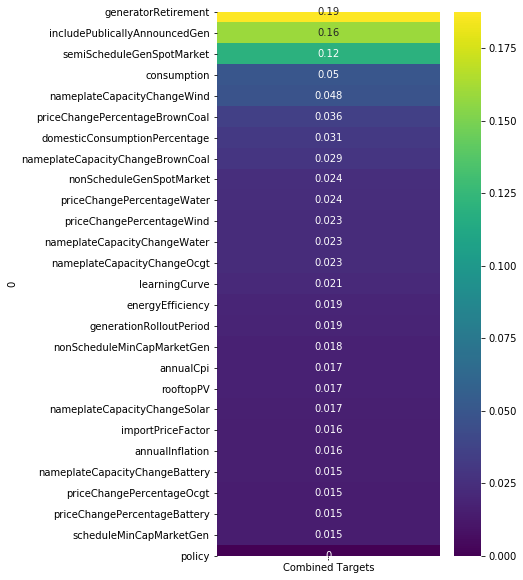

In [31]:
x = exp
y_all = {}

#plot using ALL simulations
#y_all['GHGYear'] = data

#plot using average of ALL simulations
#y_all['GHGYear'] = out_avg_ooi

#Plot using only target simulations
y_all['Combined Targets'] = y

fig, ax = plt.subplots(figsize=(5,10))
fs = feature_scoring.get_feature_scores_all(x, y_all)
sns.heatmap(fs, cmap='viridis', annot=True, ax=ax)
plt.show()

### Full-factorial with subset of dimensions

In [32]:
from ema_workbench import load_results

resultsLCTff = load_results(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/gr4sp_LCT2021-Aug-04.tar.gz')


[MainProcess/INFO] results loaded succesfully from C:\Users\angel\Documents\GitHub\gr4sp\experiments\simulationData\gr4sp_LCT2021-Aug-04.tar.gz


In [33]:
experimentsLCTff, outcomesLCTff = resultsLCTff
experimentsLCTff.describe()

consumption  generatorRetirement  includePublicallyAnnouncedGen  \
count  6480.000000          6480.000000                    6480.000000   
mean      2.000000             0.000000                       0.500000   
std       1.414323             3.415914                       0.500039   
min       0.000000            -5.000000                       0.000000   
25%       1.000000            -3.000000                       0.000000   
50%       2.000000             0.000000                       0.500000   
75%       3.000000             3.000000                       1.000000   
max       4.000000             5.000000                       1.000000   

       nameplateCapacityChangeWind  priceChangePercentageBrownCoal  \
count                  6480.000000                     6480.000000   
mean                      0.000000                        0.000000   
std                      34.159138                       34.159138   
min                     -50.000000                      -50.000000   
25%                     -30.000000                      -30.000000   
50%                       0.000000                        0.000000   
75%                      30.000000                       30.000000   
max                      50.000000                       50.000000   

       semiScheduleGenSpotMarket  
count                 6480.00000  
mean                     9.00000  
std                      0.81656  
min                      8.00000  
25%                      8.00000  
50%                      9.00000  
75%                     10.00000  
max                     10.00000

In [34]:
consumption = 0
generatorRetirement = -1
includePublicallyAnnouncedGen = 1
nameplateCapacityChangeWind = 30
priceChangePercentageBrownCoal = 30
semiScheduleGenSpotMarket = 8

q1 = experimentsLCTff['consumption'] == consumption
q2 = experimentsLCTff['generatorRetirement'] == generatorRetirement
q3 = experimentsLCTff['includePublicallyAnnouncedGen'] == includePublicallyAnnouncedGen
q4 = experimentsLCTff['nameplateCapacityChangeWind'] == nameplateCapacityChangeWind
q5 = experimentsLCTff['priceChangePercentageBrownCoal'] == priceChangePercentageBrownCoal
q6 = experimentsLCTff['semiScheduleGenSpotMarket'] == semiScheduleGenSpotMarket

print(np.unique(q1 & q2 & q3 & q4 & q5 & q6, return_counts=True))
experimentsLCTff[q1 & q2 & q3 & q4 & q5 & q6]

(array([False,  True]), array([6479,    1], dtype=int64))


consumption  generatorRetirement  includePublicallyAnnouncedGen  \
624          0.0                 -1.0                            1.0   

     nameplateCapacityChangeWind  priceChangePercentageBrownCoal  \
624                         30.0                            30.0   

     semiScheduleGenSpotMarket scenario policy  model  
624                        8.0      624   None  Gr4sp

In [35]:
# FF using the most influential factors for the LCT scenario
uncertaintiesLCTff = experimentsLCTff.columns[:-3]

#from startYear
startYear = 2000
startYearShift = (startYear - 1998)

time = outcomesLCTff['TIMEYear'][0, startYearShift:]


# Filter outcomes taking into account the startYear, and removing Seed Experiment info. 
# Seed it is useful if I want to retrieve more info from the csv files, or redo the experiments with the
# simulation parameters
outcomes_filteredLCTff = {k:v[:, startYearShift:] for k,v in outcomesLCTff.items() if k != 'seedExperimentCsv'}


In [36]:
ooi = 'GHGYear'
data_GHG_household = outcomes_filteredLCTff[ooi]

In [37]:
""" Converts household data in tCO2e into total residential data in MtCO2e"""
data_GHG_residential = (data_GHG_household * outcomes_filteredLCTff['numConsumersYear']) / 1000000.0

""" Applies scaling factor used in simulation, so that data represents total emissions, not only residential (30%)"""
data_GHG_total = data_GHG_residential / 0.3


"""Overwrite GHG with the data of interest"""
outcomes_filteredLCTff[ooi] = data_GHG_total


In [38]:
ooi = 'consumptionYear'
data_consumption_household = outcomes_filteredLCTff[ooi]

In [39]:
""" Converts household data in KWh into total residential data in MWh"""
data_consumption_residential = (data_consumption_household * outcomes_filteredLCTff['numConsumersYear']) / 1000.0

""" Applies scaling factor used in simulation, so that data represents total consumption, not only residential"""
data_consumption_total = data_consumption_residential / 0.3

"""Overwrite Consumption with the data of interest"""
outcomes_filteredLCTff[ooi] = data_consumption_total

Create Percentage of Unmet Consumption

In [40]:
primary = outcomes_filteredLCTff['primarySpotProductionYear']
secondary = outcomes_filteredLCTff['secondarySpotProductionYear']
off = outcomes_filteredLCTff['offSpotProductionYear']
unmetPrimary = outcomes_filteredLCTff['primaryUnmetDemandMwh']
unmetSecondary = outcomes_filteredLCTff['secondaryUnmetDemandMwh']

consumptionPrimary = primary + off + unmetPrimary
consumptionSecondary = secondary + off + unmetSecondary

percentageUnmetPrimary = (unmetPrimary/consumptionPrimary)*100
percentageUnmetSecondary = np.divide(unmetSecondary, consumptionSecondary, 
                                     out=np.zeros_like(unmetSecondary), where=consumptionSecondary!=0) *100

where_are_NaNs = np.isnan(percentageUnmetPrimary)
percentageUnmetPrimary[where_are_NaNs] = 0

where_are_NaNs = np.isnan(percentageUnmetSecondary)
percentageUnmetSecondary[where_are_NaNs] = 0

outcomes_filteredLCTff['unmetPercentageConsumptionPrimary'] = percentageUnmetPrimary
outcomes_filteredLCTff['unmetPercentageConsumptionSecondary'] = percentageUnmetSecondary

In [41]:
#Complementary worst-cases

expLCTff = pd.DataFrame(experimentsLCTff)

expLCTff = expLCTff.loc[ :, uncertaintiesLCTff] 

from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);

xLCTff = expLCTff
"""
Paris trajectory to 2 C
Filter by GHG (below 32% value of 2005 by 2025)
Filter by GHG (below 45% value of 2005 by 2030)
Filter by net zero GHGE by 2050

"""    
ooi = 'GHGYear'

reference = bau_results_df[bau_results_df['Time (Year)'] == 2005]['GHGYear'].values

reduction = 0.32
ylc_e1 = target_at_year( outcomes_filteredLCTff, ooi, 2025, reference - (reference * reduction), False) #False is below target

reduction = 0.45
ylc_e2 = target_at_year( outcomes_filteredLCTff, ooi, 2030, reference - (reference * reduction), False) #False is below target

ylc_e3 = target_at_year( outcomes_filteredLCTff, ooi, 2050, 5, False) #False is below target

ylc_e = ylc_e1 &  ylc_e2 & ylc_e3 

"""
Filter by renewableContributionYear (above 50%)
The Victorian Renewable Energy Targets (VRET) https://www.energy.vic.gov.au/renewable-energy/victorias-renewable-energy-targets
25% of electricity generated from RE by 2020
40% by 2025
50% by 2030

"""

ooi = 'renewableContributionYear'    

ylc_re1 = target_at_year( outcomes_filteredLCTff, ooi, 2025, 0.40, True) #False is below target
ylc_re2 = target_at_year( outcomes_filteredLCTff, ooi, 2030, 0.50, True) #False is below target

ylc_re= ylc_re1 & ylc_re2

""""
Filter by GA of Primary Wholesale Market (aim for: below 2% in 2030, 5% in 2040, and 40% in 2050)
"""

ooi = 'unmetPercentageConsumptionPrimary'    

ylc_gap1 = target_at_year( outcomes_filteredLCTff, ooi, 2030, 1, False) #False is below target
ylc_gap2 = target_at_year( outcomes_filteredLCTff, ooi, 2040, 3, False) #False is below target
#ylc_gap3 = target_at_year( outcomes_filtered, ooi, 2050, 35, False) #False is below target

ylc_gap = ylc_gap1 & ylc_gap2 #& ylc_gap3

# """
# Combine Filters
# """
#y = ~ylc_e | ~ylc_re | ~ylc_gap
y = ylc_e & ylc_re & ylc_gap

# """
"""
Run PRIM
"""
prim_alg = prim.Prim(xLCTff, y, threshold=0.1, threshold_type=prim.ABOVE)
box1 = prim_alg.find_box()

[MainProcess/INFO] 6480 points remaining, containing 1173 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.06944444444444445, coverage: 0.3836317135549872, density: 1.0 restricted_dimensions: 4


In [42]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage     0.383632
density             1
id                  7
mass        0.0694444
mean                1
res_dim             4
Name: 7, dtype: object

                              box 7                                       
                                min   max                        qp values
generatorRetirement            -5.0   0.0    [-1.0, 6.386121086206671e-83]
semiScheduleGenSpotMarket       9.5  10.0  [1.1299297187679803e-149, -1.0]
includePublicallyAnnouncedGen   0.5   1.0    [1.401434466113613e-68, -1.0]
nameplateCapacityChangeWind   -40.0  50.0   [2.3688329244088715e-07, -1.0]



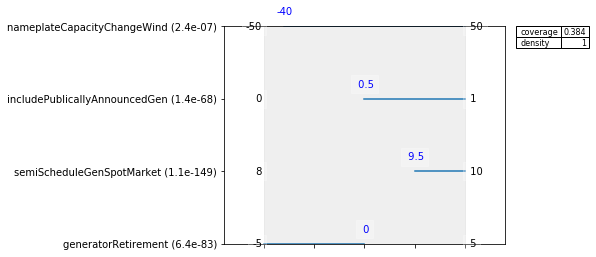

In [43]:
#%matplotlib inline
selected_box = 7

box_1 = box1.inspect(selected_box)
box_1 = box1.inspect(selected_box, style='graph')


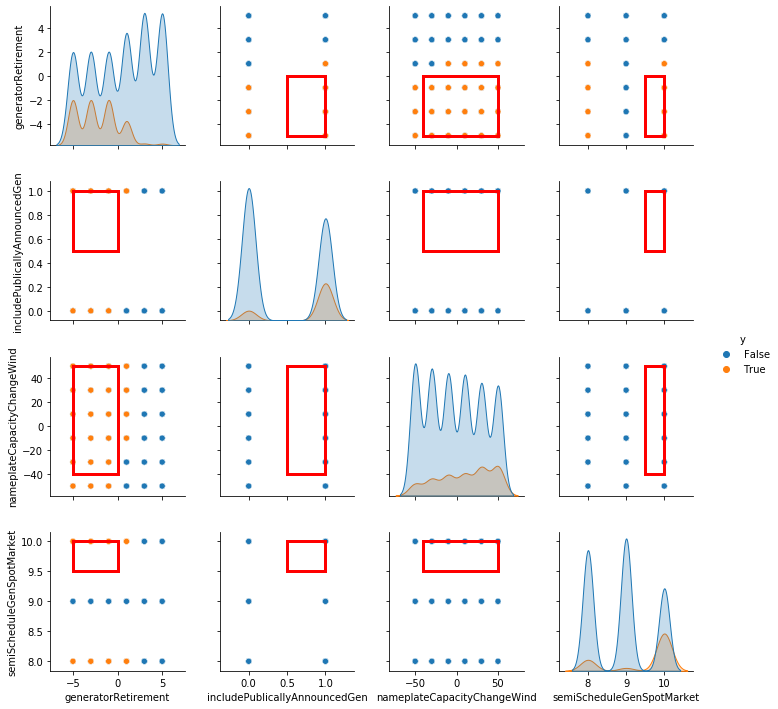

In [44]:
fig = box1.show_pairs_scatter(7)

plt.show()

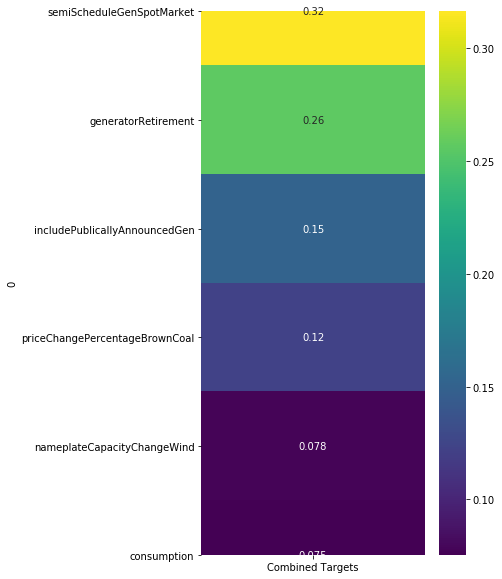

In [45]:
xLCTff = expLCTff
y_all = {}

#plot using ALL simulations
#y_all['GHGYear'] = data

#plot using average of ALL simulations
#y_all['GHGYear'] = out_avg_ooi

#Plot using only target simulations
y_all['Combined Targets'] = y

fig, ax = plt.subplots(figsize=(5,10))
fs = feature_scoring.get_feature_scores_all(xLCTff, y_all)
sns.heatmap(fs, cmap='viridis', annot=True, ax=ax)
plt.show()

In [46]:
y = ~ylc_e | ~ylc_re | ylc_gap

# """
"""
Run PRIM
"""
prim_alg = prim.Prim(xLCTff, y, threshold=0.1, threshold_type=prim.ABOVE)
box1 = prim_alg.find_box()

[MainProcess/INFO] 6480 points remaining, containing 6444 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.6666666666666666, coverage: 0.6703910614525139, density: 1.0 restricted_dimensions: 1


In [47]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage    0.670391
density            1
id                 1
mass        0.666667
mean               1
res_dim            1
Name: 1, dtype: object

                          box 1                                    
                            min  max                      qp values
semiScheduleGenSpotMarket   8.0  9.5  [-1.0, 3.530789178555206e-11]



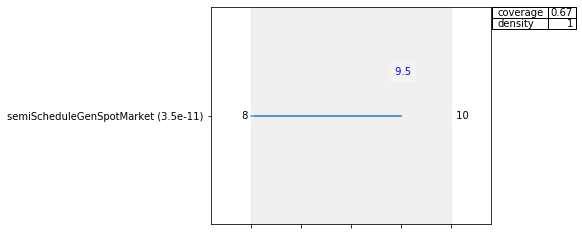

In [48]:
#%matplotlib inline
selected_box = 1

box_1 = box1.inspect(selected_box)
box_1 = box1.inspect(selected_box, style='graph')


### BAU VS 2C LCT

In [49]:
#box4Best = pd.read_csv(r'C:/Users/angel/Documents/GitHub/gr4sp/csv/LCTVIC/LCTVICSimDataYearSummary_seed_1627813932504.csv')
box4Best = pd.read_csv(r'C:/Users/angel/Documents/GitHub/gr4sp/csv/LCTVIC/LCTVICSimDataYearSummary_seed_1627638141723.csv')

box2Worst = pd.read_csv(r'C:/Users/angel/Documents/GitHub/gr4sp/csv/LCTVIC/LCTVICSimDataYearSummary_seed_1627640380484.csv')
box3_1Worst = pd.read_csv(r'C:/Users/angel/Documents/GitHub/gr4sp/csv/LCTVIC/LCTVICSimDataYearSummary_seed_1627807388047.csv')
box5Best = pd.read_csv(r'C:/Users/angel/Documents/GitHub/gr4sp/csv/LCTVIC/LCTVICSimDataYearSummary_seed_1627806178339.csv')
box3W5B = pd.read_csv(r'C:/Users/angel/Documents/GitHub/gr4sp/csv/LCTVIC/LCTVICSimDataYearSummary_seed_1627811773202.csv')

""" Converts household data in tCO2e into total residential data in MtCO2e"""
box4data_GHG_residential_lct = (box4Best['GHG Emissions (tCO2-e) per household'] * box4Best['Number of Domestic Consumers (households)']) / 1000000.0

""" Applies scaling factor used in simulation, so that data represents total emissions, not only residential (30%)"""
box4data_GHG_total_lct = box4data_GHG_residential_lct / 0.3

"""Overwrite GHG with the data of interest"""
box4Best['GHGYear'] = box4data_GHG_total_lct


""" Converts household data in tCO2e into total residential data in MtCO2e"""
box2Worstdata_GHG_residential_lct = (box2Worst['GHG Emissions (tCO2-e) per household'] * box2Worst['Number of Domestic Consumers (households)']) / 1000000.0

""" Applies scaling factor used in simulation, so that data represents total emissions, not only residential (30%)"""
box2data_GHG_total_lct = box2Worstdata_GHG_residential_lct / 0.3

"""Overwrite GHG with the data of interest"""
box2Worst['GHGYear'] = box2data_GHG_total_lct


""" Converts household data in tCO2e into total residential data in MtCO2e"""
box3data_GHG_residential_lct = (box3_1Worst['GHG Emissions (tCO2-e) per household'] * box3_1Worst['Number of Domestic Consumers (households)']) / 1000000.0

""" Applies scaling factor used in simulation, so that data represents total emissions, not only residential (30%)"""
box3data_GHG_total_lct = box3data_GHG_residential_lct / 0.3

"""Overwrite GHG with the data of interest"""
box3_1Worst['GHGYear'] = box3data_GHG_total_lct


""" Converts household data in tCO2e into total residential data in MtCO2e"""
box5Bestdata_GHG_residential_lct = (box5Best['GHG Emissions (tCO2-e) per household'] * box5Best['Number of Domestic Consumers (households)']) / 1000000.0

""" Applies scaling factor used in simulation, so that data represents total emissions, not only residential (30%)"""
box5Bestdata_GHG_total_lct = box5Bestdata_GHG_residential_lct / 0.3

"""Overwrite GHG with the data of interest"""
box5Best['GHGYear'] = box5Bestdata_GHG_total_lct


""" Converts household data in tCO2e into total residential data in MtCO2e"""
box3W5Bdata_GHG_residential_lct = (box3W5B['GHG Emissions (tCO2-e) per household'] * box3W5B['Number of Domestic Consumers (households)']) / 1000000.0

""" Applies scaling factor used in simulation, so that data represents total emissions, not only residential (30%)"""
box3W5Bdata_GHG_total_lct = box3W5Bdata_GHG_residential_lct / 0.3

"""Overwrite GHG with the data of interest"""
box3W5B['GHGYear'] = box3W5Bdata_GHG_total_lct

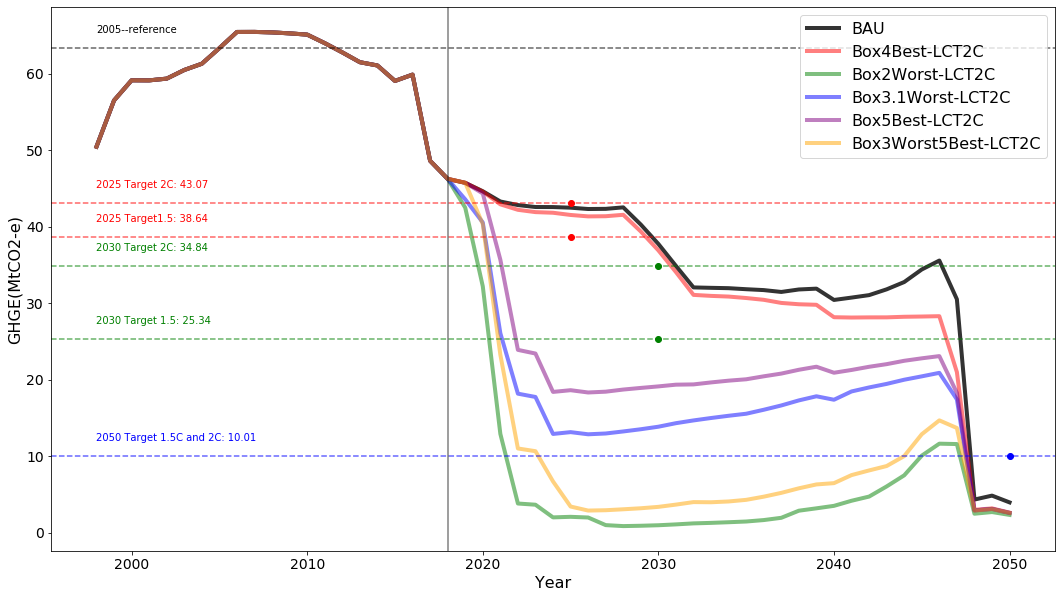

In [50]:
plt.figure(figsize=(18,10))
years = [DT.datetime.strptime(str(int(date)),'%Y') for date in bau_results_df['Time (Year)'].values]
years =  bau_results_df['Time (Year)'].values
plt.plot( years, bau_results_df['GHGYear'], color='black', alpha = 0.8, linewidth=4, label='BAU')
plt.plot( years, box4Best['GHGYear'],  color='red', alpha = 0.5, linewidth=4, label='Box4Best-LCT2C')
plt.plot( years, box2Worst['GHGYear'],  color='green',  alpha = 0.5, linewidth=4, label='Box2Worst-LCT2C')
plt.plot( years, box3_1Worst['GHGYear'],  color='blue', alpha = 0.5, linewidth=4, label='Box3.1Worst-LCT2C')
plt.plot( years, box5Best['GHGYear'],  color='purple',  alpha = 0.5, linewidth=4, label='Box5Best-LCT2C')
plt.plot( years, box3W5B['GHGYear'],  color='orange',  alpha = 0.5, linewidth=4, label='Box3Worst5Best-LCT2C')


# Add dot and corresponding text
reference = bau_results_df[bau_results_df['Time (Year)'] == 2005]['GHGYear'].values

reduction = 0.32

plt.axhline((reference - (reference * reduction)), ls='--',color='red', alpha = 0.6)

plt.text(years[0], reference - (reference * reduction)+2, f'2025 Target 2C: {((reference - (reference * reduction))[0]):.2f}',color='red')
plt.plot(2025, (reference - (reference * reduction)), 'ro')

reduction = 0.39

plt.axhline((reference - (reference * reduction)), ls='--',color='red', alpha = 0.6)

plt.text(years[0], reference - (reference * reduction)+2, f'2025 Target1.5: {((reference - (reference * reduction))[0]):.2f}',color='red')
plt.plot(2025, (reference - (reference * reduction)), 'ro')

reduction = 0.45

plt.axhline((reference - (reference * reduction)) ,ls='--',color='green', alpha = 0.6)
plt.text(years[0], reference - (reference * reduction)+2, f'2030 Target 2C: {((reference - (reference * reduction))[0]):.2f}',color='green')
plt.plot(2030, (reference - (reference * reduction)), 'go')

reduction = 0.60

plt.axhline((reference - (reference * reduction)) ,ls='--',color='green', alpha = 0.6)
plt.text(years[0], reference - (reference * reduction)+2, f'2030 Target 1.5: {((reference - (reference * reduction))[0]):.2f}',color='green')
plt.plot(2030, (reference - (reference * reduction)), 'go')

reduction = 0.842

plt.axhline((reference - (reference * reduction)) ,ls='--',color='blue', alpha = 0.6)
plt.text(years[0], reference - (reference * reduction)+2, f'2050 Target 1.5C and 2C: {((reference - (reference * reduction))[0]):.2f}',color='blue')
plt.plot(2050, (reference - (reference * reduction)), 'bo')

plt.axvline(2018, ls='-',color='black', alpha = 0.5)

plt.axhline((reference),ls='--',color='black', alpha = 0.6)
plt.text(years[0], reference+2, f'2005--reference',color='black')


#plt.grid( linestyle='-', linewidth=1)
plt.xlabel('Year', size=16)
plt.ylabel('GHGE(MtCO2-e)', size=16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(prop={'size':16})

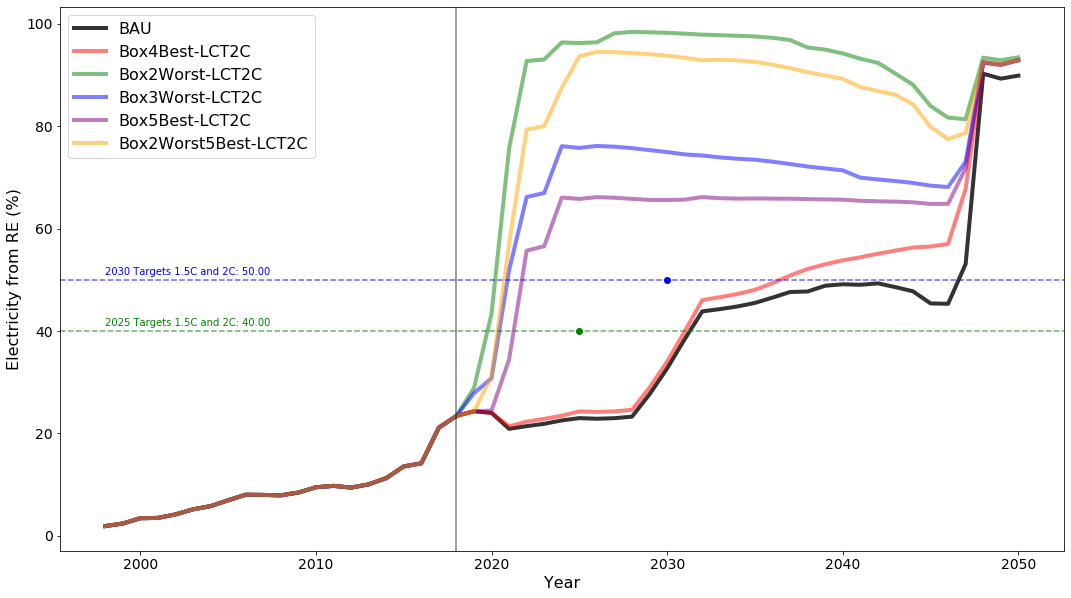

In [51]:
plt.figure(figsize=(18,10))
years = [DT.datetime.strptime(str(int(date)),'%Y') for date in bau_results_df['Time (Year)'].values]
years =  bau_results_df['Time (Year)'].values
plt.plot( years, bau_results_df['Percentage Renewable Production']*100, color='black', alpha = 0.8, linewidth=4, label='BAU')
plt.plot( years, box4Best['Percentage Renewable Production']*100,  color='red', alpha = 0.5, linewidth=4, label='Box4Best-LCT2C')
plt.plot( years, box2Worst['Percentage Renewable Production']*100, color='green',  alpha = 0.5, linewidth=4, label='Box2Worst-LCT2C')
plt.plot( years, box3_1Worst['Percentage Renewable Production']*100,  color='blue', alpha = 0.5, linewidth=4, label='Box3Worst-LCT2C')
plt.plot( years, box5Best['Percentage Renewable Production']*100, color='purple', alpha = 0.5, linewidth=4, label='Box5Best-LCT2C')
plt.plot( years, box3W5B['Percentage Renewable Production']*100, color='orange', alpha = 0.5, linewidth=4, label='Box2Worst5Best-LCT2C')

# Add dot and corresponding text

target = 40

plt.axhline(  target ,ls='--',color='green', alpha = 0.6)
plt.text(years[0], target+1, f'2025 Targets 1.5C and 2C: {target:.2f}',color='green')
plt.plot(2025, target, 'go')

target = 50
plt.axhline(  target ,ls='--',color='blue', alpha = 0.6)
plt.text(years[0], target+1, f'2030 Targets 1.5C and 2C: {target:.2f}',color='blue')
plt.plot(2030, target, 'bo')
plt.axvline(2018, ls='-',color='black', alpha = 0.5)

#plt.grid( linestyle='-', linewidth=1)
plt.xlabel('Year', size=16)
plt.ylabel('Electricity from RE (%)', size=16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(prop={'size':16})

In [52]:
#Box 4 best-cases PRIM
box4BestLCTprimary = box4Best['System Production Primary Spot']
box4BestLCTunmetPrimary = box4Best['Primary Total Unmet Demand (MWh)']
box4BestLCToff = box4Best['System Production Off Spot']

box4BestLCTconsumptionPrimary = box4BestLCTprimary + box4BestLCToff + box4BestLCTunmetPrimary
box4BestLCTpercentageUnmetPrimary = (box4BestLCTunmetPrimary/box4BestLCTconsumptionPrimary)*100
box4BestLCTwhere_are_NaNs = np.isnan(box4BestLCTpercentageUnmetPrimary)
box4BestLCTpercentageUnmetPrimary[box4BestLCTwhere_are_NaNs] = 0
box4Best['unmetPercentageConsumptionPrimary'] = box4BestLCTpercentageUnmetPrimary

#Box 2 worst-cases PRIM
box2WorstLCTprimary = box2Worst['System Production Primary Spot']
box2WorstLCTunmetPrimary = box2Worst['Primary Total Unmet Demand (MWh)']
box2WorstLCToff = box2Worst['System Production Off Spot']

box2WorstLCTconsumptionPrimary = box2WorstLCTprimary + box2WorstLCToff + box2WorstLCTunmetPrimary
box2WorstLCTpercentageUnmetPrimary = (box2WorstLCTunmetPrimary/box2WorstLCTconsumptionPrimary)*100
box2WorstLCTwhere_are_NaNs = np.isnan(box2WorstLCTpercentageUnmetPrimary)
box2WorstLCTpercentageUnmetPrimary[box2WorstLCTwhere_are_NaNs] = 0
box2Worst['unmetPercentageConsumptionPrimary'] = box2WorstLCTpercentageUnmetPrimary

#Box 3 worst-case PRIM, one experiment
box3_1WorstLCTprimary = box3_1Worst['System Production Primary Spot']
box3_1WorstLCTunmetPrimary = box3_1Worst['Primary Total Unmet Demand (MWh)']
box3_1WorstLCToff = box3_1Worst['System Production Off Spot']

box3_1WorstLCTconsumptionPrimary = box3_1WorstLCTprimary + box3_1WorstLCToff + box3_1WorstLCTunmetPrimary
box3_1WorstLCTpercentageUnmetPrimary = (box3_1WorstLCTunmetPrimary/box3_1WorstLCTconsumptionPrimary)*100
box3_1WorstLCTwhere_are_NaNs = np.isnan(box3_1WorstLCTpercentageUnmetPrimary)
box3_1WorstLCTpercentageUnmetPrimary[box3_1WorstLCTwhere_are_NaNs] = 0
box3_1Worst['unmetPercentageConsumptionPrimary'] = box3_1WorstLCTpercentageUnmetPrimary

#Box 5 best-case PRIM, another experiment
box5BestLCTprimary = box5Best['System Production Primary Spot']
box5BestLCTunmetPrimary = box5Best['Primary Total Unmet Demand (MWh)']
box5BestLCToff = box5Best['System Production Off Spot']

box5BestLCTconsumptionPrimary =box5BestLCTprimary + box5BestLCToff + box5BestLCTunmetPrimary
box5BestLCTpercentageUnmetPrimary = (box5BestLCTunmetPrimary/box5BestLCTconsumptionPrimary)*100
box5BestLCTwhere_are_NaNs = np.isnan(box5BestLCTpercentageUnmetPrimary)
box5BestLCTpercentageUnmetPrimary[box5BestLCTwhere_are_NaNs] = 0
box5Best['unmetPercentageConsumptionPrimary'] = box5BestLCTpercentageUnmetPrimary

#Box 3 worst-case and 5 best-case PRIM, another experiment
box3W5BLCTprimary = box3W5B['System Production Primary Spot']
box3W5BLCTunmetPrimary = box3W5B['Primary Total Unmet Demand (MWh)']
box3W5BLCToff = box3W5B['System Production Off Spot']

box3W5BLCTconsumptionPrimary =box3W5BLCTprimary + box3W5BLCToff + box3W5BLCTunmetPrimary
box3W5BLCTpercentageUnmetPrimary = (box3W5BLCTunmetPrimary/box3W5BLCTconsumptionPrimary)*100
box3W5BLCTwhere_are_NaNs = np.isnan(box3W5BLCTpercentageUnmetPrimary)
box3W5BLCTpercentageUnmetPrimary[box3W5BLCTwhere_are_NaNs] = 0
box3W5B['unmetPercentageConsumptionPrimary'] = box3W5BLCTpercentageUnmetPrimary


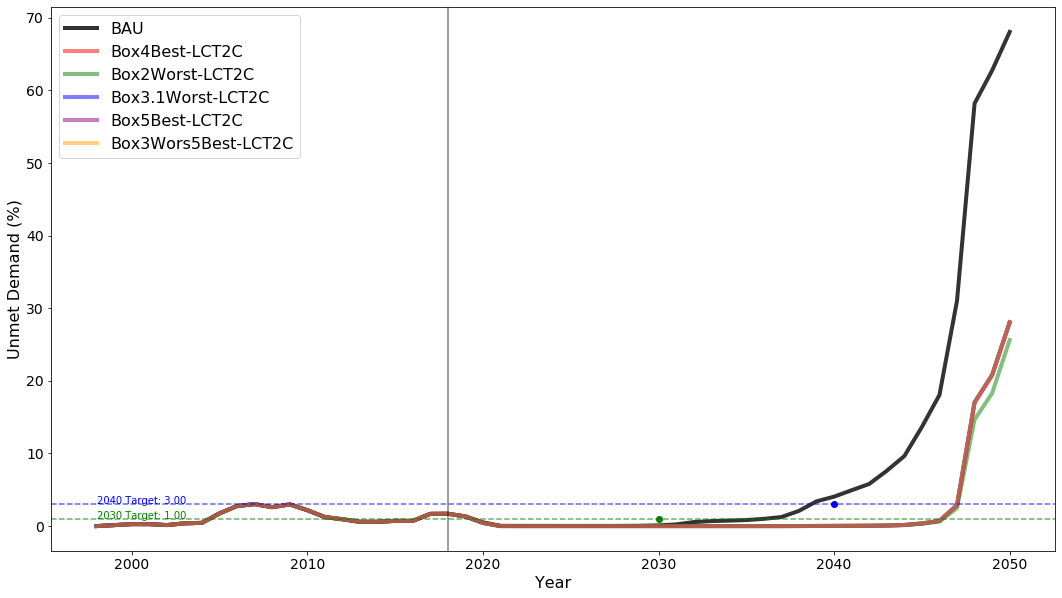

In [53]:
plt.figure(figsize=(18,10))
years = [DT.datetime.strptime(str(int(date)),'%Y') for date in bau_results_df['Time (Year)'].values]
years =  bau_results_df['Time (Year)'].values
plt.plot( years, bau_results_df['unmetPercentageConsumptionPrimary'], color='black', alpha = 0.8, linewidth=4, label='BAU')
plt.plot( years, box4Best['unmetPercentageConsumptionPrimary'], color='red', alpha = 0.5, linewidth=4, label='Box4Best-LCT2C')
plt.plot( years, box2Worst['unmetPercentageConsumptionPrimary'], color='green',alpha = 0.5, linewidth=4, label='Box2Worst-LCT2C')
plt.plot( years, box3_1Worst['unmetPercentageConsumptionPrimary'], color='blue', alpha = 0.5,linewidth=4, label='Box3.1Worst-LCT2C')
plt.plot( years, box5Best['unmetPercentageConsumptionPrimary'], color='purple', alpha = 0.5, linewidth=4, label='Box5Best-LCT2C')
plt.plot( years, box3W5B['unmetPercentageConsumptionPrimary'], color='orange', alpha = 0.5, linewidth=4, label='Box3Wors5Best-LCT2C')

# Add dot and corresponding text

target = 1

plt.axhline(  target ,ls='--',color='green', alpha = 0.6)
plt.text(years[0], target+0.01, f'2030 Target: {target:.2f}',color='green')
plt.plot(2030, target, 'go')

target = 3
plt.axhline(  target ,ls='--',color='blue', alpha = 0.6)
plt.text(years[0], target+0.01, f'2040 Target: {target:.2f}',color='blue')
plt.plot(2040, target, 'bo')
plt.axvline(2018, ls='-',color='black', alpha = 0.5)

#plt.grid( linestyle='-', linewidth=1)
plt.xlabel('Year', size=16)
plt.ylabel('Unmet Demand (%)', size=16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(prop={'size':16})

#### Other indicators in the LCL 2C scenarios

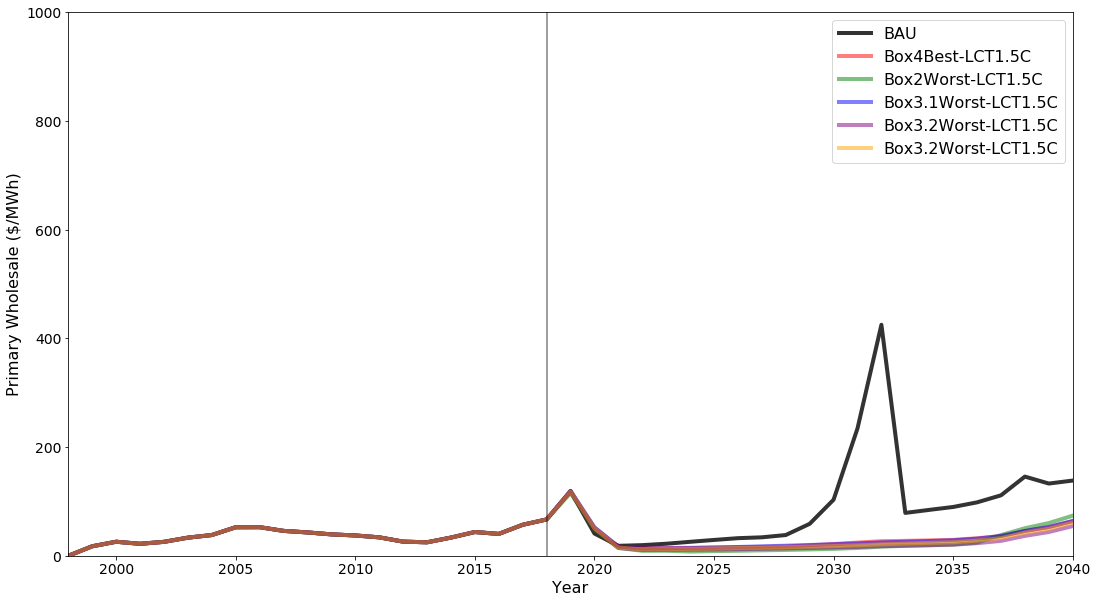

In [54]:
# Wholesale Prices
plt.figure(figsize=(18,10))
years = [DT.datetime.strptime(str(int(date)),'%Y') for date in bau_results_df['Time (Year)'].values]
years =  bau_results_df['Time (Year)'].values
plt.plot( years, bau_results_df['Primary Wholesale ($/MWh)'], color='black', alpha = 0.8, linewidth=4, label='BAU')
plt.plot( years, box4Best['Primary Wholesale ($/MWh)'], color='red', alpha = 0.5, linewidth=4, label='Box4Best-LCT1.5C')
plt.plot( years, box2Worst['Primary Wholesale ($/MWh)'], color='green',alpha = 0.5, linewidth=4, label='Box2Worst-LCT1.5C')
plt.plot( years, box3_1Worst['Primary Wholesale ($/MWh)'], color='blue', alpha = 0.5,linewidth=4, label='Box3.1Worst-LCT1.5C')
plt.plot( years, box5Best['Primary Wholesale ($/MWh)'], color='purple', alpha = 0.5, linewidth=4, label='Box3.2Worst-LCT1.5C')
plt.plot( years, box3W5B['Primary Wholesale ($/MWh)'], color='orange', alpha = 0.5, linewidth=4, label='Box3.2Worst-LCT1.5C')


plt.axvline(2018, ls='-',color='black', alpha = 0.5)
plt.xlim([1998, 2040])
plt.ylim([0, 1000])
#plt.grid( linestyle='-', linewidth=1)
plt.xlabel('Year', size=16)
plt.ylabel('Primary Wholesale ($/MWh)', size=16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(prop={'size':16})

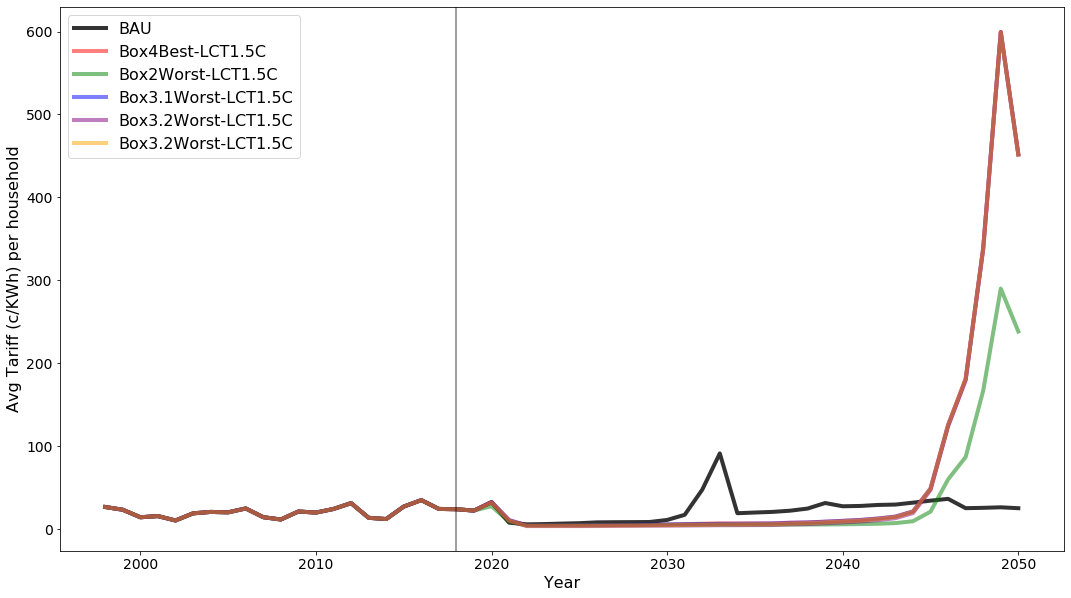

In [55]:
# Tariffs
plt.figure(figsize=(18,10))
years = [DT.datetime.strptime(str(int(date)),'%Y') for date in bau_results_df['Time (Year)'].values]
years =  bau_results_df['Time (Year)'].values
plt.plot( years, bau_results_df['Avg Tariff (c/KWh) per household'], color='black', alpha = 0.8, linewidth=4, label='BAU')
plt.plot( years, box4Best['Avg Tariff (c/KWh) per household'], color='red', alpha = 0.5, linewidth=4, label='Box4Best-LCT1.5C')
plt.plot( years, box2Worst['Avg Tariff (c/KWh) per household'], color='green',alpha = 0.5, linewidth=4, label='Box2Worst-LCT1.5C')
plt.plot( years, box3_1Worst['Avg Tariff (c/KWh) per household'], color='blue', alpha = 0.5,linewidth=4, label='Box3.1Worst-LCT1.5C')
plt.plot( years, box5Best['Avg Tariff (c/KWh) per household'], color='purple', alpha = 0.5, linewidth=4, label='Box3.2Worst-LCT1.5C')
plt.plot( years, box3W5B['Avg Tariff (c/KWh) per household'], color='orange', alpha = 0.5, linewidth=4, label='Box3.2Worst-LCT1.5C')

plt.axvline(2018, ls='-',color='black', alpha = 0.5)

#plt.grid( linestyle='-', linewidth=1)
plt.xlabel('Year', size=16)
plt.ylabel('Avg Tariff (c/KWh) per household', size=16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(prop={'size':16})

### LCT consistent with Paris 1.5 C

In [56]:
##### from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);

x = exp
"""
Paris trajectory to 1.5 C 
Filter by GHG (below 39% value of 2005 by 2025)
Filter by GHG (below 60% value of 2005 by 2030)
Filter by net zero GHGE by 2050
"""    
ooi = 'GHGYear'

reference = bau_results_df[bau_results_df['Time (Year)'] == 2005]['GHGYear'].values

reduction = 0.39
ylc_e1 = target_at_year( outcomes_filtered, ooi, 2025, reference - (reference * reduction), False) #False is below target

reduction = 0.75
ylc_e2 = target_at_year( outcomes_filtered, ooi, 2030, reference - (reference * reduction), False) #False is below target

## Net zero
ylc_e3 = target_at_year( outcomes_filtered, ooi, 2050, 5, False) #False is below target

ylc_e = ylc_e1 &  ylc_e2 & ylc_e3 

"""
Filter by renewableContributionYear (above 50%)
The Victorian Renewable Energy Targets (VRET) https://www.energy.vic.gov.au/renewable-energy/victorias-renewable-energy-targets
25% of electricity generated from RE by 2020
40% by 2025
50% by 2030

"""

ooi = 'renewableContributionYear'    

ylc_re1 = target_at_year( outcomes_filtered, ooi, 2025, 0.40, True) #False is below target
#y = target_at_year( outcomes_filtered, ooi, 2030, 21, False) #False is below target
ylc_re2 = target_at_year( outcomes_filtered, ooi, 2030, 0.50, True) #False is below target


ylc_re= ylc_re1 & ylc_re2

""""
Filter by GA of Primary Wholesale Market (aim for: below 2% in 2030, 5% in 2040)
"""

ooi = 'unmetPercentageConsumptionPrimary'    

ylc_gap1 = target_at_year( outcomes_filtered, ooi, 2030, 2, False) #False is below target
ylc_gap2 = target_at_year( outcomes_filtered, ooi, 2040, 5, False) #False is below target
#ylc_gap3 = target_at_year( outcomes_filtered, ooi, 2050, 50, False) #False is below target

ylc_gap = ylc_gap1 & ylc_gap2 #& ylc_gap3
# """
# Combine Filters
# """
y = ylc_e & ylc_re & ylc_gap

"""
Run PRIM
"""
prim_alg = prim.Prim(x, y, threshold=0.1, threshold_type=prim.ABOVE)
box1 = prim_alg.find_box()


[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 126001 points remaining, containing 22180 cases of interest
[MainProcess/INFO] mean: 0.7067167292448895, mass: 0.05707097562717756, coverage: 0.22912533814247069, density: 0.7067167292448895 restricted_dimensions: 12


In [57]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage    0.661317
density     0.481471
id                11
mass        0.241784
mean        0.481471
res_dim            5
Name: 11, dtype: object

                               box 11                                      
                                  min   max                       qp values
generatorRetirement              -5.0   2.5                     [-1.0, 0.0]
priceChangePercentageWind       -50.0  39.5  [-1.0, 1.8669623673104857e-07]
includePublicallyAnnouncedGen     0.5   1.0                     [0.0, -1.0]
nameplateCapacityChangeWind     -33.5  50.0   [4.928110975249017e-50, -1.0]
priceChangePercentageBrownCoal  -39.5  50.0  [1.5029510563238984e-08, -1.0]



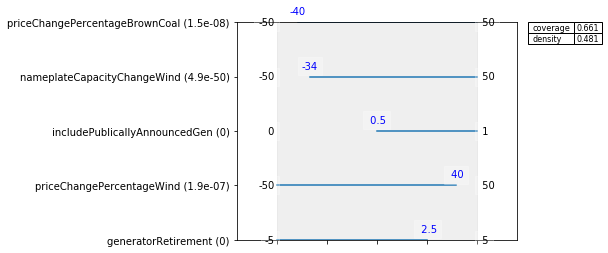

In [58]:
#%matplotlib inline
selected_box = 11

box_1 = box1.inspect(selected_box)
box_1 = box1.inspect(selected_box, style='graph')

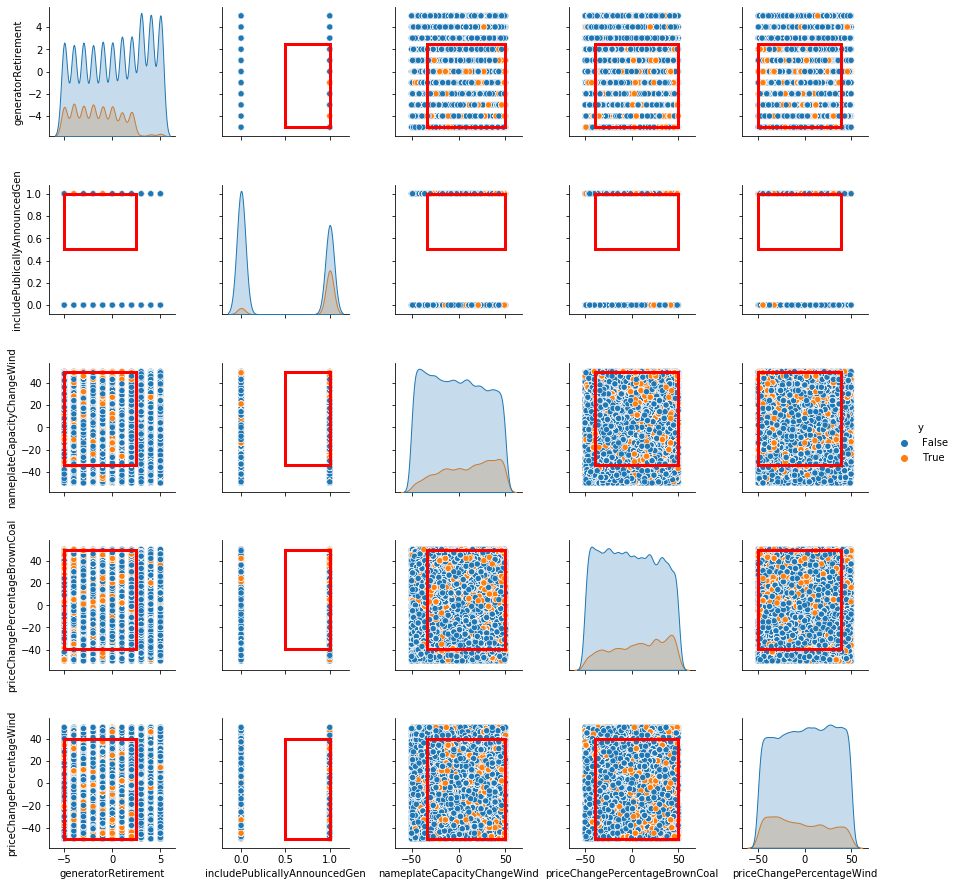

In [59]:
fig = box1.show_pairs_scatter(selected_box)

plt.show()

#### Feature scoring LCT 1.5C best-cases

[MainProcess/INFO] model dropped from analysis because only a single category


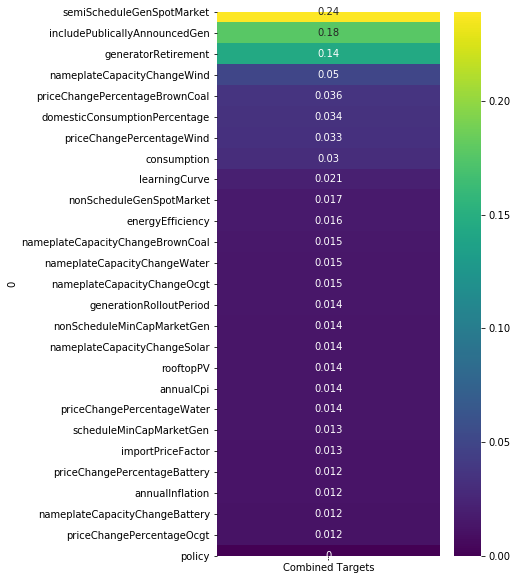

In [60]:
from EMAworkbench.ema_workbench.analysis import feature_scoring

# fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=feature_scoring.RuleInductionType.CLASSIFICATION)
# fs.sort_values(ascending=False, by=1)

x = exp
y_all = {}

#plot using ALL simulations
#y_all['GHGYear'] = data

#plot using average of ALL simulations
#y_all['GHGYear'] = out_avg_ooi

#Plot using only target simulations
y_all['Combined Targets'] = y

fig, ax = plt.subplots(figsize=(5,10))
fs = feature_scoring.get_feature_scores_all(x, y_all)
sns.heatmap(fs, cmap='viridis', annot=True, ax=ax)
plt.show()

In [61]:
#NEGATE LINE 61! COMPLEMENT

# """
# Combine and negate Filters
# """
y = ~ylc_e | ~ylc_re | ~ylc_gap

"""
Run PRIM
"""
prim_alg = prim.Prim(x, y, threshold=0.1, threshold_type=prim.ABOVE)
box1 = prim_alg.find_box()


[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 126001 points remaining, containing 103821 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.07173752589265164, coverage: 0.08706331089086022, density: 1.0 restricted_dimensions: 14


In [62]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage    0.361757
density      0.99014
id                 4
mass        0.301045
mean         0.99014
res_dim            4
Name: 4, dtype: object

                                 box 4                                      
                                   min   max                       qp values
includePublicallyAnnouncedGen      0.0   0.5                     [-1.0, 0.0]
semiScheduleGenSpotMarket          8.0   9.5  [-1.0, 4.017810365751918e-266]
nameplateCapacityChangeWind      -50.0  45.5   [-1.0, 3.971102529412301e-07]
nameplateCapacityChangeBrownCoal -45.5  50.0    [0.006336741358508208, -1.0]



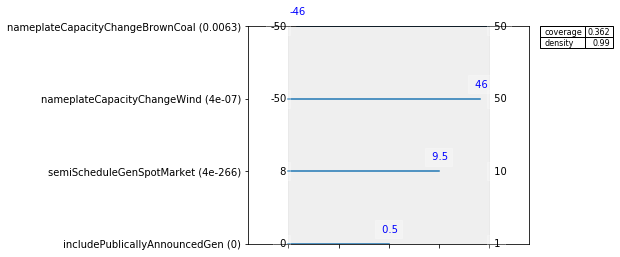

In [63]:
#%matplotlib inline
selected_box = 4

box_1 = box1.inspect(selected_box)
box_1 = box1.inspect(selected_box, style='graph')


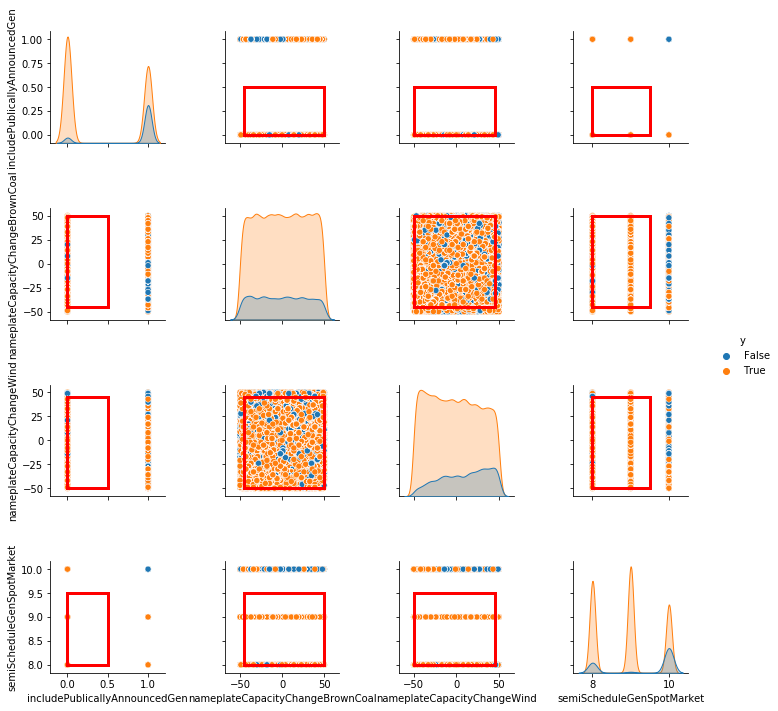

In [64]:
fig = box1.show_pairs_scatter(selected_box)

plt.show()

"The quasi-p-value test, essentially a one sided binomial test, is an estimate of the likelihood that a given uncertainty is included in the definition of the subspace purely by chance." (Bryant and Lempert, 2010)
"
“qp-value” test thus answers the question: what is the probability that Tpoints drawn from the above binomial distribution would have H or more high valued points? When the ratio $H_{-j}$/$T_{-j}$ is close to H/T this number is high, the additional contribution of parameter $r_j$ is low, and thus possibly due to chance. The opposite is the case when H/T is much larger than  $H_{-j}$/$T_{-j}$." (Bryant and Lempert, 2010)

#### Feature scoring LCT 1.5C worst-cases

[MainProcess/INFO] model dropped from analysis because only a single category


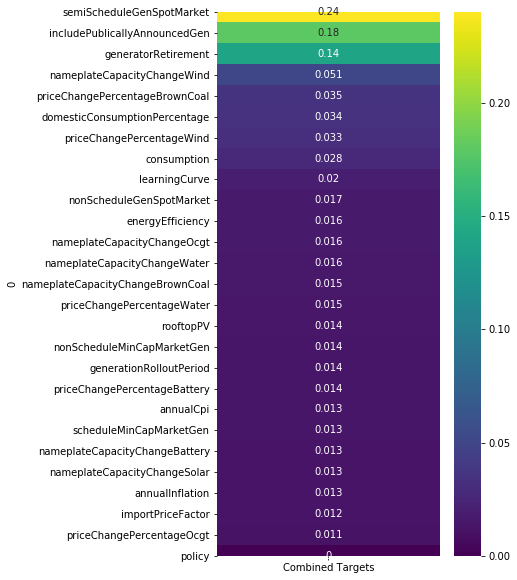

In [65]:
from EMAworkbench.ema_workbench.analysis import feature_scoring

# fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=feature_scoring.RuleInductionType.CLASSIFICATION)
# fs.sort_values(ascending=False, by=1)

x = exp
y_all = {}

#plot using ALL simulations
#y_all['GHGYear'] = data

#plot using average of ALL simulations
#y_all['GHGYear'] = out_avg_ooi

#Plot using only target simulations
y_all['Combined Targets'] = y

fig, ax = plt.subplots(figsize=(5,10))
fs = feature_scoring.get_feature_scores_all(x, y_all)
sns.heatmap(fs, cmap='viridis', annot=True, ax=ax)
plt.show()

Score Using all inputs

In [66]:
# boxInputLimits = [key for key, value in box1.qp[selected_box].items()]  
# experimentsInBox[ boxInputLimits + ['score'] ]

NameError: name 'experimentsInBox' is not defined

Score using only inputs from the selected box

In [ ]:
# experimentsInBox = BoxExperimentsScores(box1, selected_box, y, False) # False uses only box inputs to compute the score

In [ ]:
# boxInputLimits = [key for key, value in box1.qp[selected_box].items()]  
# experimentsInBox[ boxInputLimits + ['score'] ]

In [ ]:
# experiments.loc[5195]

In [ ]:
# experiments.loc[bau_scenario_id]

In [ ]:
# Create a pair plot colored by continent with a density plot of the # diagonal and format the scatter plots.
# sns.pairplot(experimentsInBox[ boxInputLimits + ['score', 'bauQuadrant'] ], hue = 'bauQuadrant', diag_kind = 'kde',
#              plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
#              size = 4)


# for inp in boxInputLimits:
#     print(inp)
    
    
#     g = sns.jointplot(x=experimentsInBox["score"], y=experimentsInBox[inp],  kind="hex")
#     g.ax_joint.axhline(experiments.loc[bau_scenario_id][inp], ls='--')

#     # Plot inputs and targets
#     reference = bau_results_df[bau_results_df['Time (Year)'] == 2005]['GHGYear'].values
#     refLine = reference - (reference * 0.39)    
#     plotInputTargetBox('GHGYear', 2025, refLine)
    
#     refLine = reference - (reference * 0.6)
#     plotInputTargetBox('GHGYear', 2030, refLine)
    
#     plotInputTargetBox('GHGYear', 2050, 5)

#     plotInputTargetBox('renewableContributionYear', 2025, 0.4)
#     plotInputTargetBox('renewableContributionYear', 2030, 0.5)
    
#     plotInputTargetBox('unmetPercentageConsumptionPrimary', 2030, 5)
#     plotInputTargetBox('unmetPercentageConsumptionPrimary', 2040, 10)
#     #plotInputTargetBox('unmetPercentageConsumptionPrimary', 2050, 50)    
    




In [ ]:
# box1.select(selected_box)
# fig = box1.show_pairs_scatter(selected_box)

# plt.show()


### Dimensional Stacking


[MainProcess/INFO] model dropped from analysis because only a single category


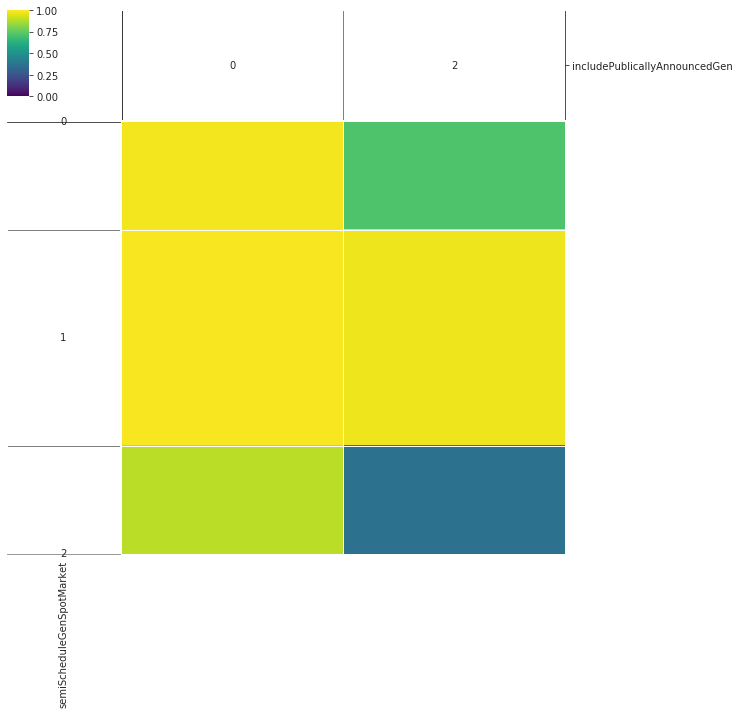

In [68]:

from EMAworkbench.ema_workbench.analysis import dimensional_stacking

x = exp
dimensional_stacking.create_pivot_plot(x,y, 1, nbins=3)
plt.show()



## Directed search: PRIM - Just Transition (JT)
Includes trajectories with low tarifffs, EV and good autonomy of secondary markets

In [69]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);

x = exp

"""
Filter by LIHC for the Energy Vulnerability Analysis
Filter LIHC 20% below 2019 levels by 2025
Filter LIHC 40% below 2019 levels by 2030
Filter LIHC 60% below 2019 levels by 2040
"""
#dataframe with 

ooi = 'Energy Vulnerability Percentage'    

referenceYear = 2019
reference = ev_results_BAU_df[referenceYear].values

reduction = 0.2
yjt_ev1 = target_at_year( outcomes_filtered, ooi, 2025, reference - (reference * reduction), False) #False is below target

reduction = 0.4
yjt_ev2 = target_at_year( outcomes_filtered, ooi, 2035, reference - (reference * reduction), False) #False is below target

reduction = 0.6
yjt_ev3 = target_at_year( outcomes_filtered, ooi, 2040, reference - (reference * reduction), False) #False is below target

#median_ev = 0.300779648
# median_ev = 0.1
# yjt_ev1= target_at_year( outcomes_filtered, ooi, 2030, median_ev, False) #False is below target


""""
Filter GA of Secondary Wholesale Market (below x% of electricity to be imported using percentage of unmet demand/consumption)
Filter GA 60% maximum in 2030
Filter GA 50% maximum in 2040
"""

ooi = 'unmetPercentageConsumptionSecondary'    

yjt_gas1 = target_at_year( outcomes_filtered, ooi, 2030, 60, False) #False is below target
yjt_gas2 = target_at_year( outcomes_filtered, ooi, 2040, 50, False)

yjt_sec_used = target_at_year( outcomes_filtered, 'secondarySpotProductionYear', 2030, 0.1, True) #False is below target




# """
# Combine Filters
# """
y = yjt_ev1 & yjt_ev2 & yjt_ev3 & yjt_gas1 & yjt_gas2 & yjt_sec_used
#y = yjt_sec_used
"""
Run PRIM
"""
prim_alg = prim.Prim(x, y, threshold=0.1, threshold_type=prim.ABOVE)
box1 = prim_alg.find_box()


[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 126001 points remaining, containing 26738 cases of interest
[MainProcess/INFO] mean: 0.7302234299516909, mass: 0.052571011341179835, coverage: 0.1809035829157005, density: 0.7302234299516909 restricted_dimensions: 11


In [70]:
box1.inspect_tradeoff()


alt.VConcatChart(...)

coverage    0.509724
density      0.49551
id                 7
mass        0.218292
mean         0.49551
res_dim            4
Name: 7, dtype: object

                            box 7                                      
                              min    max                      qp values
semiScheduleGenSpotMarket     8.5    9.5                     [0.0, 0.0]
scheduleMinCapMarketGen      44.5  300.0  [1.968631065444455e-37, -1.0]
annualInflation               1.5    5.0  [8.751626115978537e-23, -1.0]
nameplateCapacityChangeWind -44.5   50.0  [0.0007304401680458524, -1.0]



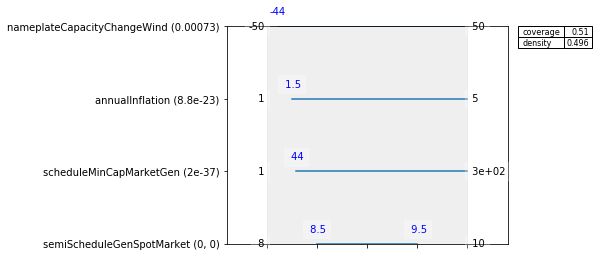

In [74]:
#%matplotlib inline
selected_box = 7

box_1 = box1.inspect(selected_box)
box_1 = box1.inspect(selected_box, style='graph')


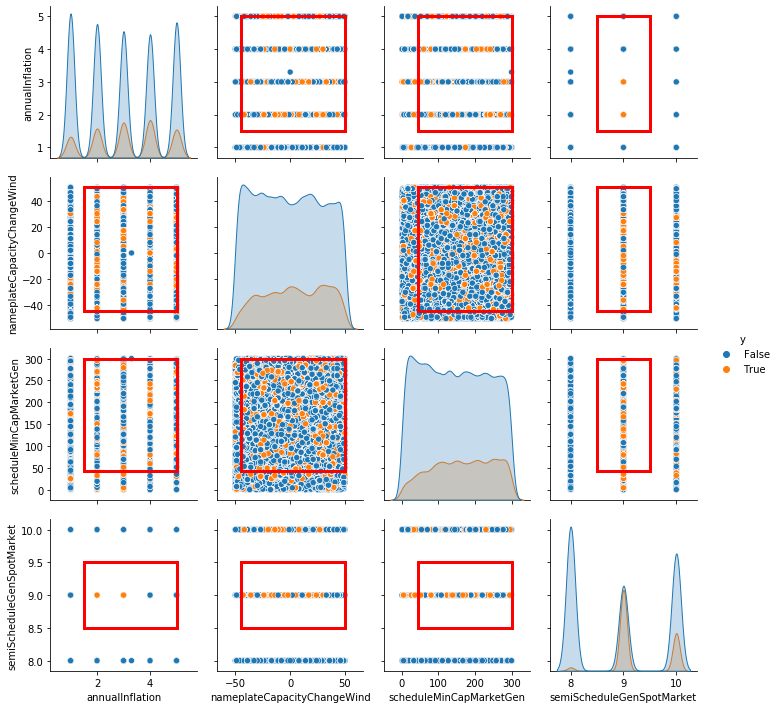

In [75]:
fig = box1.show_pairs_scatter(selected_box)

plt.show()

### Feature scoring best-cases JT

[MainProcess/INFO] model dropped from analysis because only a single category


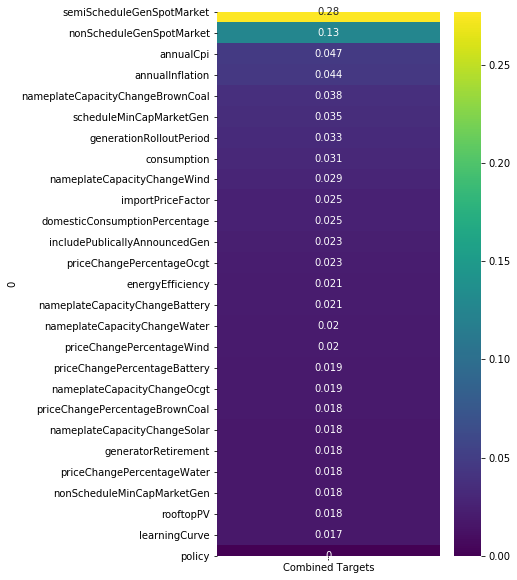

In [76]:
x = exp
y_all = {}

#plot using ALL simulations
#y_all['GHGYear'] = data

#plot using average of ALL simulations
#y_all['GHGYear'] = out_avg_ooi

#Plot using only target simulations
y_all['Combined Targets'] = y

fig, ax = plt.subplots(figsize=(5,10))
fs = feature_scoring.get_feature_scores_all(x, y_all)
sns.heatmap(fs, cmap='viridis', annot=True, ax=ax)
plt.show()

### JT worst-cases

In [77]:
# """
# Combine Filters
# """
y = ~yjt_ev1 | ~yjt_ev2 | ~yjt_ev3 | ~yjt_gas1 | ~yjt_gas2

"""
Run PRIM
"""
prim_alg = prim.Prim(x, y, threshold=0.1, threshold_type=prim.ABOVE)
box1 = prim_alg.find_box()


[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 126001 points remaining, containing 67525 cases of interest
[MainProcess/INFO] mean: 0.995900480633305, mass: 0.05614241156816216, coverage: 0.10433172898926324, density: 0.995900480633305 restricted_dimensions: 7


In [78]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage     0.104332
density        0.9959
id                 13
mass        0.0561424
mean           0.9959
res_dim             7
Name: 13, dtype: object

                                 box 13                                     
                                    min   max                      qp values
semiScheduleGenSpotMarket           8.0   8.5                    [-1.0, 0.0]
generationRolloutPeriod             1.0   7.5  [-1.0, 1.865398888057872e-66]
nameplateCapacityChangeWater      -50.0  45.5  [-1.0, 3.062489877593641e-09]
nameplateCapacityChangeBrownCoal  -50.0  45.5  [-1.0, 6.104603658975837e-05]
nameplateCapacityChangeSolar      -50.0  44.5  [-1.0, 0.0004099530830547022]
nonScheduleGenSpotMarket            8.5   9.5                     [0.0, 0.0]
domesticConsumptionPercentage      23.5  50.0  [2.083616134769532e-17, -1.0]



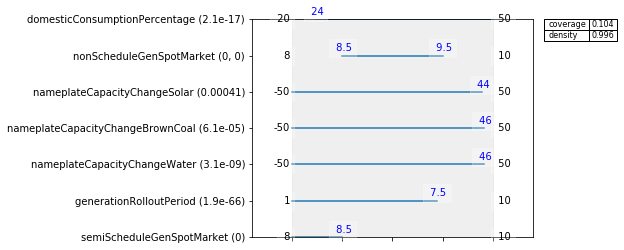

In [79]:
#%matplotlib inline
selected_box = 13

box_1 = box1.inspect(selected_box)
box_1 = box1.inspect(selected_box, style='graph')

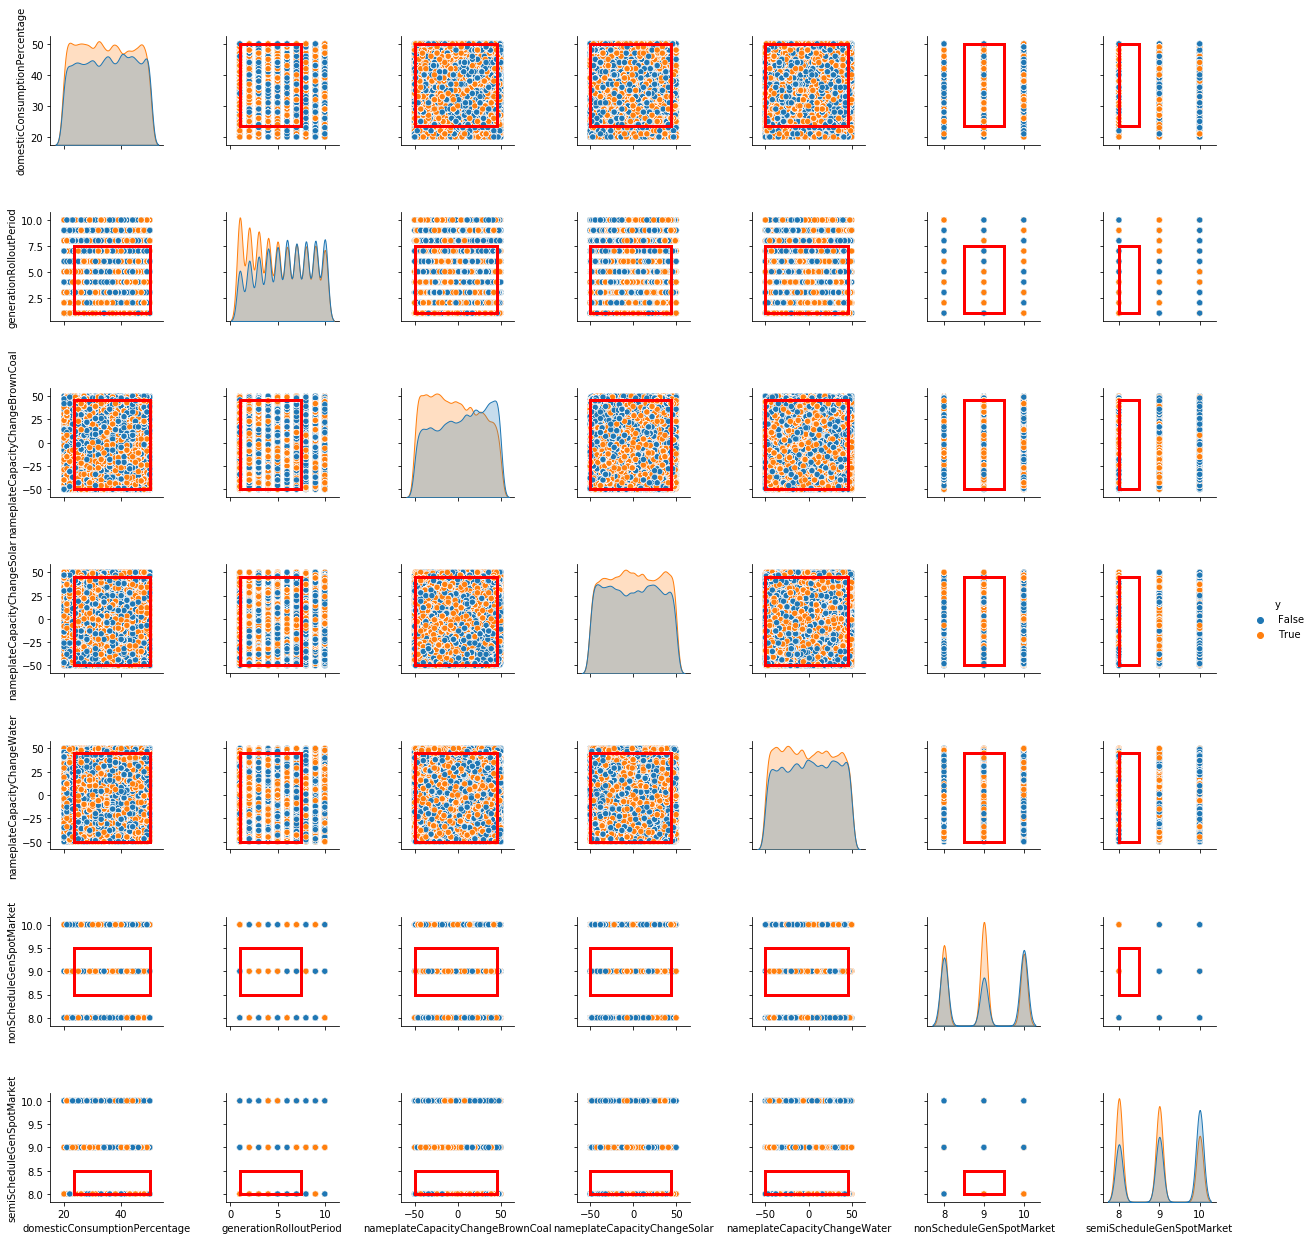

In [80]:
fig = box1.show_pairs_scatter(selected_box)

plt.show()

### Feature scoring worst-cases JT

[MainProcess/INFO] model dropped from analysis because only a single category


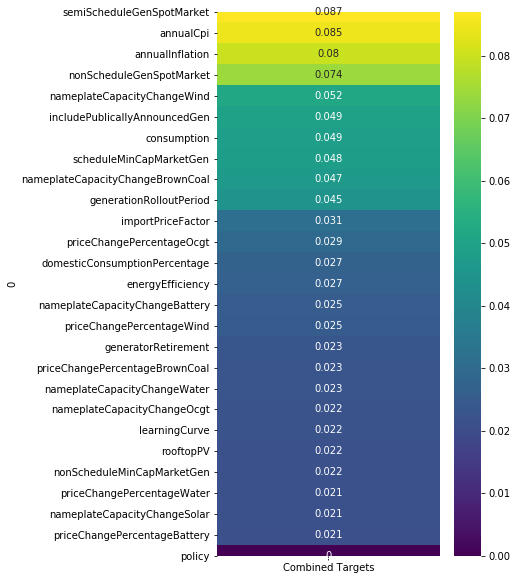

In [82]:
x = exp
y_all = {}

#plot using ALL simulations
#y_all['GHGYear'] = data

#plot using average of ALL simulations
#y_all['GHGYear'] = out_avg_ooi

#Plot using only target simulations
y_all['Combined Targets'] = y

fig, ax = plt.subplots(figsize=(5,10))
fs = feature_scoring.get_feature_scores_all(x, y_all)
sns.heatmap(fs, cmap='viridis', annot=True, ax=ax)
plt.show()

## Direct search: PRIM Sustainable Transition (ST)

### ST best-cases

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);

x = exp
"""
LCT 1.5 C transition
Filter by GHGE (below 39% value of 2005 by 2025)
Filter by GHGE (below 60% value of 2005 by 2030)
Filter by net zero GHGE by 2050
"""    
ooi = 'GHGYear'

reference = bau_results_df[bau_results_df['Time (Year)'] == 2005]['GHGYear'].values

reduction = 0.39
ylc_e1 = target_at_year( outcomes_filtered, ooi, 2025, reference - (reference * reduction), False) #False is below target

reduction = 0.60
ylc_e2 = target_at_year( outcomes_filtered, ooi, 2030, reference - (reference * reduction), False) #False is below target

## Net zero
ylc_e3 = target_at_year( outcomes_filtered, ooi, 2050, 5, False) #False is below target

ylc_e = ylc_e1 &  ylc_e2 & ylc_e3 

"""
Filter by renewableContributionYear (above 50%)
The Victorian Renewable Energy Targets (VRET) https://www.energy.vic.gov.au/renewable-energy/victorias-renewable-energy-targets
25% of electricity generated from RE by 2020
40% by 2025
50% by 2030

"""

ooi = 'renewableContributionYear'    

ylc_re1 = target_at_year( outcomes_filtered, ooi, 2025, 0.40, True) #False is below target
ylc_re2 = target_at_year( outcomes_filtered, ooi, 2030, 0.50, True) #False is below target


ylc_re= ylc_re1 & ylc_re2

""""
Filter by GA of Primary Wholesale Market (below 2% by 2030, and below 5% by 2040)
"""

ooi = 'unmetPercentageConsumptionPrimary'    

ylct_gap1 = target_at_year( outcomes_filtered, ooi, 2030, 2, False) #False is below target
ylct_gap2 = target_at_year( outcomes_filtered, ooi, 2040, 5, False) #False is below target
#ylct_gap3 = target_at_year( outcomes_filtered, ooi, 2050, 40, False) #False is below target

ylct_gap = ylct_gap1 & ylct_gap2 
#& ylct_gap3

"""
Filter by LIHC for the Energy Vulnerability Analysis
Filter LIHC 20% below 2019 levels by 2025
Filter LIHC 40% below 2019 levels by 2030
Filter LIHC 60% below 2019 levels by 2040
"""
#dataframe with 

ooi = 'Energy Vulnerability Percentage'    

referenceYear = 2019
reference = ev_results_BAU_df[referenceYear].values

reduction = 0.2
yjt_ev1 = target_at_year( outcomes_filtered, ooi, 2025, reference - (reference * reduction), False) #False is below target

reduction = 0.4
yjt_ev2 = target_at_year( outcomes_filtered, ooi, 2030, reference - (reference * reduction), False) #False is below target

reduction = 0.6
yjt_ev3 = target_at_year( outcomes_filtered, ooi, 2040, reference - (reference * reduction), False) #False is below target

yjt_ev = yjt_ev1 & yjt_ev2 & yjt_ev3

""""
Filter GA of Secondary Wholesale Market (below x% of electricity to be imported using percentage of unmet demand/consumption)
Filter GA 60% maximum in 2030
Filter GA 50% maximum in 2040
"""

ooi = 'unmetPercentageConsumptionSecondary'    

yjt_gas1 = target_at_year( outcomes_filtered, ooi, 2025, 50, False) #False is below target
yjt_gas2 = target_at_year( outcomes_filtered, ooi, 2030, 40, False)

yjt_gas = yjt_gas1 & yjt_gas2

yjt_sec_used = target_at_year( outcomes_filtered, 'secondarySpotProductionYear', 2030, 0.1, True) #False is below target

# """
# Combine Filters
# """
y = ylc_e & ylc_re & yjt_ev &  ylct_gap &  yjt_gas & yjt_sec_used

"""
Run PRIM
"""
prim_alg = prim.Prim(x, y, threshold=0.1, threshold_type=prim.ABOVE)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
#%matplotlib inline
selected_box = 6

box_1 = box1.inspect(selected_box)
box_1 = box1.inspect(selected_box, style='graph')


In [ ]:
fig = box1.show_pairs_scatter(selected_box)

plt.show()

## Feature scoring ST best-cases

In [ ]:
x = exp
y_all = {}

#plot using ALL simulations
#y_all['GHGYear'] = data

#plot using average of ALL simulations
#y_all['GHGYear'] = out_avg_ooi

#Plot using only target simulations
y_all['Combined Targets'] = y

fig, ax = plt.subplots(figsize=(5,10))
fs = feature_scoring.get_feature_scores_all(x, y_all)
sns.heatmap(fs, cmap='viridis', annot=True, ax=ax)
plt.show()

### Dimensional Stacking JT

In [ ]:

from EMAworkbench.ema_workbench.analysis import dimensional_stacking

x = exp
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3)
plt.show()



### ST worst-cases

In [ ]:
# """
# Combine Filters
# """
y = ~ylc_e | ~ylc_re | ~yjt_ev | ~ylct_gap | ~yjt_gas | ~yjt_sec_used

"""
Run PRIM
"""
prim_alg = prim.Prim(x, y, threshold=0.1, threshold_type=prim.ABOVE)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
#%matplotlib inline
selected_box = 13

box_1 = box1.inspect(selected_box)
box_1 = box1.inspect(selected_box, style='graph')


In [ ]:
fig = box1.show_pairs_scatter(selected_box)

plt.show()

### Feature scoring worst-cases

In [ ]:
x = exp
y_all = {}

#plot using ALL simulations
#y_all['GHGYear'] = data

#plot using average of ALL simulations
#y_all['GHGYear'] = out_avg_ooi

#Plot using only target simulations
y_all['Combined Targets'] = y

fig, ax = plt.subplots(figsize=(5,10))
fs = feature_scoring.get_feature_scores_all(x, y_all)
sns.heatmap(fs, cmap='viridis', annot=True, ax=ax)
plt.show()

### Dimensional stacking

In [ ]:

from EMAworkbench.ema_workbench.analysis import dimensional_stacking

x = exp
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3)
plt.show()



### Full-Factorial Tests

In [ ]:
from ema_workbench import load_results

resultsSTff = load_results(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/gr4sp_ST2021-Aug-31.tar.gz')


In [ ]:
experimentsSTff, outcomesSTff = resultsSTff
experimentsSTff.describe()

In [ ]:
# consumption = 0
# generatorRetirement = -1
# includePublicallyAnnouncedGen = 1
# nameplateCapacityChangeWind = 30
# priceChangePercentageBrownCoal = 30
# semiScheduleGenSpotMarket = 8

# q1 = experimentsLCTff['consumption'] == consumption
# q2 = experimentsLCTff['generatorRetirement'] == generatorRetirement
# q3 = experimentsLCTff['includePublicallyAnnouncedGen'] == includePublicallyAnnouncedGen
# q4 = experimentsLCTff['nameplateCapacityChangeWind'] == nameplateCapacityChangeWind
# q5 = experimentsLCTff['priceChangePercentageBrownCoal'] == priceChangePercentageBrownCoal
# q6 = experimentsLCTff['semiScheduleGenSpotMarket'] == semiScheduleGenSpotMarket

# print(np.unique(q1 & q2 & q3 & q4 & q5 & q6, return_counts=True))
# experimentsLCTff[q1 & q2 & q3 & q4 & q5 & q6]

In [ ]:
# FF using the most influential factors for the ST scenario
uncertaintiesSTff = experimentsSTff.columns[:-3]

#from startYear
startYear = 2000
startYearShift = (startYear - 1998)

time = outcomesSTff['TIMEYear'][0, startYearShift:]


# Filter outcomes taking into account the startYear, and removing Seed Experiment info. 
# Seed it is useful if I want to retrieve more info from the csv files, or redo the experiments with the
# simulation parameters
outcomes_filteredSTff = {k:v[:, startYearShift:] for k,v in outcomesSTff.items() if k != 'seedExperimentCsv'}


In [ ]:
ooi = 'GHGYear'
data_GHG_household = outcomes_filteredSTff[ooi]

In [ ]:
""" Converts household data in tCO2e into total residential data in MtCO2e"""
data_GHG_residential = (data_GHG_household * outcomes_filteredSTff['numConsumersYear']) / 1000000.0

""" Applies scaling factor used in simulation, so that data represents total emissions, not only residential (30%)"""
data_GHG_total = data_GHG_residential / 0.3


"""Overwrite GHG with the data of interest"""
outcomes_filteredSTff[ooi] = data_GHG_total


In [ ]:
ooi = 'consumptionYear'
data_consumption_household = outcomes_filteredSTff[ooi]

In [ ]:
""" Converts household data in KWh into total residential data in MWh"""
data_consumption_residential = (data_consumption_household * outcomes_filteredSTff['numConsumersYear']) / 1000.0

""" Applies scaling factor used in simulation, so that data represents total consumption, not only residential"""
data_consumption_total = data_consumption_residential / 0.3

"""Overwrite Consumption with the data of interest"""
outcomes_filteredSTff[ooi] = data_consumption_total

Create Percentage of Unmet Consumption

In [ ]:
primary = outcomes_filteredSTff['primarySpotProductionYear']
secondary = outcomes_filteredSTff['secondarySpotProductionYear']
off = outcomes_filteredSTff['offSpotProductionYear']
unmetPrimary = outcomes_filteredSTff['primaryUnmetDemandMwh']
unmetSecondary = outcomes_filteredSTff['secondaryUnmetDemandMwh']

consumptionPrimary = primary + off + unmetPrimary
consumptionSecondary = secondary + off + unmetSecondary

percentageUnmetPrimary = (unmetPrimary/consumptionPrimary)*100
percentageUnmetSecondary = np.divide(unmetSecondary, consumptionSecondary, 
                                     out=np.zeros_like(unmetSecondary), where=consumptionSecondary!=0) *100

where_are_NaNs = np.isnan(percentageUnmetPrimary)
percentageUnmetPrimary[where_are_NaNs] = 0

where_are_NaNs = np.isnan(percentageUnmetSecondary)
percentageUnmetSecondary[where_are_NaNs] = 0

outcomes_filteredSTff['unmetPercentageConsumptionPrimary'] = percentageUnmetPrimary
outcomes_filteredSTff['unmetPercentageConsumptionSecondary'] = percentageUnmetSecondary

In [ ]:
# Energy vulnerability results
ev_results_ST_df = pd.read_excel(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/notebookGr4sp/outputs/data/EV_ST2021-Sep-1_all.xlsx', index_col=[0])
ev_results_BAU_df = pd.read_excel(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/notebookGr4sp/outputs/data/EV_all_BAU.xlsx', index_col=[0])

In [ ]:
# Duplicate results from 2040 into the years of 2040-2050

ev_results_ST_df.insert(0, 1998, ev_results_ST_df[2000])
ev_results_ST_df.insert(0, 1999, ev_results_ST_df[2000])
for t in range(2041,2051):
     ev_results_ST_df[t] = ev_results_ST_df[2040]
        
# Add it to outcomes data structure
outcomes_filteredSTff['Energy Vulnerability Percentage'] = ev_results_ST_df.values

In [ ]:
# Duplicate results BAU from 2040 into the years of 2040-2050

ev_results_BAU_df.insert(0, 1998, ev_results_BAU_df[2000])
ev_results_BAU_df.insert(0, 1999, ev_results_BAU_df[2000])
for t in range(2041,2051):
     ev_results_BAU_df[t] = ev_results_BAU_df[2040]
        
# Add it to outcomes data structure
outcomes['Energy Vulnerability Percentage'] =  np.append(outcomes['Energy Vulnerability Percentage'],
                                                         ev_results_BAU_df.values, axis=0)

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);

x = experimentsSTff
"""
LCT 1.5 C transition
Filter by GHGE (below 39% value of 2005 by 2025)
Filter by GHGE (below 60% value of 2005 by 2030)
Filter by net zero GHGE by 2050
"""    
ooi = 'GHGYear'

reference = bau_results_df[bau_results_df['Time (Year)'] == 2005]['GHGYear'].values

reduction = 0.39
ylc_e1 = target_at_year( outcomes_filteredSTff, ooi, 2025, reference - (reference * reduction), False) #False is below target

reduction = 0.60
ylc_e2 = target_at_year( outcomes_filteredSTff, ooi, 2030, reference - (reference * reduction), False) #False is below target

## Net zero
ylc_e3 = target_at_year( outcomes_filteredSTff, ooi, 2050, 5, False) #False is below target

ylc_e = ylc_e1 &  ylc_e2 & ylc_e3 

"""
Filter by renewableContributionYear (above 50%)
The Victorian Renewable Energy Targets (VRET) https://www.energy.vic.gov.au/renewable-energy/victorias-renewable-energy-targets
25% of electricity generated from RE by 2020
40% by 2025
50% by 2030

"""

ooi = 'renewableContributionYear'    

ylc_re1 = target_at_year( outcomes_filteredSTff, ooi, 2025, 0.40, True) #False is below target
ylc_re2 = target_at_year( outcomes_filteredSTff, ooi, 2030, 0.50, True) #False is below target


ylc_re= ylc_re1 & ylc_re2

""""
Filter by GA of Primary Wholesale Market (below 2% by 2030, and below 5% by 2040)
"""

ooi = 'unmetPercentageConsumptionPrimary'    

ylct_gap1 = target_at_year( outcomes_filteredSTff, ooi, 2030, 2, False) #False is below target
ylct_gap2 = target_at_year( outcomes_filteredSTff, ooi, 2040, 5, False) #False is below target
#ylct_gap3 = target_at_year( outcomes_filtered, ooi, 2050, 40, False) #False is below target

ylct_gap = ylct_gap1 & ylct_gap2 
#& ylct_gap3

"""
Filter by LIHC for the Energy Vulnerability Analysis
Filter LIHC 20% below 2019 levels by 2025
Filter LIHC 40% below 2019 levels by 2030
Filter LIHC 60% below 2019 levels by 2040
"""
#dataframe with 

ooi = 'Energy Vulnerability Percentage'    

referenceYear = 2019
reference = ev_results_BAU_df[referenceYear].values

reduction = 0.2
yjt_ev1 = target_at_year( outcomes_filteredSTff, ooi, 2025, reference - (reference * reduction), False) #False is below target

reduction = 0.4
yjt_ev2 = target_at_year( outcomes_filteredSTff, ooi, 2030, reference - (reference * reduction), False) #False is below target

reduction = 0.6
yjt_ev3 = target_at_year( outcomes_filteredSTff, ooi, 2040, reference - (reference * reduction), False) #False is below target

yjt_ev = yjt_ev1 & yjt_ev2 & yjt_ev3

""""
Filter GA of Secondary Wholesale Market (below x% of electricity to be imported using percentage of unmet demand/consumption)
Filter GA 60% maximum in 2030
Filter GA 50% maximum in 2040
"""

ooi = 'unmetPercentageConsumptionSecondary'    

yjt_gas1 = target_at_year( outcomes_filteredSTff, ooi, 2025, 50, False) #False is below target
yjt_gas2 = target_at_year( outcomes_filteredSTff, ooi, 2030, 40, False)

yjt_gas = yjt_gas1 & yjt_gas2

yjt_sec_used = target_at_year( outcomes_filteredSTff, 'secondarySpotProductionYear', 2030, 0.1, True) #False is below target

# """
# Combine Filters
# """
y = ylc_e & ylc_re & yjt_ev &  ylct_gap &  yjt_gas & yjt_sec_used

"""
Run PRIM
"""
prim_alg = prim.Prim(x, y, threshold=0.1, threshold_type=prim.ABOVE)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
#%matplotlib inline
selected_box = 5

box_1 = box1.inspect(selected_box)
box_1 = box1.inspect(selected_box, style='graph')


In [ ]:
fig = box1.show_pairs_scatter(selected_box)

plt.show()

In [ ]:
from EMAworkbench.ema_workbench.analysis import feature_scoring

x = experimentsSTff
y_all = {}

#plot using ALL simulations
#y_all['GHGYear'] = data

#plot using average of ALL simulations
#y_all['GHGYear'] = out_avg_ooi

#Plot using only target simulations
y_all['Combined Targets'] = y

fig, ax = plt.subplots(figsize=(5,10))
fs = feature_scoring.get_feature_scores_all(x, y_all)
sns.heatmap(fs, cmap='viridis', annot=True, ax=ax)
plt.show()